In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
import requests
from bs4 import BeautifulSoup
from html_table_parser import parser_functions
from selenium import webdriver 

In [81]:
import re
import math
import pickle
import time

In [11]:
df = pd.read_csv('data_files/2000이후 데이터.csv', index_col='날짜')

In [12]:
for year in range(2000, 2023):
    globals()[f'df{year}'] = df[df['연도'] == year][['S&P500', '미국채10년', 'GSCI', '기준금리']]

In [13]:
df = df[['S&P500', '미국채10년', 'GSCI', '기준금리']]

In [14]:
df

S&P500  미국채10년       GSCI  기준금리
날짜                                          
2022-05-04  4300.17   2.946  3958.5029   1.5
2022-05-03  4175.48   2.975  3837.0591   1.5
2022-05-02  4155.38   2.977  3903.0850   1.5
2022-04-29  4131.93   2.938  3882.9910   1.5
2022-04-28  4287.50   2.832  3884.4270   1.5
...             ...     ...        ...   ...
2000-01-07  1441.50   6.513  2689.9790   5.0
2000-01-06  1403.50   6.540  2713.8350   5.0
2000-01-05  1402.10   6.599  2714.8110   5.0
2000-01-04  1399.40   6.499  2740.7410   5.0
2000-01-03  1455.20   6.594  2766.7710   5.0

[5616 rows x 4 columns]

## max 0.5, min 0.1 비율값 조합 가져오기

In [2]:
from itertools import *
from decimal import Decimal

In [3]:
i = Decimal('0.1')
li = []
while i <= Decimal('0.5'):
    li.append(i)
    i += Decimal('0.1')

In [4]:
com_li = list(product(li, repeat=4))

In [5]:
ratio_li = []
for i in com_li:
    if sum(i) == Decimal('1.0'):
        ratio_li.append(i)

In [15]:
df365 = df.shift(253).loc['2021-05-04':]

In [16]:
df365

S&P500  미국채10년       GSCI  기준금리
날짜                                          
2021-05-04  4300.17   2.946  3958.5029  1.50
2021-05-03  4175.48   2.975  3837.0591  1.50
2021-04-30  4155.38   2.977  3903.0850  1.50
2021-04-29  4131.93   2.938  3882.9910  1.50
2021-04-28  4287.50   2.832  3884.4270  1.50
...             ...     ...        ...   ...
2000-01-07  1300.80   4.996  4159.3750  5.25
2000-01-06  1295.90   4.956  4136.2651  5.25
2000-01-05  1298.30   4.929  4140.6089  5.25
2000-01-04  1333.30   5.043  4124.9019  5.25
2000-01-03  1347.60   5.154  4044.5049  5.25

[5363 rows x 4 columns]

## 연도별 가장 이상적인 비율 구하기

In [16]:
max_ratio_dic = {}
for year in range(2000, 2023):
    max_money = 0
    print(f"{year}년 데이터 분석")
    for ratio in ratio_li:
        money = 10000000
    #     print(f"주식 {ratio[0]}, 채권 {ratio[1]}, 원자재 {ratio[2]}, 예금 {ratio[3]}")
        df_year = globals()[f'df{year}']

        sp_split_money = math.floor(money * ratio[0])
        mi10_split_money = math.floor(money * ratio[1])
        gsci_split_money = math.floor(money * ratio[2])
        y_split_money = math.floor(money * ratio[3])
        # print(sp_split_money, mi10_split_money, gsci_split_money, y_split_money)

        # S&P지수
        sp_price = df_year.iloc[-1]['S&P500']
        sp_num = int(sp_split_money / sp_price)
        rest_money = sp_split_money - sp_price * sp_num
        sp_result = df_year.iloc[0]['S&P500'] * sp_num

        # 미국 10년채
        mi10_old_rate = df_year.iloc[-1]['미국채10년'] 
        mi10_old_price = 10000 / (1+mi10_old_rate / 100)
        mi10_num = int(mi10_split_money / mi10_old_price)

        # 구입당시 금리만큼 이자계산
        mi10_old_total_price = mi10_old_price * mi10_num
        rest_money += mi10_split_money - mi10_old_total_price
        mi10_rate_price = mi10_old_total_price * (mi10_old_rate / 100)


        # 1년후 바뀐 가격으로 판매
        mi10_new_rate = df_year.iloc[0]['미국채10년'] 
        mi10_new_price = 10000 / (1+mi10_new_rate / 100)
        mi10_new_total_price = mi10_new_price * mi10_num
        mi10_result = mi10_new_total_price + mi10_rate_price
        # print(f"금리변화 {mi10_old_rate} => {mi10_new_rate}, 금리변화에 따른 가격 변환 {round(mi10_old_total_price)} => {round(mi10_new_total_price)}, 이자: {round(mi10_rate_price)}, 최종결과: {round(mi10_result)}")


        # GSCI지수(원자재)
        gsci_buy_price = df_year.iloc[-1]['GSCI']
        gsci_num = int(gsci_split_money / gsci_buy_price)
        gsci_buy_total_price = gsci_buy_price * gsci_num
        rest_money += gsci_split_money - gsci_buy_total_price
        gsci_sell_price = df_year.iloc[0]['GSCI']
        gsci_result = gsci_sell_price * gsci_num
        # print(f"가격 {gsci_buy_price} => {gsci_sell_price}, 이익율 {round((gsci_sell_price - gsci_buy_price) / gsci_buy_price, 2)}, 결과 {round(gsci_buy_total_price)} => {round(gsci_result)}")

        # 예금
        y_rate = df_year.iloc[-1]['기준금리']
        y_price = (y_split_money + rest_money) * (y_rate/100)
        y_result = y_split_money + y_price + rest_money
        # print(f"이자율 {y_rate}, 이자 {y_price}, 수익금 {y_result}")

        result = sp_result + mi10_result + gsci_result + y_result
    #     print(f"투자금액 {round(money)}, 1년후 결과 {round(result)}, 이익 {round(result-money)}, 이익율 {round(((result - money) / money) * 100, 2)}%")
        if result > max_money:
            max_money = result
            max_ratio = ratio
            print(f"주식 {ratio[0]}, 채권 {ratio[1]}, 원자재 {ratio[2]}, 예금 {ratio[3]}")
            print(f"투자금액 {round(money)}, 1년후 결과 {round(result)}, 이익 {round(result-money)}, 이익율 {round(((result - money) / money) * 100, 2)}%")
        money = math.floor(result)
    max_ratio_dic[f"{year}년"] = max_ratio
        
    

2000년 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11734395, 이익 1734395, 이익율 17.34%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12183043, 이익 2183043, 이익율 21.83%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12632933, 이익 2632933, 이익율 26.33%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12663087, 이익 2663087, 이익율 26.63%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12692959, 이익 2692959, 이익율 26.93%
2001년 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9312270, 이익 -687730, 이익율 -6.88%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9657693, 이익 -342307, 이익율 -3.42%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10004527, 이익 4527, 이익율 0.05%
2002년 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10894973, 이익 894973, 이익율 8.95%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11144729, 이익 1144729, 이익율 11.45%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11394485, 이익 1394485, 이익율 13.94%
주식 0.1, 채권 0

투자금액 10000000, 1년후 결과 9333497, 이익 -666503, 이익율 -6.67%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9689122, 이익 -310878, 이익율 -3.11%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10044747, 이익 44747, 이익율 0.45%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10057694, 이익 57694, 이익율 0.58%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10070641, 이익 70641, 이익율 0.71%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10130692, 이익 130692, 이익율 1.31%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10143639, 이익 143639, 이익율 1.44%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10156586, 이익 156586, 이익율 1.57%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10169532, 이익 169532, 이익율 1.7%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10216637, 이익 216637, 이익율 2.17%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10229584, 이익 229584, 이익율 2.3%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10242531, 이익 242531, 이익율 2.43%
주식 0.3, 채권 0.4,

In [17]:
for i in max_ratio_dic:
    ratio = max_ratio_dic[i]
    print(f"{i} 주식 {ratio[0]}, 채권 {ratio[1]}, 원자재 {ratio[2]}, 예금 {ratio[3]}")

2000년 주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
2001년 주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
2002년 주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
2003년 주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
2004년 주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2005년 주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
2006년 주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
2007년 주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
2008년 주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
2009년 주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
2010년 주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
2011년 주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
2012년 주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
2013년 주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
2014년 주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
2015년 주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
2016년 주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2017년 주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
2018년 주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
2019년 주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
2020년 주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
2021년 주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2022년 주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3


## 매년 가장 이상적인 비율로 투자했을때

In [18]:
money = 10000000
print(f"주식 {ratio_li[0][0]}, 채권 {ratio_li[0][1]}, 원자재 {ratio_li[0][2]}, 예금 {ratio_li[0][3]}")
for year in range(2000, 2023):
    
    ratio = max_ratio_dic[f"{year}년"]
    df_year = globals()[f'df{year}']
    
    sp_split_money = math.floor(money * ratio[0])
    mi10_split_money = math.floor(money * ratio[1])
    gsci_split_money = math.floor(money * ratio[2])
    y_split_money = math.floor(money * ratio[3])
#     print(sp_split_money, mi10_split_money, gsci_split_money, y_split_money)
    
    # S&P지수
    sp_price = df_year.iloc[-1]['S&P500']
    sp_num = int(sp_split_money / sp_price)
    rest_money = sp_split_money - sp_price * sp_num
    sp_result = df_year.iloc[0]['S&P500'] * sp_num
    
    # 미국 10년채
    mi10_old_rate = df_year.iloc[-1]['미국채10년'] 
    mi10_old_price = 10000 / (1+mi10_old_rate / 100)
    mi10_num = int(mi10_split_money / mi10_old_price)
    
    # 구입당시 금리만큼 이자계산
    mi10_old_total_price = mi10_old_price * mi10_num
    rest_money += mi10_split_money - mi10_old_total_price
    mi10_rate_price = mi10_old_total_price * (mi10_old_rate / 100)
    
    
    # 1년후 바뀐 가격으로 판매
    mi10_new_rate = df_year.iloc[0]['미국채10년'] 
    mi10_new_price = 10000 / (1+mi10_new_rate / 100)
    mi10_new_total_price = mi10_new_price * mi10_num
    mi10_result = mi10_new_total_price + mi10_rate_price
#     print(f"금리변화 {mi10_old_rate} => {mi10_new_rate}, 금리변화에 따른 가격 변환 {round(mi10_old_total_price)} => {round(mi10_new_total_price)}, 이자: {round(mi10_rate_price)}, 최종결과: {round(mi10_result)}")
    
    
    # GSCI지수(원자재)
    gsci_buy_price = df_year.iloc[-1]['GSCI']
    gsci_num = int(gsci_split_money / gsci_buy_price)
    gsci_buy_total_price = gsci_buy_price * gsci_num
    rest_money += gsci_split_money - gsci_buy_total_price
    gsci_sell_price = df_year.iloc[0]['GSCI']
    gsci_result = gsci_sell_price * gsci_num
#     print(f"가격 {gsci_buy_price} => {gsci_sell_price}, 이익율 {round((gsci_sell_price - gsci_buy_price) / gsci_buy_price, 2)}, 결과 {round(gsci_buy_total_price)} => {round(gsci_result)}")
    
    # 예금
    y_rate = df_year.iloc[-1]['기준금리']
    y_price = (y_split_money + rest_money) * (y_rate/100)
    y_result = y_split_money + y_price + rest_money
#     print(f"이자율 {y_rate}, 이자 {y_price}, 수익금 {y_result}")
    
    result = sp_result + mi10_result + gsci_result + y_result
    print(f"투자금액 {round(money)}, 1년후 결과 {round(result)}, 이익 {round(result-money)}, 이익율 {round(((result - money) / money) * 100, 2)}%")
    money = math.floor(result)
    

주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12692959, 이익 2692959, 이익율 26.93%
투자금액 12692958, 1년후 결과 12698337, 이익 5379, 이익율 0.04%
투자금액 12698336, 1년후 결과 14531119, 이익 1832783, 이익율 14.43%
투자금액 14531118, 1년후 결과 17048067, 이익 2516949, 이익율 17.32%
투자금액 17048067, 1년후 결과 19095441, 이익 2047374, 이익율 12.01%
투자금액 19095441, 1년후 결과 22146545, 이익 3051104, 이익율 15.98%
투자금액 22146544, 1년후 결과 23441030, 이익 1294486, 이익율 5.85%
투자금액 23441029, 1년후 결과 28432580, 이익 4991551, 이익율 21.29%
투자금액 28432579, 1년후 결과 27213628, 이익 -1218951, 이익율 -4.29%
투자금액 27213628, 1년후 결과 30840611, 이익 3626983, 이익율 13.33%
투자금액 30840611, 1년후 결과 33317567, 이익 2476956, 이익율 8.03%
투자금액 33317566, 1년후 결과 34272758, 이익 955192, 이익율 2.87%
투자금액 34272757, 1년후 결과 36573331, 이익 2300574, 이익율 6.71%
투자금액 36573330, 1년후 결과 41648220, 이익 5074890, 이익율 13.88%
투자금액 41648219, 1년후 결과 43483752, 이익 1835533, 이익율 4.41%
투자금액 43483752, 1년후 결과 42738407, 이익 -745345, 이익율 -1.71%
투자금액 42738407, 1년후 결과 46913247, 이익 4174840, 이익율 9.77%
투자금액 46913246, 1년후 결과 52506191, 이익 5592945,

## 일별 투자시 1년후 가장 좋은 수익 비율 구하기

In [19]:
max_ratio_dic = {}
max_money_dic = {}

for date in df365.index:
    max_money = 0
    print(f"{date} 데이터 분석")
    for ratio in ratio_li:
#         print(f"주식 {ratio[0]}, 채권 {ratio[1]}, 원자재 {ratio[2]}, 예금 {ratio[3]}")
        money = 10000000
    
      
        sp_split_money = math.floor(money * ratio[0])
        mi10_split_money = math.floor(money * ratio[1])
        gsci_split_money = math.floor(money * ratio[2])
        y_split_money = math.floor(money * ratio[3])
        # print(sp_split_money, mi10_split_money, gsci_split_money, y_split_money)

        ## S&P지수
        sp_buy_price = df.loc[date]['S&P500']
        sp_num = int(sp_split_money / sp_buy_price)
        sp_buy_total_price = sp_buy_price * sp_num
        rest_money = sp_split_money - sp_buy_total_price
        sp_sell_price = df365.loc[date]['S&P500']
        sp_result = sp_sell_price * sp_num
#         print(f"가격변화 {sp_buy_price} => {sp_sell_price} 이익율 {round((sp_sell_price - sp_buy_price) / sp_buy_price, 2)}, 결과 {round(sp_buy_total_price)} => {round(sp_result)}")

        ## 미국 10년채
        mi10_buy_rate = df.loc[date]['미국채10년'] 
        mi10_buy_price = 10000 / (1+mi10_buy_rate / 100)
        mi10_num = int(mi10_split_money / mi10_buy_price)

        # 구입당시 금리만큼 이자계산
        mi10_buy_total_price = mi10_buy_price * mi10_num
        rest_money += mi10_split_money - mi10_buy_total_price
        mi10_rate_price = mi10_buy_total_price * (mi10_buy_rate / 100)

        # 1년후 바뀐 가격으로 판매
        mi10_sell_rate = df365.loc[date]['미국채10년'] 
        mi10_sell_price = 10000 / (1+mi10_sell_rate / 100)
        mi10_sell_total_price = mi10_sell_price * mi10_num
        mi10_result = mi10_sell_total_price + mi10_rate_price
#         print(f"금리변화 {mi10_buy_rate} => {mi10_sell_rate}, 가격 변화 {round(mi10_buy_total_price)} => {round(mi10_sell_total_price)}, 이자 {round(mi10_rate_price)}, 결과 {round(mi10_buy_total_price)} => {round(mi10_result)}")


        ## GSCI지수(원자재)
        gsci_buy_price = df.loc[date]['GSCI']
        gsci_num = int(gsci_split_money / gsci_buy_price)
        gsci_buy_total_price = gsci_buy_price * gsci_num
        rest_money += gsci_split_money - gsci_buy_total_price
        gsci_sell_price = df365.loc[date]['GSCI']
        gsci_result = gsci_sell_price * gsci_num
#         print(f"가격변화 {gsci_buy_price} => {gsci_sell_price}, 이익율 {round((gsci_sell_price - gsci_buy_price) / gsci_buy_price, 2)}, 결과 {round(gsci_buy_total_price)} => {round(gsci_result)}")

        ## 예금
        y_rate = df.loc[date]['기준금리']
        y_price = (y_split_money + rest_money) * (y_rate/100)
        y_total_price = y_split_money + rest_money
        y_result = y_total_price + y_price
#         print(f"금리 {y_rate}, 이자 {round(y_price)}, 결과 {round(y_total_price)} => {round(y_result)}")

        result = sp_result + mi10_result + gsci_result + y_result
#         print('=' * 50)
#         print(f"{date} 투자결과")
#         print(f"투자액 {round(money)}, 1년후 {round(result)}, 이익 {round(result-money)}, 이익율 {round(((result - money) / money) * 100, 2)}%")
#         print('=' * 50)
        
        if result > max_money:
            max_money = result
            max_ratio = ratio
            print(f"주식 {ratio[0]}, 채권 {ratio[1]}, 원자재 {ratio[2]}, 예금 {ratio[3]}")
            print(f"투자금액 {round(money)}, 1년후 결과 {round(result)}, 이익 {round(result-money)}, 이익율 {round(((result - money) / money) * 100, 2)}%")
            
        
        money = math.floor(result)
    max_ratio_dic[date] = max_ratio
    max_money_dic[date] = max_money

2021-05-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11846788, 이익 1846788, 이익율 18.47%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12437289, 이익 2437289, 이익율 24.37%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13027790, 이익 3027790, 이익율 30.28%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13055315, 이익 3055315, 이익율 30.55%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13082840, 이익 3082840, 이익율 30.83%
2021-05-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11725524, 이익 1725524, 이익율 17.26%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12288762, 이익 2288762, 이익율 22.89%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12850623, 이익 2850623, 이익율 28.51%
2021-04-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11840288, 이익 1840288, 이익율 18.4%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12442361, 이익 2442361, 이익율 24.42%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13042972, 이익 3042972, 이

주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13585609, 이익 3585609, 이익율 35.86%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13590995, 이익 3590995, 이익율 35.91%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13596381, 이익 3596381, 이익율 35.96%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13704273, 이익 3704273, 이익율 37.04%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13709658, 이익 3709658, 이익율 37.1%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13822936, 이익 3822936, 이익율 38.23%
2021-04-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12011825, 이익 2011825, 이익율 20.12%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12623769, 이익 2623769, 이익율 26.24%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13234322, 이익 3234322, 이익율 32.34%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13239074, 이익 3239074, 이익율 32.39%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13243827, 이익 3243827, 이익율 32.44%
주식 0.2, 채권 0.1, 원자재 0.5, 예

투자금액 10000000, 1년후 결과 12637555, 이익 2637555, 이익율 26.38%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12726894, 이익 2726894, 이익율 27.27%
2021-03-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11596272, 이익 1596272, 이익율 15.96%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12088049, 이익 2088049, 이익율 20.88%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12578666, 이익 2578666, 이익율 25.79%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12584453, 이익 2584453, 이익율 25.84%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12590182, 이익 2590182, 이익율 25.9%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12647630, 이익 2647630, 이익율 26.48%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12653416, 이익 2653416, 이익율 26.53%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12716594, 이익 2716594, 이익율 27.17%
2021-03-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11728606, 이익 1728606, 이익율 17.29%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 100

주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12800313, 이익 2800313, 이익율 28.0%
2021-02-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11350299, 이익 1350299, 이익율 13.5%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11734802, 이익 1734802, 이익율 17.35%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12120210, 이익 2120210, 이익율 21.2%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12126223, 이익 2126223, 이익율 21.26%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12132177, 이익 2132177, 이익율 21.32%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12260141, 이익 2260141, 이익율 22.6%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12266154, 이익 2266154, 이익율 22.66%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12400072, 이익 2400072, 이익율 24.0%
2021-02-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11384332, 이익 1384332, 이익율 13.84%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11799392, 이익 1799392, 이익율 17.99%
주식 0.1, 채권 0

투자금액 10000000, 1년후 결과 12510814, 이익 2510814, 이익율 25.11%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12659259, 이익 2659259, 이익율 26.59%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12807704, 이익 2807704, 이익율 28.08%
2021-02-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11639878, 이익 1639878, 이익율 16.4%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12117513, 이익 2117513, 이익율 21.18%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12596177, 이익 2596177, 이익율 25.96%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12753413, 이익 2753413, 이익율 27.53%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12910649, 이익 2910649, 이익율 29.11%
2021-02-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11608142, 이익 1608142, 이익율 16.08%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12073027, 이익 2073027, 이익율 20.73%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12537913, 이익 2537913, 이익율 25.38%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 100

2021-01-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11481242, 이익 1481242, 이익율 14.81%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11876667, 이익 1876667, 이익율 18.77%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12272091, 이익 2272091, 이익율 22.72%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12520179, 이익 2520179, 이익율 25.2%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12768267, 이익 2768267, 이익율 27.68%
2021-01-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11488830, 이익 1488830, 이익율 14.89%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11883768, 이익 1883768, 이익율 18.84%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12278706, 이익 2278706, 이익율 22.79%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12534669, 이익 2534669, 이익율 25.35%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12790632, 이익 2790632, 이익율 27.91%
2021-01-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11620414, 이익 1620414, 이

주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13062555, 이익 3062555, 이익율 30.63%
2020-12-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11587618, 이익 1587618, 이익율 15.88%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12013297, 이익 2013297, 이익율 20.13%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12438975, 이익 2438975, 이익율 24.39%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12700642, 이익 2700642, 이익율 27.01%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12963277, 이익 2963277, 이익율 29.63%
2020-12-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11509581, 이익 1509581, 이익율 15.1%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11914755, 이익 1914755, 이익율 19.15%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12319172, 이익 2319172, 이익율 23.19%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12566678, 이익 2566678, 이익율 25.67%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12814184, 이익 2814184, 이익율 28.14%
2020-12-

투자금액 10000000, 1년후 결과 13686872, 이익 3686872, 이익율 36.87%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 14071206, 이익 4071206, 이익율 40.71%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 14455540, 이익 4455540, 이익율 44.56%
2020-11-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12514427, 이익 2514427, 이익율 25.14%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 13202915, 이익 3202915, 이익율 32.03%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13892564, 이익 3892564, 이익율 38.93%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 14295366, 이익 4295366, 이익율 42.95%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 14698167, 이익 4698167, 이익율 46.98%
2020-10-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12693801, 이익 2693801, 이익율 26.94%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 13440175, 이익 3440175, 이익율 34.4%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 14185308, 이익 4185308, 이익율 41.85%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 100

주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13816605, 이익 3816605, 이익율 38.17%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 14083821, 이익 4083821, 이익율 40.84%
2020-09-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12103859, 이익 2103859, 이익율 21.04%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12693658, 이익 2693658, 이익율 26.94%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13283458, 이익 3283458, 이익율 32.83%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13573697, 이익 3573697, 이익율 35.74%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13864913, 이익 3864913, 이익율 38.65%
2020-09-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12134772, 이익 2134772, 이익율 21.35%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12737060, 이익 2737060, 이익율 27.37%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13339349, 이익 3339349, 이익율 33.39%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13625967, 이익 3625967, 이익율 36.26%
주식 0.3,

주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13077123, 이익 3077123, 이익율 30.77%
2020-08-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11569281, 이익 1569281, 이익율 15.69%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11979718, 이익 1979718, 이익율 19.8%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12390894, 이익 2390894, 이익율 23.91%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12683525, 이익 2683525, 이익율 26.84%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12977165, 이익 2977165, 이익율 29.77%
2020-08-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11649435, 이익 1649435, 이익율 16.49%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12082708, 이익 2082708, 이익율 20.83%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12516754, 이익 2516754, 이익율 25.17%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12821651, 이익 2821651, 이익율 28.22%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13127595, 이익 3127595, 이익율 31.28%
2020-08-

주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13348212, 이익 3348212, 이익율 33.48%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13694607, 이익 3694607, 이익율 36.95%
2020-07-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11943733, 이익 1943733, 이익율 19.44%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12463152, 이익 2463152, 이익율 24.63%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12981672, 이익 2981672, 이익율 29.82%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13325674, 이익 3325674, 이익율 33.26%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13669676, 이익 3669676, 이익율 36.7%
2020-07-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12013267, 이익 2013267, 이익율 20.13%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12547572, 이익 2547572, 이익율 25.48%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13081877, 이익 3081877, 이익율 30.82%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13450294, 이익 3450294, 이익율 34.5%
주식 0.3, 채

2020-06-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12164314, 이익 2164314, 이익율 21.64%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12738080, 이익 2738080, 이익율 27.38%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13310901, 이익 3310901, 이익율 33.11%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13714011, 이익 3714011, 이익율 37.14%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 14115892, 이익 4115892, 이익율 41.16%
2020-06-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12225731, 이익 2225731, 이익율 22.26%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12813259, 이익 2813259, 이익율 28.13%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13400788, 이익 3400788, 이익율 34.01%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13821666, 이익 3821666, 이익율 38.22%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 14242544, 이익 4242544, 이익율 42.43%
2020-06-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12149817, 이익 2149817, 

주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13340711, 이익 3340711, 이익율 33.41%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13689961, 이익 3689961, 이익율 36.9%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 14039211, 이익 4039211, 이익율 40.39%
2020-06-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12124635, 이익 2124635, 이익율 21.25%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12700182, 이익 2700182, 이익율 27.0%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13276649, 이익 3276649, 이익율 32.77%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13633052, 이익 3633052, 이익율 36.33%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13988359, 이익 3988359, 이익율 39.88%
2020-06-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12262113, 이익 2262113, 이익율 22.62%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12877992, 이익 2877992, 이익율 28.78%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13493870, 이익 3493870, 이익율 34.94%
주식 0.2, 채

주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 14647859, 이익 4647859, 이익율 46.48%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 15106701, 이익 5106701, 이익율 51.07%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 15565544, 이익 5565544, 이익율 55.66%
2020-05-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 13030331, 이익 3030331, 이익율 30.3%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 13864214, 이익 3864214, 이익율 38.64%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 14699221, 이익 4699221, 이익율 46.99%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 15162611, 이익 5162611, 이익율 51.63%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 15626001, 이익 5626001, 이익율 56.26%
2020-04-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12913297, 이익 2913297, 이익율 29.13%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 13719334, 이익 3719334, 이익율 37.19%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 14525371, 이익 4525371, 이익율 45.25%
주식 0.2, 

투자금액 10000000, 1년후 결과 13982427, 이익 3982427, 이익율 39.82%
2020-04-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11874452, 이익 1874452, 이익율 18.74%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12268292, 이익 2268292, 이익율 22.68%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12662132, 이익 2662132, 이익율 26.62%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 12900491, 이익 2900491, 이익율 29.0%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13294331, 이익 3294331, 이익율 32.94%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 13532691, 이익 3532691, 이익율 35.33%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13926530, 이익 3926530, 이익율 39.27%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 14164890, 이익 4164890, 이익율 41.65%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 14403249, 이익 4403249, 이익율 44.03%
2020-04-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12017992, 이익 2017992, 이익율 20.18%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 100

투자금액 10000000, 1년후 결과 14588729, 이익 4588729, 이익율 45.89%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 14837430, 이익 4837430, 이익율 48.37%
2020-03-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12026933, 이익 2026933, 이익율 20.27%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12468429, 이익 2468429, 이익율 24.68%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12910621, 이익 2910621, 이익율 29.11%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 13096377, 이익 3096377, 이익율 30.96%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13538569, 이익 3538569, 이익율 35.39%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 13724326, 이익 3724326, 이익율 37.24%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 14166518, 이익 4166518, 이익율 41.67%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 14352275, 이익 4352275, 이익율 43.52%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 14538728, 이익 4538728, 이익율 45.39%
2020-03-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10

2020-03-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10537357, 이익 537357, 이익율 5.37%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10605791, 이익 605791, 이익율 6.06%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10674076, 이익 674076, 이익율 6.74%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10683662, 이익 683662, 이익율 6.84%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10751947, 이익 751947, 이익율 7.52%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10820381, 이익 820381, 이익율 8.2%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10888665, 이익 888665, 이익율 8.89%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10898924, 이익 898924, 이익율 8.99%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10967209, 이익 967209, 이익율 9.67%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11035642, 이익 1035642, 이익율 10.36%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11103927, 이익 1103927, 이익율 11.04%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 1000000

투자금액 10000000, 1년후 결과 10258617, 이익 258617, 이익율 2.59%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10361050, 이익 361050, 이익율 3.61%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10398628, 이익 398628, 이익율 3.99%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10402159, 이익 402159, 이익율 4.02%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10405656, 이익 405656, 이익율 4.06%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10409187, 이익 409187, 이익율 4.09%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10545199, 이익 545199, 이익율 5.45%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10548696, 이익 548696, 이익율 5.49%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10552227, 이익 552227, 이익율 5.52%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10555723, 이익 555723, 이익율 5.56%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10559254, 이익 559254, 이익율 5.59%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10695769, 이익 695769, 이익율 6.96%
주식 0.4, 채권 0

투자금액 10000000, 1년후 결과 10866873, 이익 866873, 이익율 8.67%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10874666, 이익 874666, 이익율 8.75%
2020-02-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10175890, 이익 175890, 이익율 1.76%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10220207, 이익 220207, 이익율 2.2%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10264367, 이익 264367, 이익율 2.64%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10271871, 이익 271871, 이익율 2.72%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10279300, 이익 279300, 이익율 2.79%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10366438, 이익 366438, 이익율 3.66%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10410672, 이익 410672, 이익율 4.11%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10418102, 이익 418102, 이익율 4.18%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10425605, 이익 425605, 이익율 4.26%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10433035, 이익 433035, 이익율 4

투자금액 10000000, 1년후 결과 10571333, 이익 571333, 이익율 5.71%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10579843, 이익 579843, 이익율 5.8%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10588269, 이익 588269, 이익율 5.88%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10596778, 이익 596778, 이익율 5.97%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10707876, 이익 707876, 이익율 7.08%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10716386, 이익 716386, 이익율 7.16%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10724812, 이익 724812, 이익율 7.25%
2020-01-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9843968, 이익 -156032, 이익율 -1.56%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9989572, 이익 -10428, 이익율 -0.1%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10135094, 이익 135094, 이익율 1.35%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10143485, 이익 143485, 이익율 1.43%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10151793, 이익 151793, 이익율 1

투자금액 10000000, 1년후 결과 10104972, 이익 104972, 이익율 1.05%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10117273, 이익 117273, 이익율 1.17%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10129453, 이익 129453, 이익율 1.29%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10225776, 이익 225776, 이익율 2.26%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10238077, 이익 238077, 이익율 2.38%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10250378, 이익 250378, 이익율 2.5%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10262558, 이익 262558, 이익율 2.63%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10346580, 이익 346580, 이익율 3.47%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10358881, 이익 358881, 이익율 3.59%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10371181, 이익 371181, 이익율 3.71%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10383482, 이익 383482, 이익율 3.83%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10395662, 이익 395662, 이익율 3.96%
주식 0.4, 채권 0.

투자금액 10000000, 1년후 결과 10377399, 이익 377399, 이익율 3.77%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10466531, 이익 466531, 이익율 4.67%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10479767, 이익 479767, 이익율 4.8%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10493002, 이익 493002, 이익율 4.93%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10506238, 이익 506238, 이익율 5.06%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10608606, 이익 608606, 이익율 6.09%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10621841, 이익 621841, 이익율 6.22%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10635077, 이익 635077, 이익율 6.35%
2020-01-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9553778, 이익 -446222, 이익율 -4.46%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9808785, 이익 -191215, 이익율 -1.91%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10064429, 이익 64429, 이익율 0.64%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10078188, 이익 78188, 이익율 0

투자금액 10000000, 1년후 결과 10565124, 이익 565124, 이익율 5.65%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10581654, 이익 581654, 이익율 5.82%
2019-12-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9480594, 이익 -519406, 이익율 -5.19%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9761235, 이익 -238765, 이익율 -2.39%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10042555, 이익 42555, 이익율 0.43%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10059148, 이익 59148, 이익율 0.59%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10075740, 이익 75740, 이익율 0.76%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10157954, 이익 157954, 이익율 1.58%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10174546, 이익 174546, 이익율 1.75%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10191138, 이익 191138, 이익율 1.91%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10207730, 이익 207730, 이익율 2.08%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10273777, 이익 273777, 이익율 2

투자금액 10000000, 1년후 결과 10100237, 이익 100237, 이익율 1.0%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10210784, 이익 210784, 이익율 2.11%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10225133, 이익 225133, 이익율 2.25%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10239483, 이익 239483, 이익율 2.39%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10253691, 이익 253691, 이익율 2.54%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10349888, 이익 349888, 이익율 3.5%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10364238, 이익 364238, 이익율 3.64%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10378587, 이익 378587, 이익율 3.79%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10392937, 이익 392937, 이익율 3.93%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10407145, 이익 407145, 이익율 4.07%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10503825, 이익 503825, 이익율 5.04%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10518174, 이익 518174, 이익율 5.18%
주식 0.4, 채권 0.3

주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10723790, 이익 723790, 이익율 7.24%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10738293, 이익 738293, 이익율 7.38%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10752796, 이익 752796, 이익율 7.53%
2019-11-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9552615, 이익 -447385, 이익율 -4.47%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9812868, 이익 -187132, 이익율 -1.87%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10073122, 이익 73122, 이익율 0.73%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10086764, 이익 86764, 이익율 0.87%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10100273, 이익 100273, 이익율 1.0%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10212821, 이익 212821, 이익율 2.13%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10226464, 이익 226464, 이익율 2.26%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10240106, 이익 240106, 이익율 2.4%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년

주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9405615, 이익 -594385, 이익율 -5.94%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9714332, 이익 -285668, 이익율 -2.86%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10023048, 이익 23048, 이익율 0.23%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10038590, 이익 38590, 이익율 0.39%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10054132, 이익 54132, 이익율 0.54%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10151527, 이익 151527, 이익율 1.52%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10167069, 이익 167069, 이익율 1.67%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10182610, 이익 182610, 이익율 1.83%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10198152, 이익 198152, 이익율 1.98%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10280456, 이익 280456, 이익율 2.8%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10295998, 이익 295998, 이익율 2.96%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10311539, 이익 

투자금액 10000000, 1년후 결과 10544571, 이익 544571, 이익율 5.45%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10561331, 이익 561331, 이익율 5.61%
2019-11-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9294492, 이익 -705508, 이익율 -7.06%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9635107, 이익 -364893, 이익율 -3.65%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9975722, 이익 -24278, 이익율 -0.24%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9991566, 이익 -8434, 이익율 -0.08%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10007411, 이익 7411, 이익율 0.07%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10087993, 이익 87993, 이익율 0.88%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10103837, 이익 103837, 이익율 1.04%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10119681, 이익 119681, 이익율 1.2%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10135526, 이익 135526, 이익율 1.36%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10200264, 이익 200264, 이익율 2.0

투자금액 10000000, 1년후 결과 9651745, 이익 -348255, 이익율 -3.48%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9974247, 이익 -25753, 이익율 -0.26%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9989970, 이익 -10030, 이익율 -0.1%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10005538, 이익 5538, 이익율 0.06%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10067870, 이익 67870, 이익율 0.68%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10083593, 이익 83593, 이익율 0.84%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10099315, 이익 99315, 이익율 0.99%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10114883, 이익 114883, 이익율 1.15%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10161493, 이익 161493, 이익율 1.61%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10177216, 이익 177216, 이익율 1.77%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10192938, 이익 192938, 이익율 1.93%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10208660, 이익 208660, 이익율 2.09%
주식 0.3, 채권 0.5, 원

주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10196808, 이익 196808, 이익율 1.97%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10209792, 이익 209792, 이익율 2.1%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10222775, 이익 222775, 이익율 2.23%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10235631, 이익 235631, 이익율 2.36%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10331695, 이익 331695, 이익율 3.32%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10344678, 이익 344678, 이익율 3.45%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10357662, 이익 357662, 이익율 3.58%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10370645, 이익 370645, 이익율 3.71%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10383501, 이익 383501, 이익율 3.84%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10479565, 이익 479565, 이익율 4.8%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10492548, 이익 492548, 이익율 4.93%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10505532, 이익 

주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10019172, 이익 19172, 이익율 0.19%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10027392, 이익 27392, 이익율 0.27%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10035532, 이익 35532, 이익율 0.36%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10134652, 이익 134652, 이익율 1.35%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10142792, 이익 142792, 이익율 1.43%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10151012, 이익 151012, 이익율 1.51%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10159151, 이익 159151, 이익율 1.59%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10250052, 이익 250052, 이익율 2.5%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10258272, 이익 258272, 이익율 2.58%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10266412, 이익 266412, 이익율 2.66%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10274632, 이익 274632, 이익율 2.75%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10282771, 이익 28

투자금액 10000000, 1년후 결과 10161663, 이익 161663, 이익율 1.62%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10174807, 이익 174807, 이익율 1.75%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10212416, 이익 212416, 이익율 2.12%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10225559, 이익 225559, 이익율 2.26%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10238702, 이익 238702, 이익율 2.39%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10251717, 이익 251717, 이익율 2.52%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10302469, 이익 302469, 이익율 3.02%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10315613, 이익 315613, 이익율 3.16%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10328756, 이익 328756, 이익율 3.29%
2019-09-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9292391, 이익 -707609, 이익율 -7.08%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9620048, 이익 -379952, 이익율 -3.8%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9947593, 이익 -52407, 이익율 

투자금액 10000000, 1년후 결과 10392570, 이익 392570, 이익율 3.93%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10407393, 이익 407393, 이익율 4.07%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10422217, 이익 422217, 이익율 4.22%
2019-09-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9369369, 이익 -630631, 이익율 -6.31%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9689896, 이익 -310104, 이익율 -3.1%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10010424, 이익 10424, 이익율 0.1%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10026577, 이익 26577, 이익율 0.27%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10042730, 이익 42730, 이익율 0.43%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10110387, 이익 110387, 이익율 1.1%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10126540, 이익 126540, 이익율 1.27%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10142694, 이익 142694, 이익율 1.43%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10158847, 이익 158847, 이익율 1.59

투자금액 10000000, 1년후 결과 10136268, 이익 136268, 이익율 1.36%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10143940, 이익 143940, 이익율 1.44%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10151689, 이익 151689, 이익율 1.52%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10345575, 이익 345575, 이익율 3.46%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10353323, 이익 353323, 이익율 3.53%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10360996, 이익 360996, 이익율 3.61%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10368744, 이익 368744, 이익율 3.69%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10554958, 이익 554958, 이익율 5.55%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10562631, 이익 562631, 이익율 5.63%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10570379, 이익 570379, 이익율 5.7%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10578052, 이익 578052, 이익율 5.78%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10585800, 이익 585800, 이익율 5.86%
주식 0.4, 채권 0.

투자금액 10000000, 1년후 결과 9797158, 이익 -202842, 이익율 -2.03%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10063657, 이익 63657, 이익율 0.64%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10073944, 이익 73944, 이익율 0.74%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10084231, 이익 84231, 이익율 0.84%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10192783, 이익 192783, 이익율 1.93%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10202969, 이익 202969, 이익율 2.03%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10213256, 이익 213256, 이익율 2.13%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10223543, 이익 223543, 이익율 2.24%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10321809, 이익 321809, 이익율 3.22%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10332095, 이익 332095, 이익율 3.32%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10342281, 이익 342281, 이익율 3.42%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10352568, 이익 352568, 이익율 3.53%
주식 0.3, 채권 0.5

투자금액 10000000, 1년후 결과 10301074, 이익 301074, 이익율 3.01%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10314615, 이익 314615, 이익율 3.15%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10328024, 이익 328024, 이익율 3.28%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10341566, 이익 341566, 이익율 3.42%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10416157, 이익 416157, 이익율 4.16%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10429699, 이익 429699, 이익율 4.3%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10443240, 이익 443240, 이익율 4.43%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10456649, 이익 456649, 이익율 4.57%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10544782, 이익 544782, 이익율 5.45%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10558324, 이익 558324, 이익율 5.58%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10571865, 이익 571865, 이익율 5.72%
2019-08-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9544051, 이익 -455949, 이익율 -

주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10152045, 이익 152045, 이익율 1.52%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10172701, 이익 172701, 이익율 1.73%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10193357, 이익 193357, 이익율 1.93%
2019-07-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9293209, 이익 -706791, 이익율 -7.07%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9627197, 이익 -372803, 이익율 -3.73%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9961184, 이익 -38816, 이익율 -0.39%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9981577, 이익 -18423, 이익율 -0.18%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10001969, 이익 1969, 이익율 0.02%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10004396, 이익 4396, 이익율 0.04%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10024788, 이익 24788, 이익율 0.25%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10045180, 이익 45180, 이익율 0.45%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 

투자금액 10000000, 1년후 결과 9578675, 이익 -421325, 이익율 -4.21%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9939397, 이익 -60603, 이익율 -0.61%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9957259, 이익 -42741, 이익율 -0.43%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9975122, 이익 -24878, 이익율 -0.25%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9992354, 이익 -7646, 이익율 -0.08%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10010217, 이익 10217, 이익율 0.1%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10028079, 이익 28079, 이익율 0.28%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10045311, 이익 45311, 이익율 0.45%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10063174, 이익 63174, 이익율 0.63%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10081036, 이익 81036, 이익율 0.81%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10098268, 이익 98268, 이익율 0.98%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10116131, 이익 116131, 이익율 1.16%
주식 0.5, 채권 0.2, 원자재

투자금액 10000000, 1년후 결과 9973792, 이익 -26208, 이익율 -0.26%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9974868, 이익 -25132, 이익율 -0.25%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9991171, 이익 -8829, 이익율 -0.09%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10007475, 이익 7475, 이익율 0.07%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10008451, 이익 8451, 이익율 0.08%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10024755, 이익 24755, 이익율 0.25%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10025731, 이익 25731, 이익율 0.26%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10042035, 이익 42035, 이익율 0.42%
2019-06-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9158035, 이익 -841965, 이익율 -8.42%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9531008, 이익 -468992, 이익율 -4.69%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9903090, 이익 -96910, 이익율 -0.97%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9919061, 이익 -80939, 이익율 -0.81%


주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9964526, 이익 -35474, 이익율 -0.35%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9968705, 이익 -31295, 이익율 -0.31%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 9987321, 이익 -12679, 이익율 -0.13%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 9991565, 이익 -8435, 이익율 -0.08%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 9995744, 이익 -4256, 이익율 -0.04%
2019-06-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9324765, 이익 -675235, 이익율 -6.75%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9661357, 이익 -338643, 이익율 -3.39%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9997949, 이익 -2051, 이익율 -0.02%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10015959, 이익 15959, 이익율 0.16%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10033970, 이익 33970, 이익율 0.34%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10067440, 이익 67440, 이익율 0.67%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 

투자금액 10000000, 1년후 결과 10009599, 이익 9599, 이익율 0.1%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10029624, 이익 29624, 이익율 0.3%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10049845, 이익 49845, 이익율 0.5%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10067642, 이익 67642, 이익율 0.68%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10087666, 이익 87666, 이익율 0.88%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10107691, 이익 107691, 이익율 1.08%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10127912, 이익 127912, 이익율 1.28%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10145927, 이익 145927, 이익율 1.46%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10165952, 이익 165952, 이익율 1.66%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10185976, 이익 185976, 이익율 1.86%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10203970, 이익 203970, 이익율 2.04%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10223994, 이익 223994, 이익율 2.24%
주식 0.5, 채권 0.3, 원자재 0

2019-05-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8832759, 이익 -1167241, 이익율 -11.67%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9307042, 이익 -692958, 이익율 -6.93%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9781554, 이익 -218446, 이익율 -2.18%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9804957, 이익 -195043, 이익율 -1.95%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9828359, 이익 -171641, 이익율 -1.72%
2019-05-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8814451, 이익 -1185549, 이익율 -11.86%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9297195, 이익 -702805, 이익율 -7.03%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9780178, 이익 -219822, 이익율 -2.2%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9804579, 이익 -195421, 이익율 -1.95%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9829219, 이익 -170781, 이익율 -1.71%
2019-05-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8789585, 이익 -1210415, 이익율 -12

2019-04-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8726661, 이익 -1273339, 이익율 -12.73%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9232280, 이익 -767720, 이익율 -7.68%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9737625, 이익 -262375, 이익율 -2.62%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9765835, 이익 -234165, 이익율 -2.34%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9793771, 이익 -206229, 이익율 -2.06%
2019-04-16 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8812366, 이익 -1187634, 이익율 -11.88%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9294163, 이익 -705837, 이익율 -7.06%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9775689, 이익 -224311, 이익율 -2.24%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9803595, 이익 -196405, 이익율 -1.96%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9831230, 이익 -168770, 이익율 -1.69%
2019-04-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8789790, 이익 -1210210, 이익율 -1

2019-03-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8723410, 이익 -1276590, 이익율 -12.77%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9163496, 이익 -836504, 이익율 -8.37%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9603333, 이익 -396667, 이익율 -3.97%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9628963, 이익 -371037, 이익율 -3.71%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9654345, 이익 -345655, 이익율 -3.46%
2019-03-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8736018, 이익 -1263982, 이익율 -12.64%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9180620, 이익 -819380, 이익율 -8.19%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9624988, 이익 -375012, 이익율 -3.75%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9649086, 이익 -350914, 이익율 -3.51%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9672950, 이익 -327050, 이익율 -3.27%
2019-03-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8841625, 이익 -1158375, 이익율 -1

투자금액 10000000, 1년후 결과 10316427, 이익 316427, 이익율 3.16%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10341638, 이익 341638, 이익율 3.42%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10358517, 이익 358517, 이익율 3.59%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10383728, 이익 383728, 이익율 3.84%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10408694, 이익 408694, 이익율 4.09%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10433905, 이익 433905, 이익율 4.34%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10450784, 이익 450784, 이익율 4.51%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10475995, 이익 475995, 이익율 4.76%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10500961, 이익 500961, 이익율 5.01%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10517840, 이익 517840, 이익율 5.18%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10543051, 이익 543051, 이익율 5.43%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10568262, 이익 568262, 이익율 5.68%
2019-02-27 데

주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10309192, 이익 309192, 이익율 3.09%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10382953, 이익 382953, 이익율 3.83%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10402949, 이익 402949, 이익율 4.03%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10422945, 이익 422945, 이익율 4.23%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10491507, 이익 491507, 이익율 4.92%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10565462, 이익 565462, 이익율 5.65%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10585264, 이익 585264, 이익율 5.85%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10605260, 이익 605260, 이익율 6.05%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10625256, 이익 625256, 이익율 6.25%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10747778, 이익 747778, 이익율 7.48%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10767774, 이익 767774, 이익율 7.68%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10787576, 이

주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10565127, 이익 565127, 이익율 5.65%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10585493, 이익 585493, 이익율 5.85%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10606058, 이익 606058, 이익율 6.06%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10724672, 이익 724672, 이익율 7.25%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10745237, 이익 745237, 이익율 7.45%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10765803, 이익 765803, 이익율 7.66%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10786169, 이익 786169, 이익율 7.86%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10806735, 이익 806735, 이익율 8.07%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10925348, 이익 925348, 이익율 9.25%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10945914, 이익 945914, 이익율 9.46%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10966480, 이익 966480, 이익율 9.66%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10986846, 이

투자금액 10000000, 1년후 결과 11013147, 이익 1013147, 이익율 10.13%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11034086, 이익 1034086, 이익율 10.34%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 11055026, 이익 1055026, 이익율 10.55%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 11075965, 이익 1075965, 이익율 10.76%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11224964, 이익 1224964, 이익율 12.25%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 11245904, 이익 1245904, 이익율 12.46%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 11266843, 이익 1266843, 이익율 12.67%
2019-01-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10320696, 이익 320696, 이익율 3.21%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10369453, 이익 369453, 이익율 3.69%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10418210, 이익 418210, 이익율 4.18%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10438582, 이익 438582, 이익율 4.39%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10459153, 이

투자금액 10000000, 1년후 결과 10864619, 이익 864619, 이익율 8.65%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10908025, 이익 908025, 이익율 9.08%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10926848, 이익 926848, 이익율 9.27%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10983130, 이익 983130, 이익율 9.83%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 11026536, 이익 1026536, 이익율 10.27%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 11069942, 이익 1069942, 이익율 10.7%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11113348, 이익 1113348, 이익율 11.13%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11156754, 이익 1156754, 이익율 11.57%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11231858, 이익 1231858, 이익율 12.32%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 11275264, 이익 1275264, 이익율 12.75%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 11318670, 이익 1318670, 이익율 13.19%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11362077, 이익 1362077, 이익율 13.6

2018-12-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10945087, 이익 945087, 이익율 9.45%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11101990, 이익 1101990, 이익율 11.02%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11258893, 이익 1258893, 이익율 12.59%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11276421, 이익 1276421, 이익율 12.76%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11293950, 이익 1293950, 이익율 12.94%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11384009, 이익 1384009, 이익율 13.84%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11540912, 이익 1540912, 이익율 15.41%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11558440, 이익 1558440, 이익율 15.58%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11666028, 이익 1666028, 이익율 16.66%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11822931, 이익 1822931, 이익율 18.23%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11948748, 이익 1948748, 이익율 19.49%
주식 0.5, 채권 0.1, 원자재 0.3, 예금

주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11436752, 이익 1436752, 이익율 14.37%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11448571, 이익 1448571, 이익율 14.49%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 11523174, 이익 1523174, 이익율 15.23%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11597602, 이익 1597602, 이익율 15.98%
2018-12-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10590315, 이익 590315, 이익율 5.9%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10651685, 이익 651685, 이익율 6.52%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10713055, 이익 713055, 이익율 7.13%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10734539, 이익 734539, 이익율 7.35%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10756024, 이익 756024, 이익율 7.56%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10800937, 이익 800937, 이익율 8.01%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10862307, 이익 862307, 이익율 8.62%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 100

투자금액 10000000, 1년후 결과 10416093, 이익 416093, 이익율 4.16%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10436727, 이익 436727, 이익율 4.37%
주식 0.1, 채권 0.3, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10440463, 이익 440463, 이익율 4.4%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10461097, 이익 461097, 이익율 4.61%
주식 0.1, 채권 0.4, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10464832, 이익 464832, 이익율 4.65%
주식 0.1, 채권 0.5, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10468567, 이익 468567, 이익율 4.69%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10481241, 이익 481241, 이익율 4.81%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10501876, 이익 501876, 이익율 5.02%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10522510, 이익 522510, 이익율 5.23%
주식 0.2, 채권 0.2, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10526245, 이익 526245, 이익율 5.26%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10546879, 이익 546879, 이익율 5.47%
주식 0.2, 채권 0.3, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10550614, 이익 550614, 이익율 5.51%
주식 0.2, 채권 0.

투자금액 10000000, 1년후 결과 10586882, 이익 586882, 이익율 5.87%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10615418, 이익 615418, 이익율 6.15%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10669092, 이익 669092, 이익율 6.69%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10697628, 이익 697628, 이익율 6.98%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10726164, 이익 726164, 이익율 7.26%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10754700, 이익 754700, 이익율 7.55%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10783236, 이익 783236, 이익율 7.83%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10836465, 이익 836465, 이익율 8.36%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10865001, 이익 865001, 이익율 8.65%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10893537, 이익 893537, 이익율 8.94%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10922073, 이익 922073, 이익율 9.22%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11003839, 이익 1003839, 이익율 10.04%
주식 0.5, 채권

주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10375468, 이익 375468, 이익율 3.75%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10405943, 이익 405943, 이익율 4.06%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10431761, 이익 431761, 이익율 4.32%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10461943, 이익 461943, 이익율 4.62%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10492418, 이익 492418, 이익율 4.92%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10518479, 이익 518479, 이익율 5.18%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10548661, 이익 548661, 이익율 5.49%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10574772, 이익 574772, 이익율 5.75%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10604954, 이익 604954, 이익율 6.05%
2018-11-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10027598, 이익 27598, 이익율 0.28%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10135980, 이익 135980, 이익율 1.36%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1

투자금액 10000000, 1년후 결과 10270914, 이익 270914, 이익율 2.71%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10300556, 이익 300556, 이익율 3.01%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10346817, 이익 346817, 이익율 3.47%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10376459, 이익 376459, 이익율 3.76%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10406100, 이익 406100, 이익율 4.06%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10435742, 이익 435742, 이익율 4.36%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10452004, 이익 452004, 이익율 4.52%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10481646, 이익 481646, 이익율 4.82%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10511288, 이익 511288, 이익율 5.11%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10540930, 이익 540930, 이익율 5.41%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10570572, 이익 570572, 이익율 5.71%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10587190, 이익 587190, 이익율 5.87%
주식 0.4, 채권 0

투자금액 10000000, 1년후 결과 10403967, 이익 403967, 이익율 4.04%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10418044, 이익 418044, 이익율 4.18%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10448376, 이익 448376, 이익율 4.48%
2018-10-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9751573, 이익 -248427, 이익율 -2.48%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9946964, 이익 -53036, 이익율 -0.53%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10142355, 이익 142355, 이익율 1.42%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10172952, 이익 172952, 이익율 1.73%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10203548, 이익 203548, 이익율 2.04%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10207715, 이익 207715, 이익율 2.08%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10238312, 이익 238312, 이익율 2.38%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10268908, 이익 268908, 이익율 2.69%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10273257, 이익 273257, 이익율

2018-09-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9842704, 이익 -157296, 이익율 -1.57%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9988084, 이익 -11916, 이익율 -0.12%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10133788, 이익 133788, 이익율 1.34%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10162632, 이익 162632, 이익율 1.63%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10191476, 이익 191476, 이익율 1.91%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10205309, 이익 205309, 이익율 2.05%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10219141, 이익 219141, 이익율 2.19%
2018-09-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9848250, 이익 -151750, 이익율 -1.52%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9992244, 이익 -7756, 이익율 -0.08%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10136238, 이익 136238, 이익율 1.36%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10164916, 이익 164916, 이익율 1.65%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 

주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10158829, 이익 158829, 이익율 1.59%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10169478, 이익 169478, 이익율 1.69%
2018-08-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9734697, 이익 -265303, 이익율 -2.65%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9908664, 이익 -91336, 이익율 -0.91%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10082630, 이익 82630, 이익율 0.83%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10109937, 이익 109937, 이익율 1.1%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10137243, 이익 137243, 이익율 1.37%
2018-08-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9654375, 이익 -345625, 이익율 -3.46%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9850841, 이익 -149159, 이익율 -1.49%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10047307, 이익 47307, 이익율 0.47%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10075233, 이익 75233, 이익율 0.75%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.

2018-08-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9730447, 이익 -269553, 이익율 -2.7%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9908210, 이익 -91790, 이익율 -0.92%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10085973, 이익 85973, 이익율 0.86%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10112858, 이익 112858, 이익율 1.13%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10139742, 이익 139742, 이익율 1.4%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10145805, 이익 145805, 이익율 1.46%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10151868, 이익 151868, 이익율 1.52%
2018-08-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9715470, 이익 -284530, 이익율 -2.85%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9900681, 이익 -99319, 이익율 -0.99%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10086326, 이익 86326, 이익율 0.86%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10112843, 이익 112843, 이익율 1.13%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3

투자금액 10000000, 1년후 결과 10375086, 이익 375086, 이익율 3.75%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10398286, 이익 398286, 이익율 3.98%
2018-07-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9949118, 이익 -50882, 이익율 -0.51%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10066697, 이익 66697, 이익율 0.67%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10184021, 이익 184021, 이익율 1.84%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10206274, 이익 206274, 이익율 2.06%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10228527, 이익 228527, 이익율 2.29%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10246747, 이익 246747, 이익율 2.47%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10269000, 이익 269000, 이익율 2.69%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10291253, 이익 291253, 이익율 2.91%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10309473, 이익 309473, 이익율 3.09%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10331726, 이익 331726, 이익율 3

주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10193940, 이익 193940, 이익율 1.94%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10214548, 이익 214548, 이익율 2.15%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10215181, 이익 215181, 이익율 2.15%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10235789, 이익 235789, 이익율 2.36%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10256398, 이익 256398, 이익율 2.56%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10277006, 이익 277006, 이익율 2.77%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10277639, 이익 277639, 이익율 2.78%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10298247, 이익 298247, 이익율 2.98%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10318856, 이익 318856, 이익율 3.19%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10339464, 이익 339464, 이익율 3.39%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10340097, 이익 340097, 이익율 3.4%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10360705, 이익

투자금액 10000000, 1년후 결과 10220111, 이익 220111, 이익율 2.2%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10239806, 이익 239806, 이익율 2.4%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10260893, 이익 260893, 이익율 2.61%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10281980, 이익 281980, 이익율 2.82%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10303067, 이익 303067, 이익율 3.03%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10322986, 이익 322986, 이익율 3.23%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10344073, 이익 344073, 이익율 3.44%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10365161, 이익 365161, 이익율 3.65%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10386248, 이익 386248, 이익율 3.86%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10405942, 이익 405942, 이익율 4.06%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10427029, 이익 427029, 이익율 4.27%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10448117, 이익 448117, 이익율 4.48%
주식 0.5, 채권 0.1

투자금액 10000000, 1년후 결과 10135609, 이익 135609, 이익율 1.36%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10158599, 이익 158599, 이익율 1.59%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10181589, 이익 181589, 이익율 1.82%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10196437, 이익 196437, 이익율 1.96%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10219426, 이익 219426, 이익율 2.19%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10234274, 이익 234274, 이익율 2.34%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10257264, 이익 257264, 이익율 2.57%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10272112, 이익 272112, 이익율 2.72%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10286855, 이익 286855, 이익율 2.87%
2018-06-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9795899, 이익 -204101, 이익율 -2.04%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9955535, 이익 -44465, 이익율 -0.44%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10115546, 이익 115546, 이익율

투자금액 10000000, 1년후 결과 10087241, 이익 87241, 이익율 0.87%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10108831, 이익 108831, 이익율 1.09%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10127318, 이익 127318, 이익율 1.27%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10145805, 이익 145805, 이익율 1.46%
2018-05-31 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9719709, 이익 -280291, 이익율 -2.8%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9897955, 이익 -102045, 이익율 -1.02%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10076200, 이익 76200, 이익율 0.76%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10097065, 이익 97065, 이익율 0.97%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10117930, 이익 117930, 이익율 1.18%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10118311, 이익 118311, 이익율 1.18%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10139175, 이익 139175, 이익율 1.39%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10139499, 이익 139499, 이익율 1.

투자금액 10000000, 1년후 결과 10222735, 이익 222735, 이익율 2.23%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10242134, 이익 242134, 이익율 2.42%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10261534, 이익 261534, 이익율 2.62%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10262427, 이익 262427, 이익율 2.62%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10281827, 이익 281827, 이익율 2.82%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10301227, 이익 301227, 이익율 3.01%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10320626, 이익 320626, 이익율 3.21%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10321520, 이익 321520, 이익율 3.22%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10340919, 이익 340919, 이익율 3.41%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10360319, 이익 360319, 이익율 3.6%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10361212, 이익 361212, 이익율 3.61%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10380612, 이익 380612, 이익율 3.81%
주식 0.5, 채권 0.

투자금액 10000000, 1년후 결과 10289746, 이익 289746, 이익율 2.9%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10329099, 이익 329099, 이익율 3.29%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10349338, 이익 349338, 이익율 3.49%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10369577, 이익 369577, 이익율 3.7%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10389816, 이익 389816, 이익율 3.9%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10408930, 이익 408930, 이익율 4.09%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10429169, 이익 429169, 이익율 4.29%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10449409, 이익 449409, 이익율 4.49%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10469648, 이익 469648, 이익율 4.7%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10489887, 이익 489887, 이익율 4.9%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10509001, 이익 509001, 이익율 5.09%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10529240, 이익 529240, 이익율 5.29%
주식 0.4, 채권 0.3, 원

투자금액 10000000, 1년후 결과 10250789, 이익 250789, 이익율 2.51%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10267042, 이익 267042, 이익율 2.67%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10293894, 이익 293894, 이익율 2.94%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10310147, 이익 310147, 이익율 3.1%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10326400, 이익 326400, 이익율 3.26%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10342654, 이익 342654, 이익율 3.43%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10353454, 이익 353454, 이익율 3.53%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10369707, 이익 369707, 이익율 3.7%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10385960, 이익 385960, 이익율 3.86%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10402213, 이익 402213, 이익율 4.02%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10418467, 이익 418467, 이익율 4.18%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10429065, 이익 429065, 이익율 4.29%
주식 0.4, 채권 0.2

투자금액 10000000, 1년후 결과 10241697, 이익 241697, 이익율 2.42%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10262862, 이익 262862, 이익율 2.63%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10284010, 이익 284010, 이익율 2.84%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10298237, 이익 298237, 이익율 2.98%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10312604, 이익 312604, 이익율 3.13%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10346326, 이익 346326, 이익율 3.46%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10367474, 이익 367474, 이익율 3.67%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10381840, 이익 381840, 이익율 3.82%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10396068, 이익 396068, 이익율 3.96%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10410434, 이익 410434, 이익율 4.1%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10450937, 이익 450937, 이익율 4.51%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10465304, 이익 465304, 이익율 4.65%
주식 0.3, 채권 0.

투자금액 10000000, 1년후 결과 10200388, 이익 200388, 이익율 2.0%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10227057, 이익 227057, 이익율 2.27%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10243712, 이익 243712, 이익율 2.44%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10260367, 이익 260367, 이익율 2.6%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10264424, 이익 264424, 이익율 2.64%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10281079, 이익 281079, 이익율 2.81%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10297734, 이익 297734, 이익율 2.98%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10301690, 이익 301690, 이익율 3.02%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10318345, 이익 318345, 이익율 3.18%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10335000, 이익 335000, 이익율 3.35%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10339057, 이익 339057, 이익율 3.39%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10355712, 이익 355712, 이익율 3.56%
주식 0.5, 채권 0.2

투자금액 10000000, 1년후 결과 10201124, 이익 201124, 이익율 2.01%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10203906, 이익 203906, 이익율 2.04%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10221200, 이익 221200, 이익율 2.21%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10223982, 이익 223982, 이익율 2.24%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10241276, 이익 241276, 이익율 2.41%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10244058, 이익 244058, 이익율 2.44%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10246840, 이익 246840, 이익율 2.47%
2018-02-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10076262, 이익 76262, 이익율 0.76%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10126841, 이익 126841, 이익율 1.27%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10177420, 이익 177420, 이익율 1.77%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10193656, 이익 193656, 이익율 1.94%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10209892, 이익 209892, 이익율 2

주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10130605, 이익 130605, 이익율 1.31%
2018-02-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9846847, 이익 -153153, 이익율 -1.53%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9958909, 이익 -41091, 이익율 -0.41%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10070971, 이익 70971, 이익율 0.71%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10085777, 이익 85777, 이익율 0.86%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10100583, 이익 100583, 이익율 1.01%
2018-02-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9792854, 이익 -207146, 이익율 -2.07%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9915063, 이익 -84937, 이익율 -0.85%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10037272, 이익 37272, 이익율 0.37%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10050880, 이익 50880, 이익율 0.51%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10064356, 이익 64356, 이익율 0.64%
2018-01-31 데이터 분석
주식 0.1, 채권 0.1

2018-01-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9707378, 이익 -292622, 이익율 -2.93%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9839907, 이익 -160093, 이익율 -1.6%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9972510, 이익 -27490, 이익율 -0.27%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9980070, 이익 -19930, 이익율 -0.2%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9987703, 이익 -12297, 이익율 -0.12%
2017-12-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9646809, 이익 -353191, 이익율 -3.53%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9791515, 이익 -208485, 이익율 -2.08%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9936296, 이익 -63704, 이익율 -0.64%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9943882, 이익 -56118, 이익율 -0.56%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9951543, 이익 -48457, 이익율 -0.48%
2017-12-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9657132, 이익 -342868, 이익율 -3.43%
주식 0.1, 

투자금액 10000000, 1년후 결과 10128456, 이익 128456, 이익율 1.28%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10131974, 이익 131974, 이익율 1.32%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10134770, 이익 134770, 이익율 1.35%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10138289, 이익 138289, 이익율 1.38%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10141807, 이익 141807, 이익율 1.42%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10145360, 이익 145360, 이익율 1.45%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10148878, 이익 148878, 이익율 1.49%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10151675, 이익 151675, 이익율 1.52%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10155193, 이익 155193, 이익율 1.55%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10158711, 이익 158711, 이익율 1.59%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10162264, 이익 162264, 이익율 1.62%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10168579, 이익 168579, 이익율 1.69%
주식 0.5, 채권 0

투자금액 10000000, 1년후 결과 10331511, 이익 331511, 이익율 3.32%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10334568, 이익 334568, 이익율 3.35%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10339078, 이익 339078, 이익율 3.39%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10370779, 이익 370779, 이익율 3.71%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10373807, 이익 373807, 이익율 3.74%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10381374, 이익 381374, 이익율 3.81%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10413075, 이익 413075, 이익율 4.13%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10423670, 이익 423670, 이익율 4.24%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10434344, 이익 434344, 이익율 4.34%
2017-11-08 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10286207, 이익 286207, 이익율 2.86%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10319268, 이익 319268, 이익율 3.19%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10352411, 이익 352411, 이익율 

2017-10-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10796733, 이익 796733, 이익율 7.97%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11000464, 이익 1000464, 이익율 10.0%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11204667, 이익 1204667, 이익율 12.05%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11208036, 이익 1208036, 이익율 12.08%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11211439, 이익 1211439, 이익율 12.11%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11261839, 이익 1261839, 이익율 12.62%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11265208, 이익 1265208, 이익율 12.65%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11319011, 이익 1319011, 이익율 13.19%
2017-10-09 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10949924, 이익 949924, 이익율 9.5%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11196123, 이익 1196123, 이익율 11.96%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11442885, 이익 1442885, 이익율 14.43%
주식 0.1, 채권 0.

투자금액 10000000, 1년후 결과 11482721, 이익 1482721, 이익율 14.83%
2017-09-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10851998, 이익 851998, 이익율 8.52%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11043544, 이익 1043544, 이익율 10.44%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11235523, 이익 1235523, 이익율 12.36%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11236854, 이익 1236854, 이익율 12.37%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11238185, 이익 1238185, 이익율 12.38%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11386497, 이익 1386497, 이익율 13.86%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11387828, 이익 1387828, 이익율 13.88%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11537095, 이익 1537095, 이익율 15.37%
2017-09-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10907368, 이익 907368, 이익율 9.07%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11118639, 이익 1118639, 이익율 11.19%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 100000

투자금액 10000000, 1년후 결과 11418273, 이익 1418273, 이익율 14.18%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11421406, 이익 1421406, 이익율 14.21%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11590325, 이익 1590325, 이익율 15.9%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11593459, 이익 1593459, 이익율 15.93%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11765511, 이익 1765511, 이익율 17.66%
2017-08-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10937947, 이익 937947, 이익율 9.38%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11153409, 이익 1153409, 이익율 11.53%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11369348, 이익 1369348, 이익율 13.69%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11372269, 이익 1372269, 이익율 13.72%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11375191, 이익 1375191, 이익율 13.75%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11532989, 이익 1532989, 이익율 15.33%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 115359

투자금액 10000000, 1년후 결과 11316868, 이익 1316868, 이익율 13.17%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11427936, 이익 1427936, 이익율 14.28%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11432242, 이익 1432242, 이익율 14.32%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11547616, 이익 1547616, 이익율 15.48%
2017-07-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10876731, 이익 876731, 이익율 8.77%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11084651, 이익 1084651, 이익율 10.85%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11292108, 이익 1292108, 이익율 12.92%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11296067, 이익 1296067, 이익율 12.96%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11300027, 이익 1300027, 이익율 13.0%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11417355, 이익 1417355, 이익율 14.17%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11421314, 이익 1421314, 이익율 14.21%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 115422

주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11833539, 이익 1833539, 이익율 18.34%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11937023, 이익 1937023, 이익율 19.37%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11940352, 이익 1940352, 이익율 19.4%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12047165, 이익 2047165, 이익율 20.47%
2017-06-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11217839, 이익 1217839, 이익율 12.18%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11550276, 이익 1550276, 이익율 15.5%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11882025, 이익 1882025, 이익율 18.82%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11884142, 이익 1884142, 이익율 18.84%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11886260, 이익 1886260, 이익율 18.86%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11976354, 이익 1976354, 이익율 19.76%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11978472, 이익 1978472, 이익율 19.78%
주식 0.3, 채권 0.1, 원자재 0.5, 예금

2017-06-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10902312, 이익 902312, 이익율 9.02%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11121657, 이익 1121657, 이익율 11.22%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11340517, 이익 1340517, 이익율 13.41%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11343040, 이익 1343040, 이익율 13.43%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11345564, 이익 1345564, 이익율 13.46%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11458527, 이익 1458527, 이익율 14.59%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11461051, 이익 1461051, 이익율 14.61%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11576252, 이익 1576252, 이익율 15.76%
2017-05-31 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10952895, 이익 952895, 이익율 9.53%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11187541, 이익 1187541, 이익율 11.88%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11422187, 이익 1422187, 이익율 14.22%
주식 0.1, 채권 

주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11803782, 이익 1803782, 이익율 18.04%
2017-05-09 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11122210, 이익 1122210, 이익율 11.22%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11411040, 이익 1411040, 이익율 14.11%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11700495, 이익 1700495, 이익율 17.0%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11706454, 이익 1706454, 이익율 17.06%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11712473, 이익 1712473, 이익율 17.12%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11824005, 이익 1824005, 이익율 18.24%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11829965, 이익 1829965, 이익율 18.3%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11947516, 이익 1947516, 이익율 19.48%
2017-05-08 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11070225, 이익 1070225, 이익율 10.7%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11346687, 이익 1346687, 이익율 13.47%
주식 0.1, 채권

투자금액 10000000, 1년후 결과 11151642, 이익 1151642, 이익율 11.52%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11154865, 이익 1154865, 이익율 11.55%
2017-04-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10641802, 이익 641802, 이익율 6.42%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10773692, 이익 773692, 이익율 7.74%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10905582, 이익 905582, 이익율 9.06%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10910922, 이익 910922, 이익율 9.11%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10916261, 이익 916261, 이익율 9.16%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11021649, 이익 1021649, 이익율 10.22%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11026988, 이익 1026988, 이익율 10.27%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11137715, 이익 1137715, 이익율 11.38%
2017-04-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10643882, 이익 643882, 이익율 6.44%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 

주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10767672, 이익 767672, 이익율 7.68%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10890771, 이익 890771, 이익율 8.91%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10899872, 이익 899872, 이익율 9.0%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10909062, 이익 909062, 이익율 9.09%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11031947, 이익 1031947, 이익율 10.32%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11041047, 이익 1041047, 이익율 10.41%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11050023, 이익 1050023, 이익율 10.5%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11173122, 이익 1173122, 이익율 11.73%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11191199, 이익 1191199, 이익율 11.91%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11209612, 이익 1209612, 이익율 12.1%
2017-03-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10670630, 이익 670630, 이익율 6.71%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 1

주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10846988, 이익 846988, 이익율 8.47%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10926404, 이익 926404, 이익율 9.26%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10979377, 이익 979377, 이익율 9.79%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11032538, 이익 1032538, 이익율 10.33%
2017-03-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10516008, 이익 516008, 이익율 5.16%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10600364, 이익 600364, 이익율 6.0%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10684721, 이익 684721, 이익율 6.85%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10693084, 이익 693084, 이익율 6.93%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10701530, 이익 701530, 이익율 7.02%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10730248, 이익 730248, 이익율 7.3%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10814605, 이익 814605, 이익율 8.15%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 

주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11119453, 이익 1119453, 이익율 11.19%
2017-02-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10455287, 이익 455287, 이익율 4.55%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10519723, 이익 519723, 이익율 5.2%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10584005, 이익 584005, 이익율 5.84%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10591043, 이익 591043, 이익율 5.91%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10598151, 이익 598151, 이익율 5.98%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10650435, 이익 650435, 이익율 6.5%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10714717, 이익 714717, 이익율 7.15%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10721756, 이익 721756, 이익율 7.22%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10781148, 이익 781148, 이익율 7.81%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10845429, 이익 845429, 이익율 8.45%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 

투자금액 10000000, 1년후 결과 10528816, 이익 528816, 이익율 5.29%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10569338, 이익 569338, 이익율 5.69%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10592032, 이익 592032, 이익율 5.92%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10614726, 이익 614726, 이익율 6.15%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10637419, 이익 637419, 이익율 6.37%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10660113, 이익 660113, 이익율 6.6%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10707906, 이익 707906, 이익율 7.08%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 10730600, 이익 730600, 이익율 7.31%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10753294, 이익 753294, 이익율 7.53%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10775988, 이익 775988, 이익율 7.76%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10846155, 이익 846155, 이익율 8.46%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 10868849, 이익 868849, 이익율 8.69%
주식 0.5, 채권 0.

2017-01-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10671137, 이익 671137, 이익율 6.71%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10774688, 이익 774688, 이익율 7.75%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10878238, 이익 878238, 이익율 8.78%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10888418, 이익 888418, 이익율 8.88%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10898698, 이익 898698, 이익율 8.99%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10999994, 이익 999994, 이익율 10.0%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11103545, 이익 1103545, 이익율 11.04%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11113725, 이익 1113725, 이익율 11.14%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 11122265, 이익 1122265, 이익율 11.22%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11225815, 이익 1225815, 이익율 12.26%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11329366, 이익 1329366, 이익율 13.29%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 

투자금액 10000000, 1년후 결과 10880016, 이익 880016, 이익율 8.8%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10969153, 이익 969153, 이익율 9.69%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11058290, 이익 1058290, 이익율 10.58%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11068630, 이익 1068630, 이익율 10.69%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 11119131, 이익 1119131, 이익율 11.19%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11208268, 이익 1208268, 이익율 12.08%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11297404, 이익 1297404, 이익율 12.97%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 11358246, 이익 1358246, 이익율 13.58%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11447383, 이익 1447383, 이익율 14.47%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 11507895, 이익 1507895, 이익율 15.08%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11596820, 이익 1596820, 이익율 15.97%
2017-01-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10609450

주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 11225859, 이익 1225859, 이익율 12.26%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11275400, 이익 1275400, 이익율 12.75%
2017-01-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10494001, 이익 494001, 이익율 4.94%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10548083, 이익 548083, 이익율 5.48%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10602165, 이익 602165, 이익율 6.02%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10613684, 이익 613684, 이익율 6.14%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10625315, 이익 625315, 이익율 6.25%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10635286, 이익 635286, 이익율 6.35%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10689368, 이익 689368, 이익율 6.89%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10743450, 이익 743450, 이익율 7.43%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10797532, 이익 797532, 이익율 7.98%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 100000

투자금액 10000000, 1년후 결과 10490809, 이익 490809, 이익율 4.91%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10504136, 이익 504136, 이익율 5.04%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10548996, 이익 548996, 이익율 5.49%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10582448, 이익 582448, 이익율 5.82%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10615821, 이익 615821, 이익율 6.16%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10649274, 이익 649274, 이익율 6.49%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10662731, 이익 662731, 이익율 6.63%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10687855, 이익 687855, 이익율 6.88%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10721307, 이익 721307, 이익율 7.21%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10754760, 이익 754760, 이익율 7.55%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10788133, 이익 788133, 이익율 7.88%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10821585, 이익 821585, 이익율 8.22%
주식 0.4, 채권 0

2016-12-09 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10312951, 이익 312951, 이익율 3.13%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10315916, 이익 315916, 이익율 3.16%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10318888, 이익 318888, 이익율 3.19%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10322704, 이익 322704, 이익율 3.23%
주식 0.1, 채권 0.2, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10325669, 이익 325669, 이익율 3.26%
주식 0.1, 채권 0.2, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10328633, 이익 328633, 이익율 3.29%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10331605, 이익 331605, 이익율 3.32%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10332581, 이익 332581, 이익율 3.33%
주식 0.1, 채권 0.3, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10335546, 이익 335546, 이익율 3.36%
주식 0.1, 채권 0.3, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10338510, 이익 338510, 이익율 3.39%
주식 0.1, 채권 0.3, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10341475, 이익 341475, 이익율 3.41%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 

2016-11-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10532363, 이익 532363, 이익율 5.32%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10604815, 이익 604815, 이익율 6.05%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10677266, 이익 677266, 이익율 6.77%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10687114, 이익 687114, 이익율 6.87%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10696962, 이익 696962, 이익율 6.97%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10712523, 이익 712523, 이익율 7.13%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10784975, 이익 784975, 이익율 7.85%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10857427, 이익 857427, 이익율 8.57%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10867274, 이익 867274, 이익율 8.67%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10892683, 이익 892683, 이익율 8.93%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10965135, 이익 965135, 이익율 9.65%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 

투자금액 10000000, 1년후 결과 11086194, 이익 1086194, 이익율 10.86%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11195323, 이익 1195323, 이익율 11.95%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11258180, 이익 1258180, 이익율 12.58%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11321037, 이익 1321037, 이익율 13.21%
2016-11-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10564969, 이익 564969, 이익율 5.65%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10651193, 이익 651193, 이익율 6.51%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10737417, 이익 737417, 이익율 7.37%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10745782, 이익 745782, 이익율 7.46%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10754147, 이익 754147, 이익율 7.54%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10824693, 이익 824693, 이익율 8.25%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10910917, 이익 910917, 이익율 9.11%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10919282, 이익 9192

투자금액 10000000, 1년후 결과 10636018, 이익 636018, 이익율 6.36%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10636670, 이익 636670, 이익율 6.37%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10650730, 이익 650730, 이익율 6.51%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10712525, 이익 712525, 이익율 7.13%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10774320, 이익 774320, 이익율 7.74%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10836115, 이익 836115, 이익율 8.36%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10836766, 이익 836766, 이익율 8.37%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10851905, 이익 851905, 이익율 8.52%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10913700, 이익 913700, 이익율 9.14%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10975495, 이익 975495, 이익율 9.75%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11037290, 이익 1037290, 이익율 10.37%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 11052653, 이익 1052653, 이익율 10.53%
주식 0.4, 

투자금액 10000000, 1년후 결과 10294833, 이익 294833, 이익율 2.95%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10304453, 이익 304453, 이익율 3.04%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10304727, 이익 304727, 이익율 3.05%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10305002, 이익 305002, 이익율 3.05%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10482917, 이익 482917, 이익율 4.83%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10492538, 이익 492538, 이익율 4.93%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10492812, 이익 492812, 이익율 4.93%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10493086, 이익 493086, 이익율 4.93%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10493360, 이익 493360, 이익율 4.93%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10680622, 이익 680622, 이익율 6.81%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10680896, 이익 680896, 이익율 6.81%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10681170, 이익 681170, 이익율 6.81%
주식 0.3, 채권 0

투자금액 10000000, 1년후 결과 10249648, 이익 249648, 이익율 2.5%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10269492, 이익 269492, 이익율 2.69%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10424771, 이익 424771, 이익율 4.25%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10444614, 이익 444614, 이익율 4.45%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10619737, 이익 619737, 이익율 6.2%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10792698, 이익 792698, 이익율 7.93%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10965659, 이익 965659, 이익율 9.66%
2016-10-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10282344, 이익 282344, 이익율 2.82%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10453312, 이익 453312, 이익율 4.53%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10624279, 이익 624279, 이익율 6.24%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10792380, 이익 792380, 이익율 7.92%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10960845, 이익 960845, 이익율 9.

주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10546429, 이익 546429, 이익율 5.46%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10597877, 이익 597877, 이익율 5.98%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10649325, 이익 649325, 이익율 6.49%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10700773, 이익 700773, 이익율 7.01%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10706644, 이익 706644, 이익율 7.07%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10758092, 이익 758092, 이익율 7.58%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10809540, 이익 809540, 이익율 8.1%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10860988, 이익 860988, 이익율 8.61%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 10866517, 이익 866517, 이익율 8.67%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10917965, 이익 917965, 이익율 9.18%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10969413, 이익 969413, 이익율 9.69%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10975285, 이익

주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10692716, 이익 692716, 이익율 6.93%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10742795, 이익 742795, 이익율 7.43%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10765975, 이익 765975, 이익율 7.66%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10816054, 이익 816054, 이익율 8.16%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 10839234, 이익 839234, 이익율 8.39%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10889313, 이익 889313, 이익율 8.89%
2016-08-31 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10315509, 이익 315509, 이익율 3.16%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10339705, 이익 339705, 이익율 3.4%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10363901, 이익 363901, 이익율 3.64%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10411117, 이익 411117, 이익율 4.11%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10435260, 이익 435260, 이익율 4.35%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1

주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10444937, 이익 444937, 이익율 4.45%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10545630, 이익 545630, 이익율 5.46%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 10546856, 이익 546856, 이익율 5.47%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10548082, 이익 548082, 이익율 5.48%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10549308, 이익 549308, 이익율 5.49%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10650997, 이익 650997, 이익율 6.51%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 10652223, 이익 652223, 이익율 6.52%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10653449, 이익 653449, 이익율 6.53%
2016-08-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10327143, 이익 327143, 이익율 3.27%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10355270, 이익 355270, 이익율 3.55%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10383398, 이익 383398, 이익율 3.83%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 

투자금액 10000000, 1년후 결과 10479002, 이익 479002, 이익율 4.79%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10523209, 이익 523209, 이익율 5.23%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10543944, 이익 543944, 이익율 5.44%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10564679, 이익 564679, 이익율 5.65%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10585414, 이익 585414, 이익율 5.85%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10606148, 이익 606148, 이익율 6.06%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10650355, 이익 650355, 이익율 6.5%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 10671090, 이익 671090, 이익율 6.71%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10691825, 이익 691825, 이익율 6.92%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10712560, 이익 712560, 이익율 7.13%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10777501, 이익 777501, 이익율 7.78%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 10798236, 이익 798236, 이익율 7.98%
주식 0.5, 채권 0.

투자금액 10000000, 1년후 결과 10309693, 이익 309693, 이익율 3.1%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10467026, 이익 467026, 이익율 4.67%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10615767, 이익 615767, 이익율 6.16%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10764507, 이익 764507, 이익율 7.65%
2016-07-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9919105, 이익 -80895, 이익율 -0.81%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10022971, 이익 22971, 이익율 0.23%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10127037, 이익 127037, 이익율 1.27%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10163314, 이익 163314, 이익율 1.63%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10267447, 이익 267447, 이익율 2.67%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10407509, 이익 407509, 이익율 4.08%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10541033, 이익 541033, 이익율 5.41%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10674276, 이익 674276, 이익율 6.

투자금액 10000000, 1년후 결과 9938289, 이익 -61711, 이익율 -0.62%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10109261, 이익 109261, 이익율 1.09%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10265683, 이익 265683, 이익율 2.66%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10422106, 이익 422106, 이익율 4.22%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10578207, 이익 578207, 이익율 5.78%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10734307, 이익 734307, 이익율 7.34%
2016-06-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9814919, 이익 -185081, 이익율 -1.85%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9970245, 이익 -29755, 이익율 -0.3%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10125588, 이익 125588, 이익율 1.26%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10135559, 이익 135559, 이익율 1.36%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10290885, 이익 290885, 이익율 2.91%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10456200, 이익 456200, 이익율 

투자금액 10000000, 1년후 결과 10463197, 이익 463197, 이익율 4.63%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10602130, 이익 602130, 이익율 6.02%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10741063, 이익 741063, 이익율 7.41%
2016-06-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9985763, 이익 -14237, 이익율 -0.14%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10089060, 이익 89060, 이익율 0.89%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10192357, 이익 192357, 이익율 1.92%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10192380, 이익 192380, 이익율 1.92%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10192404, 이익 192404, 이익율 1.92%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10234350, 이익 234350, 이익율 2.34%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10337647, 이익 337647, 이익율 3.38%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10337670, 이익 337670, 이익율 3.38%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10337694, 이익 337694, 이익율 3

투자금액 10000000, 1년후 결과 10733561, 이익 733561, 이익율 7.34%
2016-05-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10143471, 이익 143471, 이익율 1.43%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10187117, 이익 187117, 이익율 1.87%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10230654, 이익 230654, 이익율 2.31%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10326986, 이익 326986, 이익율 3.27%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10370523, 이익 370523, 이익율 3.71%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10510113, 이익 510113, 이익율 5.1%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10646896, 이익 646896, 이익율 6.47%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10783680, 이익 783680, 이익율 7.84%
2016-05-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10125676, 이익 125676, 이익율 1.26%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10178862, 이익 178862, 이익율 1.79%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10232048

투자금액 10000000, 1년후 결과 10222112, 이익 222112, 이익율 2.22%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10250113, 이익 250113, 이익율 2.5%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10250924, 이익 250924, 이익율 2.51%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10251734, 이익 251734, 이익율 2.52%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10346119, 이익 346119, 이익율 3.46%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10374120, 이익 374120, 이익율 3.74%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10374931, 이익 374931, 이익율 3.75%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10375741, 이익 375741, 이익율 3.76%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10376552, 이익 376552, 이익율 3.77%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10498127, 이익 498127, 이익율 4.98%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10498938, 이익 498938, 이익율 4.99%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10499748, 이익 499748, 이익율 5.0%
주식 0.3, 채권 0.4

2016-04-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10394577, 이익 394577, 이익율 3.95%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10439126, 이익 439126, 이익율 4.39%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10483675, 이익 483675, 이익율 4.84%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10507547, 이익 507547, 이익율 5.08%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10552096, 이익 552096, 이익율 5.52%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10596645, 이익 596645, 이익율 5.97%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10620517, 이익 620517, 이익율 6.21%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10665066, 이익 665066, 이익율 6.65%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10709614, 이익 709614, 이익율 7.1%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10733487, 이익 733487, 이익율 7.33%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10778035, 이익 778035, 이익율 7.78%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1

주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10403514, 이익 403514, 이익율 4.04%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10532257, 이익 532257, 이익율 5.32%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10660813, 이익 660813, 이익율 6.61%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10789368, 이익 789368, 이익율 7.89%
2016-03-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10275630, 이익 275630, 이익율 2.76%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10404669, 이익 404669, 이익율 4.05%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10533974, 이익 533974, 이익율 5.34%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10662341, 이익 662341, 이익율 6.62%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10790971, 이익 790971, 이익율 7.91%
2016-03-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10291181, 이익 291181, 이익율 2.91%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10295169, 이익 295169, 이익율 2.95%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0

투자금액 10000000, 1년후 결과 10953672, 이익 953672, 이익율 9.54%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11108008, 이익 1108008, 이익율 11.08%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11143095, 이익 1143095, 이익율 11.43%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11297431, 이익 1297431, 이익율 12.97%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11332893, 이익 1332893, 이익율 13.33%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11487229, 이익 1487229, 이익율 14.87%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11522316, 이익 1522316, 이익율 15.22%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11557777, 이익 1557777, 이익율 15.58%
2016-02-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10816620, 이익 816620, 이익율 8.17%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10968039, 이익 968039, 이익율 9.68%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11119152, 이익 1119152, 이익율 11.19%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11185965,

투자금액 10000000, 1년후 결과 11165225, 이익 1165225, 이익율 11.65%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11182203, 이익 1182203, 이익율 11.82%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11348977, 이익 1348977, 이익율 13.49%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11365955, 이익 1365955, 이익율 13.66%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11532729, 이익 1532729, 이익율 15.33%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11549707, 이익 1549707, 이익율 15.5%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11566684, 이익 1566684, 이익율 15.67%
2016-02-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10993770, 이익 993770, 이익율 9.94%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11212109, 이익 1212109, 이익율 12.12%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11430021, 이익 1430021, 이익율 14.3%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11622090, 이익 1622090, 이익율 16.22%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 1181452

2016-01-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11026697, 이익 1026697, 이익율 10.27%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11256124, 이익 1256124, 이익율 12.56%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11485113, 이익 1485113, 이익율 14.85%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11486257, 이익 1486257, 이익율 14.86%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11487401, 이익 1487401, 이익율 14.87%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11674055, 이익 1674055, 이익율 16.74%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11675199, 이익 1675199, 이익율 16.75%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11862998, 이익 1862998, 이익율 18.63%
2016-01-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10906452, 이익 906452, 이익율 9.06%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11102179, 이익 1102179, 이익율 11.02%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11297907, 이익 1297907, 이익율 12.98%
주식 0.1, 채

주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10722690, 이익 722690, 이익율 7.23%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10728685, 이익 728685, 이익율 7.29%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10812612, 이익 812612, 이익율 8.13%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10818608, 이익 818608, 이익율 8.19%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10908530, 이익 908530, 이익율 9.09%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10911607, 이익 911607, 이익율 9.12%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10914690, 이익 914690, 이익율 9.15%
2015-12-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10495274, 이익 495274, 이익율 4.95%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10581782, 이익 581782, 이익율 5.82%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10668477, 이익 668477, 이익율 6.68%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10674896, 이익 674896, 이익율 6.75%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 

투자금액 10000000, 1년후 결과 10634314, 이익 634314, 이익율 6.34%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10639176, 이익 639176, 이익율 6.39%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10715410, 이익 715410, 이익율 7.15%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10719853, 이익 719853, 이익율 7.2%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10729340, 이익 729340, 이익율 7.29%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10805575, 이익 805575, 이익율 8.06%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10819320, 이익 819320, 이익율 8.19%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10833066, 이익 833066, 이익율 8.33%
2015-12-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10469724, 이익 469724, 이익율 4.7%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10540685, 이익 540685, 이익율 5.41%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10611645, 이익 611645, 이익율 6.12%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10615174, 이익 615174, 이익율 6.

투자금액 10000000, 1년후 결과 9957208, 이익 -42792, 이익율 -0.43%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10045155, 이익 45155, 이익율 0.45%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10133102, 이익 133102, 이익율 1.33%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10139383, 이익 139383, 이익율 1.39%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10145727, 이익 145727, 이익율 1.46%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10172546, 이익 172546, 이익율 1.73%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10178828, 이익 178828, 이익율 1.79%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10185109, 이익 185109, 이익율 1.85%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10191453, 이익 191453, 이익율 1.91%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10211990, 이익 211990, 이익율 2.12%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10218272, 이익 218272, 이익율 2.18%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10224553, 이익 224553, 이익율 2.25%
주식 0.3, 채권 0.

투자금액 10000000, 1년후 결과 10119995, 이익 119995, 이익율 1.2%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10123320, 이익 123320, 이익율 1.23%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10134525, 이익 134525, 이익율 1.35%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10145730, 이익 145730, 이익율 1.46%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10149054, 이익 149054, 이익율 1.49%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10160259, 이익 160259, 이익율 1.6%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10163474, 이익 163474, 이익율 1.63%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10174788, 이익 174788, 이익율 1.75%
2015-11-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9721006, 이익 -278994, 이익율 -2.79%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9882471, 이익 -117529, 이익율 -1.18%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10043935, 이익 43935, 이익율 0.44%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10056854, 이익 56854, 이익율 0.

투자금액 10000000, 1년후 결과 9937761, 이익 -62239, 이익율 -0.62%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10079030, 이익 79030, 이익율 0.79%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10087277, 이익 87277, 이익율 0.87%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10095524, 이익 95524, 이익율 0.96%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10108172, 이익 108172, 이익율 1.08%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10116419, 이익 116419, 이익율 1.16%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10124666, 이익 124666, 이익율 1.25%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10132912, 이익 132912, 이익율 1.33%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10137314, 이익 137314, 이익율 1.37%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10145561, 이익 145561, 이익율 1.46%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10153808, 이익 153808, 이익율 1.54%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10162054, 이익 162054, 이익율 1.62%
주식 0.3, 채권 0.5,

투자금액 10000000, 1년후 결과 10190466, 이익 190466, 이익율 1.9%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10233771, 이익 233771, 이익율 2.34%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10242028, 이익 242028, 이익율 2.42%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10250284, 이익 250284, 이익율 2.5%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10258541, 이익 258541, 이익율 2.59%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10266797, 이익 266797, 이익율 2.67%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10310102, 이익 310102, 이익율 3.1%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10318359, 이익 318359, 이익율 3.18%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10326616, 이익 326616, 이익율 3.27%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10334872, 이익 334872, 이익율 3.35%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10386434, 이익 386434, 이익율 3.86%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10394690, 이익 394690, 이익율 3.95%
주식 0.5, 채권 0.3,

투자금액 10000000, 1년후 결과 9773169, 이익 -226831, 이익율 -2.27%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9948196, 이익 -51804, 이익율 -0.52%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10123222, 이익 123222, 이익율 1.23%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10134940, 이익 134940, 이익율 1.35%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10146658, 이익 146658, 이익율 1.47%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10213078, 이익 213078, 이익율 2.13%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10224796, 이익 224796, 이익율 2.25%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10236514, 이익 236514, 이익율 2.37%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10248232, 이익 248232, 이익율 2.48%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10302934, 이익 302934, 이익율 3.03%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10314652, 이익 314652, 이익율 3.15%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10326370, 이익 326370, 이익율 3.26%
주식 0.3, 채권 

투자금액 10000000, 1년후 결과 10162338, 이익 162338, 이익율 1.62%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10173916, 이익 173916, 이익율 1.74%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10201047, 이익 201047, 이익율 2.01%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10212625, 이익 212625, 이익율 2.13%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10224203, 이익 224203, 이익율 2.24%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10235781, 이익 235781, 이익율 2.36%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10247360, 이익 247360, 이익율 2.47%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10274490, 이익 274490, 이익율 2.74%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10286068, 이익 286068, 이익율 2.86%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10297647, 이익 297647, 이익율 2.98%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10309225, 이익 309225, 이익율 3.09%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10347934, 이익 347934, 이익율 3.48%
주식 0.5, 채권 0

투자금액 10000000, 1년후 결과 10316096, 이익 316096, 이익율 3.16%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10328486, 이익 328486, 이익율 3.28%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10340875, 이익 340875, 이익율 3.41%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10353265, 이익 353265, 이익율 3.53%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10365654, 이익 365654, 이익율 3.66%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10435498, 이익 435498, 이익율 4.35%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10447888, 이익 447888, 이익율 4.48%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10460277, 이익 460277, 이익율 4.6%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10472667, 이익 472667, 이익율 4.73%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10554672, 이익 554672, 이익율 5.55%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10567062, 이익 567062, 이익율 5.67%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10579451, 이익 579451, 이익율 5.79%
2015-08-31 데이

투자금액 10000000, 1년후 결과 10236336, 이익 236336, 이익율 2.36%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10247267, 이익 247267, 이익율 2.47%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10260680, 이익 260680, 이익율 2.61%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10271612, 이익 271612, 이익율 2.72%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10282543, 이익 282543, 이익율 2.83%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10293475, 이익 293475, 이익율 2.93%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10317936, 이익 317936, 이익율 3.18%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10328868, 이익 328868, 이익율 3.29%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10339800, 이익 339800, 이익율 3.4%
2015-08-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9856842, 이익 -143158, 이익율 -1.43%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9981825, 이익 -18175, 이익율 -0.18%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10106808, 이익 106808, 이익율 

투자금액 10000000, 1년후 결과 9812112, 이익 -187888, 이익율 -1.88%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10024129, 이익 24129, 이익율 0.24%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10037620, 이익 37620, 이익율 0.38%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10051243, 이익 51243, 이익율 0.51%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10055846, 이익 55846, 이익율 0.56%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10069337, 이익 69337, 이익율 0.69%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10082959, 이익 82959, 이익율 0.83%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10087563, 이익 87563, 이익율 0.88%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10101053, 이익 101053, 이익율 1.01%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10114676, 이익 114676, 이익율 1.15%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10119280, 이익 119280, 이익율 1.19%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10132770, 이익 132770, 이익율 1.33%
주식 0.5, 채권 0.2, 원자

투자금액 10000000, 1년후 결과 9388580, 이익 -611420, 이익율 -6.11%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9671060, 이익 -328940, 이익율 -3.29%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9953726, 이익 -46274, 이익율 -0.46%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9972691, 이익 -27309, 이익율 -0.27%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9991843, 이익 -8157, 이익율 -0.08%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10001999, 이익 1999, 이익율 0.02%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10012155, 이익 12155, 이익율 0.12%
2015-07-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9437005, 이익 -562995, 이익율 -5.63%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9705193, 이익 -294807, 이익율 -2.95%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9974318, 이익 -25682, 이익율 -0.26%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9992066, 이익 -7934, 이익율 -0.08%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10009987, 이익 9987, 이익율 0.1

2015-06-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9362795, 이익 -637205, 이익율 -6.37%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9640387, 이익 -359613, 이익율 -3.6%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9917310, 이익 -82690, 이익율 -0.83%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9933581, 이익 -66419, 이익율 -0.66%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9949852, 이익 -50148, 이익율 -0.5%
2015-06-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9360036, 이익 -639964, 이익율 -6.4%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9637632, 이익 -362368, 이익율 -3.62%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9915390, 이익 -84610, 이익율 -0.85%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9931874, 이익 -68126, 이익율 -0.68%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9948358, 이익 -51642, 이익율 -0.52%
2015-06-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9341358, 이익 -658642, 이익율 -6.59%
주식 0.1, 채

2015-05-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9120716, 이익 -879284, 이익율 -8.79%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9471637, 이익 -528363, 이익율 -5.28%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9822557, 이익 -177443, 이익율 -1.77%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9831187, 이익 -168813, 이익율 -1.69%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9839816, 이익 -160184, 이익율 -1.6%
2015-05-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9138018, 이익 -861982, 이익율 -8.62%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9477622, 이익 -522378, 이익율 -5.22%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9818319, 이익 -181681, 이익율 -1.82%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9825893, 이익 -174107, 이익율 -1.74%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9833468, 이익 -166532, 이익율 -1.67%
2015-05-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9149768, 이익 -850232, 이익율 -8.5%
주식

2015-04-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9073791, 이익 -926209, 이익율 -9.26%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9434331, 이익 -565669, 이익율 -5.66%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9794872, 이익 -205128, 이익율 -2.05%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9798212, 이익 -201788, 이익율 -2.02%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9801553, 이익 -198447, 이익율 -1.98%
2015-04-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9119452, 이익 -880548, 이익율 -8.81%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9466715, 이익 -533285, 이익율 -5.33%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9815045, 이익 -184955, 이익율 -1.85%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9817923, 이익 -182077, 이익율 -1.82%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9820802, 이익 -179198, 이익율 -1.79%
2015-04-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9129943, 이익 -870057, 이익율 -8.7%
주

주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9832099, 이익 -167901, 이익율 -1.68%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9837072, 이익 -162928, 이익율 -1.63%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9842045, 이익 -157955, 이익율 -1.58%
2015-03-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9126760, 이익 -873240, 이익율 -8.73%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9472139, 이익 -527861, 이익율 -5.28%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9817519, 이익 -182481, 이익율 -1.82%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9824058, 이익 -175942, 이익율 -1.76%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9830662, 이익 -169338, 이익율 -1.69%
2015-03-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9130711, 이익 -869289, 이익율 -8.69%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9469110, 이익 -530890, 이익율 -5.31%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9807509, 이익 -192491, 이익율 -1.92%
주식 0.1, 채권 0.4, 원자

2015-02-09 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8807962, 이익 -1192038, 이익율 -11.92%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9238218, 이익 -761782, 이익율 -7.62%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9667118, 이익 -332882, 이익율 -3.33%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9669898, 이익 -330102, 이익율 -3.3%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9672678, 이익 -327322, 이익율 -3.27%
2015-02-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8827706, 이익 -1172294, 이익율 -11.72%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9248836, 이익 -751164, 이익율 -7.51%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9668652, 이익 -331348, 이익율 -3.31%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9670464, 이익 -329536, 이익율 -3.3%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9672276, 이익 -327724, 이익율 -3.28%
2015-02-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8910001, 이익 -1089999, 이익율 -10.

2014-12-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9042045, 이익 -957955, 이익율 -9.58%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9421868, 이익 -578132, 이익율 -5.78%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9801690, 이익 -198310, 이익율 -1.98%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9804636, 이익 -195364, 이익율 -1.95%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9807553, 이익 -192447, 이익율 -1.92%
2014-12-22 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9059014, 이익 -940986, 이익율 -9.41%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9430713, 이익 -569287, 이익율 -5.69%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9803658, 이익 -196342, 이익율 -1.96%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9804210, 이익 -195790, 이익율 -1.96%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9804762, 이익 -195238, 이익율 -1.95%
2014-12-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8976502, 이익 -1023498, 이익율 -10.23

2014-11-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8920935, 이익 -1079065, 이익율 -10.79%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9351102, 이익 -648898, 이익율 -6.49%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9781269, 이익 -218731, 이익율 -2.19%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9785149, 이익 -214851, 이익율 -2.15%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9788992, 이익 -211008, 이익율 -2.11%
2014-11-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8909750, 이익 -1090250, 이익율 -10.9%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9345456, 이익 -654544, 이익율 -6.55%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9781201, 이익 -218799, 이익율 -2.19%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9785243, 이익 -214757, 이익율 -2.15%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9789285, 이익 -210715, 이익율 -2.11%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9789987, 이익 -210013, 이익율 -2.1%
주식 0.3, 채권 0.5, 

주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9922736, 이익 -77264, 이익율 -0.77%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9925993, 이익 -74007, 이익율 -0.74%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9929250, 이익 -70750, 이익율 -0.71%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9972547, 이익 -27453, 이익율 -0.27%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9975804, 이익 -24196, 이익율 -0.24%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9979061, 이익 -20939, 이익율 -0.21%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9982319, 이익 -17681, 이익율 -0.18%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 9985576, 이익 -14424, 이익율 -0.14%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10028872, 이익 28872, 이익율 0.29%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10032130, 이익 32130, 이익율 0.32%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10035387, 이익 35387, 이익율 0.35%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10038644, 이익 3

투자금액 10000000, 1년후 결과 9885416, 이익 -114584, 이익율 -1.15%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9888656, 이익 -111344, 이익율 -1.11%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 9891896, 이익 -108104, 이익율 -1.08%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9896891, 이익 -103109, 이익율 -1.03%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9900131, 이익 -99869, 이익율 -1.0%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9903403, 이익 -96597, 이익율 -0.97%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 9906643, 이익 -93357, 이익율 -0.93%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9914843, 이익 -85157, 이익율 -0.85%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9918083, 이익 -81917, 이익율 -0.82%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 9921355, 이익 -78645, 이익율 -0.79%
2014-10-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8977987, 이익 -1022013, 이익율 -10.22%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9399527, 이익 -600473

2014-09-08 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8801468, 이익 -1198532, 이익율 -11.99%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9265109, 이익 -734891, 이익율 -7.35%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9728797, 이익 -271203, 이익율 -2.71%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9733685, 이익 -266315, 이익율 -2.66%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9738621, 이익 -261379, 이익율 -2.61%
2014-09-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8839433, 이익 -1160567, 이익율 -11.61%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9294454, 이익 -705546, 이익율 -7.06%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9749521, 이익 -250479, 이익율 -2.5%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9754261, 이익 -245739, 이익율 -2.46%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9759048, 이익 -240952, 이익율 -2.41%
2014-09-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8804702, 이익 -1195298, 이익율 -11

주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9945405, 이익 -54595, 이익율 -0.55%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9947457, 이익 -52543, 이익율 -0.53%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9949490, 이익 -50510, 이익율 -0.51%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 9951542, 이익 -48458, 이익율 -0.48%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9995438, 이익 -4562, 이익율 -0.05%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9997471, 이익 -2529, 이익율 -0.03%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9999523, 이익 -477, 이익율 -0.0%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10001555, 이익 1555, 이익율 0.02%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10047403, 이익 47403, 이익율 0.47%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10049435, 이익 49435, 이익율 0.49%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10051488, 이익 51488, 이익율 0.51%
2014-08-08 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 890

주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9848729, 이익 -151271, 이익율 -1.51%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9852998, 이익 -147002, 이익율 -1.47%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9857225, 이익 -142775, 이익율 -1.43%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9887438, 이익 -112562, 이익율 -1.13%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9891665, 이익 -108335, 이익율 -1.08%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9895933, 이익 -104067, 이익율 -1.04%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9900160, 이익 -99840, 이익율 -1.0%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9926020, 이익 -73980, 이익율 -0.74%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9930288, 이익 -69712, 이익율 -0.7%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9934515, 이익 -65485, 이익율 -0.65%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9938784, 이익 -61216, 이익율 -0.61%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 9943011

투자금액 10000000, 1년후 결과 8986161, 이익 -1013839, 이익율 -10.14%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9424250, 이익 -575750, 이익율 -5.76%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9862349, 이익 -137651, 이익율 -1.38%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9863422, 이익 -136578, 이익율 -1.37%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9864506, 이익 -135494, 이익율 -1.35%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9907494, 이익 -92506, 이익율 -0.93%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9908577, 이익 -91423, 이익율 -0.91%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9909650, 이익 -90350, 이익율 -0.9%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9910733, 이익 -89267, 이익율 -0.89%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9952649, 이익 -47351, 이익율 -0.47%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9953722, 이익 -46278, 이익율 -0.46%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9954805, 이익 -45195, 이익율 -0.45%
주식 0.3

주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10055839, 이익 55839, 이익율 0.56%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10057123, 이익 57123, 이익율 0.57%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10058394, 이익 58394, 이익율 0.58%
2014-07-09 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9046141, 이익 -953859, 이익율 -9.54%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9460064, 이익 -539936, 이익율 -5.4%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9873967, 이익 -126033, 이익율 -1.26%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9876050, 이익 -123950, 이익율 -1.24%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9878112, 이익 -121888, 이익율 -1.22%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9899521, 이익 -100479, 이익율 -1.0%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9901583, 이익 -98417, 이익율 -0.98%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9903666, 이익 -96334, 이익율 -0.96%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000,

투자금액 10000000, 1년후 결과 10023696, 이익 23696, 이익율 0.24%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10025034, 이익 25034, 이익율 0.25%
2014-06-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9086590, 이익 -913410, 이익율 -9.13%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9487693, 이익 -512307, 이익율 -5.12%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9886729, 이익 -113271, 이익율 -1.13%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9888926, 이익 -111074, 이익율 -1.11%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9891102, 이익 -108898, 이익율 -1.09%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9911648, 이익 -88352, 이익율 -0.88%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9913823, 이익 -86177, 이익율 -0.86%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9916020, 이익 -83980, 이익율 -0.84%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9918196, 이익 -81804, 이익율 -0.82%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9936545, 이익 -63455, 이익

투자금액 10000000, 1년후 결과 10012024, 이익 12024, 이익율 0.12%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10016158, 이익 16158, 이익율 0.16%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10020252, 이익 20252, 이익율 0.2%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10056985, 이익 56985, 이익율 0.57%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10061119, 이익 61119, 이익율 0.61%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10065212, 이익 65212, 이익율 0.65%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10069346, 이익 69346, 이익율 0.69%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10110173, 이익 110173, 이익율 1.1%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10114306, 이익 114306, 이익율 1.14%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10118400, 이익 118400, 이익율 1.18%
2014-06-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9120445, 이익 -879555, 이익율 -8.8%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9526244, 이익 -473756, 이익율 -4.74%
주식

주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9931774, 이익 -68226, 이익율 -0.68%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9966396, 이익 -33604, 이익율 -0.34%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9968865, 이익 -31135, 이익율 -0.31%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9971358, 이익 -28642, 이익율 -0.29%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 9973826, 이익 -26174, 이익율 -0.26%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10005956, 이익 5956, 이익율 0.06%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10008449, 이익 8449, 이익율 0.08%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10010918, 이익 10918, 이익율 0.11%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10013410, 이익 13410, 이익율 0.13%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10015879, 이익 15879, 이익율 0.16%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10048009, 이익 48009, 이익율 0.48%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10050502, 이익 50502,

투자금액 10000000, 1년후 결과 10186894, 이익 186894, 이익율 1.87%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10189511, 이익 189511, 이익율 1.9%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10192103, 이익 192103, 이익율 1.92%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10262832, 이익 262832, 이익율 2.63%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10265423, 이익 265423, 이익율 2.65%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10268041, 이익 268041, 이익율 2.68%
2014-05-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9142008, 이익 -857992, 이익율 -8.58%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9544672, 이익 -455328, 이익율 -4.55%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9947298, 이익 -52702, 이익율 -0.53%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9951247, 이익 -48753, 이익율 -0.49%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9955157, 이익 -44843, 이익율 -0.45%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10027634, 이익 27634, 이익율 

주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10287897, 이익 287897, 이익율 2.88%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10292269, 이익 292269, 이익율 2.92%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10296684, 이익 296684, 이익율 2.97%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10382397, 이익 382397, 이익율 3.82%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10386813, 이익 386813, 이익율 3.87%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10391185, 이익 391185, 이익율 3.91%
2014-05-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9261102, 이익 -738898, 이익율 -7.39%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9628082, 이익 -371918, 이익율 -3.72%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9995015, 이익 -4985, 이익율 -0.05%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9999821, 이익 -179, 이익율 -0.0%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10004627, 이익 4627, 이익율 0.05%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 

투자금액 10000000, 1년후 결과 10150039, 이익 150039, 이익율 1.5%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10154578, 이익 154578, 이익율 1.55%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10215251, 이익 215251, 이익율 2.15%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10219791, 이익 219791, 이익율 2.2%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10224286, 이익 224286, 이익율 2.24%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10228825, 이익 228825, 이익율 2.29%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10293889, 이익 293889, 이익율 2.94%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10298429, 이익 298429, 이익율 2.98%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10302924, 이익 302924, 이익율 3.03%
2014-05-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9267079, 이익 -732921, 이익율 -7.33%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9629696, 이익 -370304, 이익율 -3.7%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9992267, 이익 -7733, 이익율 -0.

투자금액 10000000, 1년후 결과 10009133, 이익 9133, 이익율 0.09%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10079701, 이익 79701, 이익율 0.8%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10089263, 이익 89263, 이익율 0.89%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10098732, 이익 98732, 이익율 0.99%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10108293, 이익 108293, 이익율 1.08%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10169299, 이익 169299, 이익율 1.69%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10178861, 이익 178861, 이익율 1.79%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10188423, 이익 188423, 이익율 1.88%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10197892, 이익 197892, 이익율 1.98%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10207454, 이익 207454, 이익율 2.07%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10268460, 이익 268460, 이익율 2.68%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10278021, 이익 278021, 이익율 2.78%
주식 0.4, 채권 0.3, 원자

투자금액 10000000, 1년후 결과 10106060, 이익 106060, 이익율 1.06%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10114891, 이익 114891, 이익율 1.15%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10123722, 이익 123722, 이익율 1.24%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10206713, 이익 206713, 이익율 2.07%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10215544, 이익 215544, 이익율 2.16%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10224289, 이익 224289, 이익율 2.24%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10233120, 이익 233120, 이익율 2.33%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10241951, 이익 241951, 이익율 2.42%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10325158, 이익 325158, 이익율 3.25%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10333989, 이익 333989, 이익율 3.34%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10342734, 이익 342734, 이익율 3.43%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10351565, 이익 351565, 이익율 3.52%
주식 0.5, 채권 0

투자금액 10000000, 1년후 결과 10083620, 이익 83620, 이익율 0.84%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10094282, 이익 94282, 이익율 0.94%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10104841, 이익 104841, 이익율 1.05%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10115503, 이익 115503, 이익율 1.16%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10148007, 이익 148007, 이익율 1.48%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10158669, 이익 158669, 이익율 1.59%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10169332, 이익 169332, 이익율 1.69%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10179890, 이익 179890, 이익율 1.8%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10223056, 이익 223056, 이익율 2.23%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10233719, 이익 233719, 이익율 2.34%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10244381, 이익 244381, 이익율 2.44%
2014-03-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9060195, 이익 -939805, 이익율 -9.

투자금액 10000000, 1년후 결과 9501168, 이익 -498832, 이익율 -4.99%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9938332, 이익 -61668, 이익율 -0.62%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9946919, 이익 -53081, 이익율 -0.53%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9955591, 이익 -44409, 이익율 -0.44%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10020555, 이익 20555, 이익율 0.21%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10029226, 이익 29226, 이익율 0.29%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10037813, 이익 37813, 이익율 0.38%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10046485, 이익 46485, 이익율 0.46%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10102777, 이익 102777, 이익율 1.03%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10111449, 이익 111449, 이익율 1.11%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10120120, 이익 120120, 이익율 1.2%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10128707, 이익 128707, 이익율 1.29%
주식 0.3, 채권 0.5, 

투자금액 10000000, 1년후 결과 10094349, 이익 94349, 이익율 0.94%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10103820, 이익 103820, 이익율 1.04%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10113290, 이익 113290, 이익율 1.13%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10122760, 이익 122760, 이익율 1.23%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10157866, 이익 157866, 이익율 1.58%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10167337, 이익 167337, 이익율 1.67%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10176807, 이익 176807, 이익율 1.77%
2014-03-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9130632, 이익 -869368, 이익율 -8.69%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9541650, 이익 -458350, 이익율 -4.58%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9952668, 이익 -47332, 이익율 -0.47%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9960355, 이익 -39645, 이익율 -0.4%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9968118, 이익 -31882, 이익율 -

주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10028970, 이익 28970, 이익율 0.29%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10118190, 이익 118190, 이익율 1.18%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10128166, 이익 128166, 이익율 1.28%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10138046, 이익 138046, 이익율 1.38%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10148022, 이익 148022, 이익율 1.48%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10227266, 이익 227266, 이익율 2.27%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10237242, 이익 237242, 이익율 2.37%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10247219, 이익 247219, 이익율 2.47%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10257098, 이익 257098, 이익율 2.57%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10267075, 이익 267075, 이익율 2.67%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10346318, 이익 346318, 이익율 3.46%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10356295, 이익

투자금액 10000000, 1년후 결과 10498161, 이익 498161, 이익율 4.98%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10507682, 이익 507682, 이익율 5.08%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10517204, 이익 517204, 이익율 5.17%
2014-02-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9210355, 이익 -789645, 이익율 -7.9%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9609017, 이익 -390983, 이익율 -3.91%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10007680, 이익 7680, 이익율 0.08%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10015669, 이익 15669, 이익율 0.16%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10023736, 이익 23736, 이익율 0.24%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10123986, 이익 123986, 이익율 1.24%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10132053, 이익 132053, 이익율 1.32%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10140043, 이익 140043, 이익율 1.4%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10148110, 이익 148110, 이익율 1.48

투자금액 10000000, 1년후 결과 10290112, 이익 290112, 이익율 2.9%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10302179, 이익 302179, 이익율 3.02%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10314129, 이익 314129, 이익율 3.14%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10379310, 이익 379310, 이익율 3.79%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10391377, 이익 391377, 이익율 3.91%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10403444, 이익 403444, 이익율 4.03%
2014-01-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9162369, 이익 -837631, 이익율 -8.38%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9574703, 이익 -425297, 이익율 -4.25%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9987037, 이익 -12963, 이익율 -0.13%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9998979, 이익 -1021, 이익율 -0.01%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10011039, 이익 11039, 이익율 0.11%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10074486, 이익 74486, 이익율 0.

투자금액 10000000, 1년후 결과 10122487, 이익 122487, 이익율 1.22%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10135005, 이익 135005, 이익율 1.35%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10147523, 이익 147523, 이익율 1.48%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10160040, 이익 160040, 이익율 1.6%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10190184, 이익 190184, 이익율 1.9%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10202702, 이익 202702, 이익율 2.03%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10215219, 이익 215219, 이익율 2.15%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10227737, 이익 227737, 이익율 2.28%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10270398, 이익 270398, 이익율 2.7%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10282916, 이익 282916, 이익율 2.83%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10295433, 이익 295433, 이익율 2.95%
2014-01-16 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9134514, 이익 -865486, 이익율 -8.

투자금액 10000000, 1년후 결과 10034864, 이익 34864, 이익율 0.35%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10075952, 이익 75952, 이익율 0.76%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10090237, 이익 90237, 이익율 0.9%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10104522, 이익 104522, 이익율 1.05%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10118807, 이익 118807, 이익율 1.19%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10145764, 이익 145764, 이익율 1.46%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10160049, 이익 160049, 이익율 1.6%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10174334, 이익 174334, 이익율 1.74%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10188619, 이익 188619, 이익율 1.89%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10202903, 이익 202903, 이익율 2.03%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10229707, 이익 229707, 이익율 2.3%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10243992, 이익 243992, 이익율 2.44%
주식 0.4, 채권 0.3, 원자

투자금액 10000000, 1년후 결과 10388750, 이익 388750, 이익율 3.89%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10400691, 이익 400691, 이익율 4.01%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10412633, 이익 412633, 이익율 4.13%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10491259, 이익 491259, 이익율 4.91%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10503200, 이익 503200, 이익율 5.03%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10515142, 이익 515142, 이익율 5.15%
2013-12-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9363207, 이익 -636793, 이익율 -6.37%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9711729, 이익 -288271, 이익율 -2.88%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10060251, 이익 60251, 이익율 0.6%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10071090, 이익 71090, 이익율 0.71%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10081930, 이익 81930, 이익율 0.82%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10163291, 이익 163291, 이익율 1.

투자금액 10000000, 1년후 결과 10270275, 이익 270275, 이익율 2.7%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10281560, 이익 281560, 이익율 2.82%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10331985, 이익 331985, 이익율 3.32%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10343270, 이익 343270, 이익율 3.43%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10354555, 이익 354555, 이익율 3.55%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10365840, 이익 365840, 이익율 3.66%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10427719, 이익 427719, 이익율 4.28%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10439004, 이익 439004, 이익율 4.39%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10450289, 이익 450289, 이익율 4.5%
2013-12-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9443009, 이익 -556991, 이익율 -5.57%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9760127, 이익 -239873, 이익율 -2.4%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10077244, 이익 77244, 이익율 0.

투자금액 10000000, 1년후 결과 10168409, 이익 168409, 이익율 1.68%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10267228, 이익 267228, 이익율 2.67%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10274124, 이익 274124, 이익율 2.74%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10280953, 이익 280953, 이익율 2.81%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10287848, 이익 287848, 이익율 2.88%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10379772, 이익 379772, 이익율 3.8%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10386668, 이익 386668, 이익율 3.87%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10393563, 이익 393563, 이익율 3.94%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10400392, 이익 400392, 이익율 4.0%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10407288, 이익 407288, 이익율 4.07%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10499212, 이익 499212, 이익율 4.99%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10506107, 이익 506107, 이익율 5.06%
주식 0.4, 채권 0.3

투자금액 10000000, 1년후 결과 10361401, 이익 361401, 이익율 3.61%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10367192, 이익 367192, 이익율 3.67%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10467168, 이익 467168, 이익율 4.67%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10472959, 이익 472959, 이익율 4.73%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10478749, 이익 478749, 이익율 4.79%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10484484, 이익 484484, 이익율 4.84%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10490275, 이익 490275, 이익율 4.9%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10590470, 이익 590470, 이익율 5.9%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10596261, 이익 596261, 이익율 5.96%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10602052, 이익 602052, 이익율 6.02%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10607786, 이익 607786, 이익율 6.08%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10713553, 이익 713553, 이익율 7.14%
주식 0.5, 채권 0.2

투자금액 10000000, 1년후 결과 10406039, 이익 406039, 이익율 4.06%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10409436, 이익 409436, 이익율 4.09%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10412833, 이익 412833, 이익율 4.13%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10541055, 이익 541055, 이익율 5.41%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10544453, 이익 544453, 이익율 5.44%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10547817, 이익 547817, 이익율 5.48%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10551214, 이익 551214, 이익율 5.51%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10554612, 이익 554612, 이익율 5.55%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10682586, 이익 682586, 이익율 6.83%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10685983, 이익 685983, 이익율 6.86%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10689348, 이익 689348, 이익율 6.89%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10692745, 이익 692745, 이익율 6.93%
주식 0.5, 채권 0

투자금액 10000000, 1년후 결과 10312955, 이익 312955, 이익율 3.13%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10315170, 이익 315170, 이익율 3.15%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10317363, 이익 317363, 이익율 3.17%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10408418, 이익 408418, 이익율 4.08%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10410632, 이익 410632, 이익율 4.11%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10412825, 이익 412825, 이익율 4.13%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10415039, 이익 415039, 이익율 4.15%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10417232, 이익 417232, 이익율 4.17%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10508464, 이익 508464, 이익율 5.08%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10510678, 이익 510678, 이익율 5.11%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10512871, 이익 512871, 이익율 5.13%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10515085, 이익 515085, 이익율 5.15%
주식 0.5, 채권 0

주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10194412, 이익 194412, 이익율 1.94%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10269271, 이익 269271, 이익율 2.69%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10273559, 이익 273559, 이익율 2.74%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10277889, 이익 277889, 이익율 2.78%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10282177, 이익 282177, 이익율 2.82%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10352706, 이익 352706, 이익율 3.53%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10357036, 이익 357036, 이익율 3.57%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10361324, 이익 361324, 이익율 3.61%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10365654, 이익 365654, 이익율 3.66%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10369942, 이익 369942, 이익율 3.7%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10440471, 이익 440471, 이익율 4.4%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10444801, 이익 

주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10266335, 이익 266335, 이익율 2.66%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10376331, 이익 376331, 이익율 3.76%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10381573, 이익 381573, 이익율 3.82%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10386867, 이익 386867, 이익율 3.87%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10392160, 이익 392160, 이익율 3.92%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10496863, 이익 496863, 이익율 4.97%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10502156, 이익 502156, 이익율 5.02%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10507399, 이익 507399, 이익율 5.07%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10512692, 이익 512692, 이익율 5.13%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10517986, 이익 517986, 이익율 5.18%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10622480, 이익 622480, 이익율 6.22%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10627773, 이

투자금액 10000000, 1년후 결과 10678250, 이익 678250, 이익율 6.78%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10681620, 이익 681620, 이익율 6.82%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10684957, 이익 684957, 이익율 6.85%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10688327, 이익 688327, 이익율 6.88%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10810680, 이익 810680, 이익율 8.11%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10814050, 이익 814050, 이익율 8.14%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10817387, 이익 817387, 이익율 8.17%
2013-09-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10068367, 이익 68367, 이익율 0.68%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10179287, 이익 179287, 이익율 1.79%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10290181, 이익 290181, 이익율 2.9%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10292768, 이익 292768, 이익율 2.93%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10295355, 이익 295355, 이익율 2.

주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10428053, 이익 428053, 이익율 4.28%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10431093, 이익 431093, 이익율 4.31%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10434104, 이익 434104, 이익율 4.34%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10437144, 이익 437144, 이익율 4.37%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10564981, 이익 564981, 이익율 5.65%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10568021, 이익 568021, 이익율 5.68%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10571062, 이익 571062, 이익율 5.71%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10574073, 이익 574073, 이익율 5.74%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10577113, 이익 577113, 이익율 5.77%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10705191, 이익 705191, 이익율 7.05%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10708232, 이익 708232, 이익율 7.08%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10711272, 이

주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10507069, 이익 507069, 이익율 5.07%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10514834, 이익 514834, 이익율 5.15%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10652524, 이익 652524, 이익율 6.53%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10660288, 이익 660288, 이익율 6.6%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10668053, 이익 668053, 이익율 6.68%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10675817, 이익 675817, 이익율 6.76%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10683582, 이익 683582, 이익율 6.84%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10821272, 이익 821272, 이익율 8.21%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10829036, 이익 829036, 이익율 8.29%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10836801, 이익 836801, 이익율 8.37%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10844565, 이익 844565, 이익율 8.45%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10990020, 이익

주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10971926, 이익 971926, 이익율 9.72%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10978696, 이익 978696, 이익율 9.79%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10985465, 이익 985465, 이익율 9.85%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11165609, 이익 1165609, 이익율 11.66%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 11172378, 이익 1172378, 이익율 11.72%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 11179148, 이익 1179148, 이익율 11.79%
2013-08-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10181129, 이익 181129, 이익율 1.81%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10278065, 이익 278065, 이익율 2.78%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10375464, 이익 375464, 이익율 3.75%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10381140, 이익 381140, 이익율 3.81%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10386871, 이익 386871, 이익율 3.87%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 1000

투자금액 10000000, 1년후 결과 10702966, 이익 702966, 이익율 7.03%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10710349, 이익 710349, 이익율 7.1%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10717733, 이익 717733, 이익율 7.18%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10859961, 이익 859961, 이익율 8.6%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10867344, 이익 867344, 이익율 8.67%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10874728, 이익 874728, 이익율 8.75%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10882111, 이익 882111, 이익율 8.82%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11031723, 이익 1031723, 이익율 10.32%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 11039106, 이익 1039106, 이익율 10.39%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 11046490, 이익 1046490, 이익율 10.46%
2013-08-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10173817, 이익 173817, 이익율 1.74%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10261550, 이익 261550, 

투자금액 10000000, 1년후 결과 10381903, 이익 381903, 이익율 3.82%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10420424, 이익 420424, 이익율 4.2%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10423473, 이익 423473, 이익율 4.23%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10426553, 이익 426553, 이익율 4.27%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10429633, 이익 429633, 이익율 4.3%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10517211, 이익 517211, 이익율 5.17%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10520291, 이익 520291, 이익율 5.2%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10523340, 이익 523340, 이익율 5.23%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10526420, 이익 526420, 이익율 5.26%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10529500, 이익 529500, 이익율 5.29%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10617078, 이익 617078, 이익율 6.17%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10620158, 이익 620158, 이익율 6.2%
주식 0.4, 채권 0.3, 

주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10980063, 이익 980063, 이익율 9.8%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10982052, 이익 982052, 이익율 9.82%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10984023, 이익 984023, 이익율 9.84%
2013-07-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10312018, 이익 312018, 이익율 3.12%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10341364, 이익 341364, 이익율 3.41%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10370709, 이익 370709, 이익율 3.71%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10370828, 이익 370828, 이익율 3.71%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10370946, 이익 370946, 이익율 3.71%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10490933, 이익 490933, 이익율 4.91%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10520279, 이익 520279, 이익율 5.2%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10520397, 이익 520397, 이익율 5.2%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후

투자금액 10000000, 1년후 결과 10970391, 이익 970391, 이익율 9.7%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10971706, 이익 971706, 이익율 9.72%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10973008, 이익 973008, 이익율 9.73%
2013-07-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10360805, 이익 360805, 이익율 3.61%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10376987, 이익 376987, 이익율 3.77%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10393086, 이익 393086, 이익율 3.93%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10394054, 이익 394054, 이익율 3.94%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10395012, 이익 395012, 이익율 3.95%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10531361, 이익 531361, 이익율 5.31%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10547470, 이익 547470, 이익율 5.47%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10548428, 이익 548428, 이익율 5.48%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10549396, 이익 549396, 이익율 5

투자금액 10000000, 1년후 결과 11091766, 이익 1091766, 이익율 10.92%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11169227, 이익 1169227, 이익율 11.69%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11247046, 이익 1247046, 이익율 12.47%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 11295415, 이익 1295415, 이익율 12.95%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11372875, 이익 1372875, 이익율 13.73%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 11421275, 이익 1421275, 이익율 14.21%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11498736, 이익 1498736, 이익율 14.99%
2013-06-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10651181, 이익 651181, 이익율 6.51%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10722120, 이익 722120, 이익율 7.22%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10793058, 이익 793058, 이익율 7.93%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10841335, 이익 841335, 이익율 8.41%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10912274, 이

주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 11161467, 이익 1161467, 이익율 11.61%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11218004, 이익 1218004, 이익율 12.18%
2013-06-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10571089, 이익 571089, 이익율 5.71%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10624380, 이익 624380, 이익율 6.24%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10677671, 이익 677671, 이익율 6.78%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10687000, 이익 687000, 이익율 6.87%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10740037, 이익 740037, 이익율 7.4%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10793328, 이익 793328, 이익율 7.93%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10846619, 이익 846619, 이익율 8.47%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10855948, 이익 855948, 이익율 8.56%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10908985, 이익 908985, 이익율 9.09%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 1000000

투자금액 10000000, 1년후 결과 10593169, 이익 593169, 이익율 5.93%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10622558, 이익 622558, 이익율 6.23%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10662810, 이익 662810, 이익율 6.63%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10703251, 이익 703251, 이익율 7.03%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10743503, 이익 743503, 이익율 7.44%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10772646, 이익 772646, 이익율 7.73%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10812898, 이익 812898, 이익율 8.13%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10853338, 이익 853338, 이익율 8.53%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10893591, 이익 893591, 이익율 8.94%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 10922980, 이익 922980, 이익율 9.23%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10963232, 이익 963232, 이익율 9.63%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11003673, 이익 1003673, 이익율 10.04%
주식 0.5, 채권

주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10566081, 이익 566081, 이익율 5.66%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10586906, 이익 586906, 이익율 5.87%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10625437, 이익 625437, 이익율 6.25%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10663969, 이익 663969, 이익율 6.64%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10702501, 이익 702501, 이익율 7.03%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10723325, 이익 723325, 이익율 7.23%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10761857, 이익 761857, 이익율 7.62%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10800388, 이익 800388, 이익율 8.0%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10838920, 이익 838920, 이익율 8.39%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 10859744, 이익 859744, 이익율 8.6%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10898276, 이익 898276, 이익율 8.98%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10936808, 이익 

주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11003419, 이익 1003419, 이익율 10.03%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11048402, 이익 1048402, 이익율 10.48%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 11083997, 이익 1083997, 이익율 10.84%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11119426, 이익 1119426, 이익율 11.19%
2013-04-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10506633, 이익 506633, 이익율 5.07%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10539169, 이익 539169, 이익율 5.39%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10571705, 이익 571705, 이익율 5.72%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10629062, 이익 629062, 이익율 6.29%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10661445, 이익 661445, 이익율 6.61%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10693981, 이익 693981, 이익율 6.94%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10726517, 이익 726517, 이익율 7.27%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10

투자금액 10000000, 1년후 결과 11364657, 이익 1364657, 이익율 13.65%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11452939, 이익 1452939, 이익율 14.53%
2013-04-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10724251, 이익 724251, 이익율 7.24%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10822935, 이익 822935, 이익율 8.23%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10921619, 이익 921619, 이익율 9.22%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10996918, 이익 996918, 이익율 9.97%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11095602, 이익 1095602, 이익율 10.96%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11170901, 이익 1170901, 이익율 11.71%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11269585, 이익 1269585, 이익율 12.7%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11345154, 이익 1345154, 이익율 13.45%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11420453, 이익 1420453, 이익율 14.2%
2013-04-16 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년

주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10786513, 이익 786513, 이익율 7.87%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10803326, 이익 803326, 이익율 8.03%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10820138, 이익 820138, 이익율 8.2%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10913273, 이익 913273, 이익율 9.13%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 10930085, 이익 930085, 이익율 9.3%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10946898, 이익 946898, 이익율 9.47%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10963710, 이익 963710, 이익율 9.64%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11073408, 이익 1073408, 이익율 10.73%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 11090221, 이익 1090221, 이익율 10.9%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11107034, 이익 1107034, 이익율 11.07%
2013-04-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10463411, 이익 463411, 이익율 4.63%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 1000000

주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10586129, 이익 586129, 이익율 5.86%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10776610, 이익 776610, 이익율 7.77%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10952933, 이익 952933, 이익율 9.53%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11129529, 이익 1129529, 이익율 11.3%
2013-03-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10419169, 이익 419169, 이익율 4.19%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10616933, 이익 616933, 이익율 6.17%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10814453, 이익 814453, 이익율 8.14%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11002660, 이익 1002660, 이익율 10.03%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11190576, 이익 1190576, 이익율 11.91%
2013-03-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10470022, 이익 470022, 이익율 4.7%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10476897, 이익 476897, 이익율 4.77%
주식 0.1, 채권 0.1, 원자재 0.5, 

투자금액 10000000, 1년후 결과 10358087, 이익 358087, 이익율 3.58%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10512959, 이익 512959, 이익율 5.13%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10554875, 이익 554875, 이익율 5.55%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10751663, 이익 751663, 이익율 7.52%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10934286, 이익 934286, 이익율 9.34%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11116631, 이익 1116631, 이익율 11.17%
2013-02-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10231145, 이익 231145, 이익율 2.31%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10287269, 이익 287269, 이익율 2.87%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10343753, 이익 343753, 이익율 3.44%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10483394, 이익 483394, 이익율 4.83%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10539878, 이익 539878, 이익율 5.4%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10736004, 이익 736004, 이익율

투자금액 10000000, 1년후 결과 10309904, 이익 309904, 이익율 3.1%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10367923, 이익 367923, 이익율 3.68%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10554995, 이익 554995, 이익율 5.55%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10613014, 이익 613014, 이익율 6.13%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10858105, 이익 858105, 이익율 8.58%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11084253, 이익 1084253, 이익율 10.84%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11310401, 이익 1310401, 이익율 13.1%
2013-01-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10247010, 이익 247010, 이익율 2.47%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10307129, 이익 307129, 이익율 3.07%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10367247, 이익 367247, 이익율 3.67%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10555668, 이익 555668, 이익율 5.56%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10615787, 이익 615787, 이익

2012-12-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10424848, 이익 424848, 이익율 4.25%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10435604, 이익 435604, 이익율 4.36%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10446361, 이익 446361, 이익율 4.46%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10728545, 이익 728545, 이익율 7.29%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10739302, 이익 739302, 이익율 7.39%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 11032243, 이익 1032243, 이익율 10.32%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11302943, 이익 1302943, 이익율 13.03%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11573644, 이익 1573644, 이익율 15.74%
2012-12-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10443946, 이익 443946, 이익율 4.44%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10447787, 이익 447787, 이익율 4.48%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10451756, 이익 451756, 이익율 4.52%
주식 0.2, 채권 0.1, 원자재 0.2

주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10364473, 이익 364473, 이익율 3.64%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10404082, 이익 404082, 이익율 4.04%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10636950, 이익 636950, 이익율 6.37%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10676560, 이익 676560, 이익율 6.77%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10948683, 이익 948683, 이익율 9.49%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11200433, 이익 1200433, 이익율 12.0%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11452184, 이익 1452184, 이익율 14.52%
2012-11-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10367903, 이익 367903, 이익율 3.68%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10398875, 이익 398875, 이익율 3.99%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10429593, 이익 429593, 이익율 4.3%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10689965, 이익 689965, 이익율 6.9%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000,

주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11316227, 이익 1316227, 이익율 13.16%
2012-10-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10294273, 이익 294273, 이익율 2.94%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10336649, 이익 336649, 이익율 3.37%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10379025, 이익 379025, 이익율 3.79%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10575289, 이익 575289, 이익율 5.75%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10617666, 이익 617666, 이익율 6.18%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10856306, 이익 856306, 이익율 8.56%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11076403, 이익 1076403, 이익율 10.76%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11296811, 이익 1296811, 이익율 12.97%
2012-10-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10347198, 이익 347198, 이익율 3.47%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10372829, 이익 372829, 이익율 3.73%
주식 0.1, 채권 0.3, 원자재 0.1

주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10788940, 이익 788940, 이익율 7.89%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10929627, 이익 929627, 이익율 9.3%
2012-10-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10231525, 이익 231525, 이익율 2.32%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10268652, 이익 268652, 이익율 2.69%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10305778, 이익 305778, 이익율 3.06%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10427313, 이익 427313, 이익율 4.27%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10464439, 이익 464439, 이익율 4.64%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10623100, 이익 623100, 이익율 6.23%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10758702, 이익 758702, 이익율 7.59%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10894105, 이익 894105, 이익율 8.94%
2012-10-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10320760, 이익 320760, 이익율 3.21%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.

주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10672893, 이익 672893, 이익율 6.73%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10816370, 이익 816370, 이익율 8.16%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10959847, 이익 959847, 이익율 9.6%
2012-08-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10290845, 이익 290845, 이익율 2.91%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10306256, 이익 306256, 이익율 3.06%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10321932, 이익 321932, 이익율 3.22%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10477662, 이익 477662, 이익율 4.78%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10493074, 이익 493074, 이익율 4.93%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10664277, 이익 664277, 이익율 6.64%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10808762, 이익 808762, 이익율 8.09%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10953044, 이익 953044, 이익율 9.53%
2012-08-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.

투자금액 10000000, 1년후 결과 11162836, 이익 1162836, 이익율 11.63%
2012-08-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10346714, 이익 346714, 이익율 3.47%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10359683, 이익 359683, 이익율 3.6%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10373080, 이익 373080, 이익율 3.73%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10568982, 이익 568982, 이익율 5.69%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10582137, 이익 582137, 이익율 5.82%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10791436, 이익 791436, 이익율 7.91%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10976039, 이익 976039, 이익율 9.76%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11160643, 이익 1160643, 이익율 11.61%
2012-08-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10429000, 이익 429000, 이익율 4.29%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10656291, 이익 656291, 이익율 6.56%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 1088

주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11256434, 이익 1256434, 이익율 12.56%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 11287319, 이익 1287319, 이익율 12.87%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 11318059, 이익 1318059, 이익율 13.18%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11348944, 이익 1348944, 이익율 13.49%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11494082, 이익 1494082, 이익율 14.94%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 11524967, 이익 1524967, 이익율 15.25%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11555708, 이익 1555708, 이익율 15.56%
2012-07-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10626210, 이익 626210, 이익율 6.26%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10660195, 이익 660195, 이익율 6.6%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10694180, 이익 694180, 이익율 6.94%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10819104, 이익 819104, 이익율 8.19%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자

투자금액 10000000, 1년후 결과 10642179, 이익 642179, 이익율 6.42%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10725243, 이익 725243, 이익율 7.25%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10757618, 이익 757618, 이익율 7.58%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10790140, 이익 790140, 이익율 7.9%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10822662, 이익 822662, 이익율 8.23%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10873204, 이익 873204, 이익율 8.73%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10905726, 이익 905726, 이익율 9.06%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10938101, 이익 938101, 이익율 9.38%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10970623, 이익 970623, 이익율 9.71%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11003146, 이익 1003146, 이익율 10.03%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11053687, 이익 1053687, 이익율 10.54%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 11086209, 이익 1086209, 이익율 10.86%
주식 0.4,

주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10912062, 이익 912062, 이익율 9.12%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 10932402, 이익 932402, 이익율 9.32%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10952831, 이익 952831, 이익율 9.53%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10973171, 이익 973171, 이익율 9.73%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11060523, 이익 1060523, 이익율 10.61%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 11080863, 이익 1080863, 이익율 10.81%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11101292, 이익 1101292, 이익율 11.01%
2012-06-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10485008, 이익 485008, 이익율 4.85%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10500676, 이익 500676, 이익율 5.01%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10516344, 이익 516344, 이익율 5.16%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10608362, 이익 608362, 이익율 6.08%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 1000

주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11122108, 이익 1122108, 이익율 11.22%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11160907, 이익 1160907, 이익율 11.61%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11227968, 이익 1227968, 이익율 12.28%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 11266597, 이익 1266597, 이익율 12.67%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 11305396, 이익 1305396, 이익율 13.05%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11344026, 이익 1344026, 이익율 13.44%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11449886, 이익 1449886, 이익율 14.5%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 11488515, 이익 1488515, 이익율 14.89%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11527314, 이익 1527314, 이익율 15.27%
2012-06-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10649299, 이익 649299, 이익율 6.49%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10685466, 이익 685466, 이익율 6.85%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.

주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10642228, 이익 642228, 이익율 6.42%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10658932, 이익 658932, 이익율 6.59%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10881974, 이익 881974, 이익율 8.82%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11085889, 이익 1085889, 이익율 10.86%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11290073, 이익 1290073, 이익율 12.9%
2012-05-22 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10400156, 이익 400156, 이익율 4.0%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10425706, 이익 425706, 이익율 4.26%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10451256, 이익 451256, 이익율 4.51%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10668017, 이익 668017, 이익율 6.68%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10693567, 이익 693567, 이익율 6.94%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10935583, 이익 935583, 이익율 9.36%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000

주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10343501, 이익 343501, 이익율 3.44%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10446460, 이익 446460, 이익율 4.46%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10586586, 이익 586586, 이익율 5.87%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10715587, 이익 715587, 이익율 7.16%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10844406, 이익 844406, 이익율 8.44%
2012-04-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10103114, 이익 103114, 이익율 1.03%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10204700, 이익 204700, 이익율 2.05%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10306287, 이익 306287, 이익율 3.06%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10347226, 이익 347226, 이익율 3.47%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10448813, 이익 448813, 이익율 4.49%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10591521, 이익 591521, 이익율 5.92%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 

주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10235126, 이익 235126, 이익율 2.35%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10318799, 이익 318799, 이익율 3.19%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10402473, 이익 402473, 이익율 4.02%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10480404, 이익 480404, 이익율 4.8%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10558226, 이익 558226, 이익율 5.58%
2012-04-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10056789, 이익 56789, 이익율 0.57%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10173677, 이익 173677, 이익율 1.74%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10290565, 이익 290565, 이익율 2.91%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10399151, 이익 399151, 이익율 3.99%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10507737, 이익 507737, 이익율 5.08%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10611000, 이익 611000, 이익율 6.11%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년

주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10440979, 이익 440979, 이익율 4.41%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10518486, 이익 518486, 이익율 5.18%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10595993, 이익 595993, 이익율 5.96%
2012-03-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10045910, 이익 45910, 이익율 0.46%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10156438, 이익 156438, 이익율 1.56%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10266353, 이익 266353, 이익율 2.66%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10348723, 이익 348723, 이익율 3.49%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10431093, 이익 431093, 이익율 4.31%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10507243, 이익 507243, 이익율 5.07%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10583499, 이익 583499, 이익율 5.83%
2012-03-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10045273, 이익 45273, 이익율 0.45%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5

2012-02-22 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10064077, 이익 64077, 이익율 0.64%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10163888, 이익 163888, 이익율 1.64%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10263699, 이익 263699, 이익율 2.64%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10358196, 이익 358196, 이익율 3.58%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10452580, 이익 452580, 이익율 4.53%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10535784, 이익 535784, 이익율 5.36%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10618875, 이익 618875, 이익율 6.19%
2012-02-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10082891, 이익 82891, 이익율 0.83%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10176831, 이익 176831, 이익율 1.77%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10270772, 이익 270772, 이익율 2.71%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10361455, 이익 361455, 이익율 3.61%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5

주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10519378, 이익 519378, 이익율 5.19%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10636463, 이익 636463, 이익율 6.36%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10746492, 이익 746492, 이익율 7.46%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10856520, 이익 856520, 이익율 8.57%
2012-01-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10380451, 이익 380451, 이익율 3.8%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10384594, 이익 384594, 이익율 3.85%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10388737, 이익 388737, 이익율 3.89%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10509222, 이익 509222, 이익율 5.09%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10513366, 이익 513366, 이익율 5.13%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10637994, 이익 637994, 이익율 6.38%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10751287, 이익 751287, 이익율 7.51%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1

주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10523792, 이익 523792, 이익율 5.24%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10663580, 이익 663580, 이익율 6.64%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10789729, 이익 789729, 이익율 7.9%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10915878, 이익 915878, 이익율 9.16%
2011-12-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10346943, 이익 346943, 이익율 3.47%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10363325, 이익 363325, 이익율 3.63%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10379562, 이익 379562, 이익율 3.8%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10501863, 이익 501863, 이익율 5.02%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10518099, 이익 518099, 이익율 5.18%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10656637, 이익 656637, 이익율 6.57%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10781632, 이익 781632, 이익율 7.82%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년

주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10481395, 이익 481395, 이익율 4.81%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10604265, 이익 604265, 이익율 6.04%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10716947, 이익 716947, 이익율 7.17%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10829629, 이익 829629, 이익율 8.3%
2011-12-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10201513, 이익 201513, 이익율 2.02%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10261560, 이익 261560, 이익율 2.62%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10321607, 이익 321607, 이익율 3.22%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10363912, 이익 363912, 이익율 3.64%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10423958, 이익 423958, 이익율 4.24%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10526310, 이익 526310, 이익율 5.26%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10619454, 이익 619454, 이익율 6.19%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1

주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10390042, 이익 390042, 이익율 3.9%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10471830, 이익 471830, 이익율 4.72%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10545242, 이익 545242, 이익율 5.45%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10618653, 이익 618653, 이익율 6.19%
2011-11-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10206488, 이익 206488, 이익율 2.06%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10260445, 이익 260445, 이익율 2.6%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10314089, 이익 314089, 이익율 3.14%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10344965, 이익 344965, 이익율 3.45%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10398610, 이익 398610, 이익율 3.99%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10483131, 이익 483131, 이익율 4.83%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10559313, 이익 559313, 이익율 5.59%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년

주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10810862, 이익 810862, 이익율 8.11%
2011-10-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10292284, 이익 292284, 이익율 2.92%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10331653, 이익 331653, 이익율 3.32%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10371022, 이익 371022, 이익율 3.71%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10455775, 이익 455775, 이익율 4.56%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10495144, 이익 495144, 이익율 4.95%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10619123, 이익 619123, 이익율 6.19%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10735481, 이익 735481, 이익율 7.35%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10851839, 이익 851839, 이익율 8.52%
2011-10-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10282222, 이익 282222, 이익율 2.82%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10319833, 이익 319833, 이익율 3.2%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.

2011-09-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10731012, 이익 731012, 이익율 7.31%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10798539, 이익 798539, 이익율 7.99%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10866378, 이익 866378, 이익율 8.66%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10875862, 이익 875862, 이익율 8.76%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10943389, 이익 943389, 이익율 9.43%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11010916, 이익 1010916, 이익율 10.11%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11078755, 이익 1078755, 이익율 10.79%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 11088238, 이익 1088238, 이익율 10.88%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 11155766, 이익 1155766, 이익율 11.56%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11223293, 이익 1223293, 이익율 12.23%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11291132, 이익 1291132, 이익율 12.91%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금

주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11033711, 이익 1033711, 이익율 10.34%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11214508, 이익 1214508, 이익율 12.15%
2011-09-16 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10466211, 이익 466211, 이익율 4.66%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10639331, 이익 639331, 이익율 6.39%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10812654, 이익 812654, 이익율 8.13%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10980169, 이익 980169, 이익율 9.8%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11147684, 이익 1147684, 이익율 11.48%
2011-09-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10488209, 이익 488209, 이익율 4.88%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10665334, 이익 665334, 이익율 6.65%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10842459, 이익 842459, 이익율 8.42%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11018431, 이익 1018431, 이익율 10.18%
주식 0.5, 채권 0.1, 원자재 0.

주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10796347, 이익 796347, 이익율 7.96%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10963635, 이익 963635, 이익율 9.64%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11130723, 이익 1130723, 이익율 11.31%
2011-09-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10488800, 이익 488800, 이익율 4.89%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10693007, 이익 693007, 이익율 6.93%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10897215, 이익 897215, 이익율 8.97%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11093705, 이익 1093705, 이익율 10.94%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11290195, 이익 1290195, 이익율 12.9%
2011-09-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10425970, 이익 425970, 이익율 4.26%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10435117, 이익 435117, 이익율 4.35%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10444264, 이익 444264, 이익율 4.44%
주식 0.2, 채권 0.1, 원자재 0.2,

주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11087588, 이익 1087588, 이익율 10.88%
2011-08-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10409621, 이익 409621, 이익율 4.1%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10420093, 이익 420093, 이익율 4.2%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10430565, 이익 430565, 이익율 4.31%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10559049, 이익 559049, 이익율 5.59%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10569521, 이익 569521, 이익율 5.7%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10708477, 이익 708477, 이익율 7.08%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10842849, 이익 842849, 이익율 8.43%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10977383, 이익 977383, 이익율 9.77%
2011-08-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10451318, 이익 451318, 이익율 4.51%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10455725, 이익 455725, 이익율 4.56%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.

주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10860326, 이익 860326, 이익율 8.6%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10862644, 이익 862644, 이익율 8.63%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10864984, 이익 864984, 이익율 8.65%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10993757, 이익 993757, 이익율 9.94%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10996097, 이익 996097, 이익율 9.96%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10998414, 이익 998414, 이익율 9.98%
2011-08-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10382385, 이익 382385, 이익율 3.82%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10406114, 이익 406114, 이익율 4.06%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10429959, 이익 429959, 이익율 4.3%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10535500, 이익 535500, 이익율 5.35%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10559346, 이익 559346, 이익율 5.59%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년

2011-07-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9936105, 이익 -63895, 이익율 -0.64%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10072879, 이익 72879, 이익율 0.73%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10209653, 이익 209653, 이익율 2.1%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10223041, 이익 223041, 이익율 2.23%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10236429, 이익 236429, 이익율 2.36%
2011-07-22 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9897843, 이익 -102157, 이익율 -1.02%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10044578, 이익 44578, 이익율 0.45%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10191312, 이익 191312, 이익율 1.91%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10203971, 이익 203971, 이익율 2.04%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10216630, 이익 216630, 이익율 2.17%
2011-07-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9946514, 이익 -53486, 이익율 -0.53%
주식 0.1, 채권 0.

주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10169404, 이익 169404, 이익율 1.69%
2011-06-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9842847, 이익 -157153, 이익율 -1.57%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10025783, 이익 25783, 이익율 0.26%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10209598, 이익 209598, 이익율 2.1%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10219511, 이익 219511, 이익율 2.2%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10229423, 이익 229423, 이익율 2.29%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10237581, 이익 237581, 이익율 2.38%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10247493, 이익 247493, 이익율 2.47%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10257406, 이익 257406, 이익율 2.57%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10265564, 이익 265564, 이익율 2.66%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10275476, 이익 275476, 이익율 2.75%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년

주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9938136, 이익 -61864, 이익율 -0.62%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10127875, 이익 127875, 이익율 1.28%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10142883, 이익 142883, 이익율 1.43%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10157891, 이익 157891, 이익율 1.58%
2011-05-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9842469, 이익 -157531, 이익율 -1.58%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10004893, 이익 4893, 이익율 0.05%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10167316, 이익 167316, 이익율 1.67%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10180783, 이익 180783, 이익율 1.81%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10194250, 이익 194250, 이익율 1.94%
2011-05-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9841013, 이익 -158987, 이익율 -1.59%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10003760, 이익 3760, 이익율 0.04%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5

주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10290735, 이익 290735, 이익율 2.91%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10308114, 이익 308114, 이익율 3.08%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10310952, 이익 310952, 이익율 3.11%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10328330, 이익 328330, 이익율 3.28%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10331169, 이익 331169, 이익율 3.31%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10334008, 이익 334008, 이익율 3.34%
2011-04-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9976300, 이익 -23700, 이익율 -0.24%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10115747, 이익 115747, 이익율 1.16%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10256046, 이익 256046, 이익율 2.56%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10273628, 이익 273628, 이익율 2.74%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10291211, 이익 291211, 이익율 2.91%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 

주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10378600, 이익 378600, 이익율 3.79%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10395230, 이익 395230, 이익율 3.95%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10412021, 이익 412021, 이익율 4.12%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10423732, 이익 423732, 이익율 4.24%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10440362, 이익 440362, 이익율 4.4%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10457153, 이익 457153, 이익율 4.57%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10468864, 이익 468864, 이익율 4.69%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10485494, 이익 485494, 이익율 4.85%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10497204, 이익 497204, 이익율 4.97%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10513996, 이익 513996, 이익율 5.14%
2011-03-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10184879, 이익 184879, 이익율 1.85%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1

주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10681322, 이익 681322, 이익율 6.81%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10692480, 이익 692480, 이익율 6.92%
2011-03-16 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10416051, 이익 416051, 이익율 4.16%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10422149, 이익 422149, 이익율 4.22%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10428278, 이익 428278, 이익율 4.28%
주식 0.1, 채권 0.2, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10432788, 이익 432788, 이익율 4.33%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10438917, 이익 438917, 이익율 4.39%
주식 0.1, 채권 0.3, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10443427, 이익 443427, 이익율 4.43%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10449556, 이익 449556, 이익율 4.5%
주식 0.1, 채권 0.4, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10454067, 이익 454067, 이익율 4.54%
주식 0.1, 채권 0.5, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10458608, 이익 458608, 이익율 4.59%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1

주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10276279, 이익 276279, 이익율 2.76%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10299187, 이익 299187, 이익율 2.99%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10321875, 이익 321875, 이익율 3.22%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10326813, 이익 326813, 이익율 3.27%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10331750, 이익 331750, 이익율 3.32%
2011-03-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10046637, 이익 46637, 이익율 0.47%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10148969, 이익 148969, 이익율 1.49%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10251961, 이익 251961, 이익율 2.52%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10274399, 이익 274399, 이익율 2.74%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10297055, 이익 297055, 이익율 2.97%
2011-03-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10131812, 이익 131812, 이익율 1.32%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.

2011-02-08 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10285936, 이익 285936, 이익율 2.86%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10315414, 이익 315414, 이익율 3.15%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10344892, 이익 344892, 이익율 3.45%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10371244, 이익 371244, 이익율 3.71%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10397852, 이익 397852, 이익율 3.98%
2011-02-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10266720, 이익 266720, 이익율 2.67%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10301720, 이익 301720, 이익율 3.02%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10336478, 이익 336478, 이익율 3.36%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10361723, 이익 361723, 이익율 3.62%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10386968, 이익 386968, 이익율 3.87%
2011-02-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10243834, 이익 243834, 이익율 2.44%
주식 0.1, 채권 

2011-01-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10188001, 이익 188001, 이익율 1.88%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10235475, 이익 235475, 이익율 2.35%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10283165, 이익 283165, 이익율 2.83%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10305364, 이익 305364, 이익율 3.05%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10327564, 이익 327564, 이익율 3.28%
2011-01-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10273121, 이익 273121, 이익율 2.73%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10276073, 이익 276073, 이익율 2.76%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10279011, 이익 279011, 이익율 2.79%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10291540, 이익 291540, 이익율 2.92%
주식 0.1, 채권 0.2, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10294493, 이익 294493, 이익율 2.94%
주식 0.1, 채권 0.2, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10297445, 이익 297445, 이익율 2.97%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0

2010-12-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10096843, 이익 96843, 이익율 0.97%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10169587, 이익 169587, 이익율 1.7%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10242076, 이익 242076, 이익율 2.42%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10268539, 이익 268539, 이익율 2.69%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10294747, 이익 294747, 이익율 2.95%
2010-12-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10108939, 이익 108939, 이익율 1.09%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10172991, 이익 172991, 이익율 1.73%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10237286, 이익 237286, 이익율 2.37%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10262298, 이익 262298, 이익율 2.62%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10287553, 이익 287553, 이익율 2.88%
2010-12-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10231271, 이익 231271, 이익율 2.31%
주식 0.1, 채권 0.

주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10666064, 이익 666064, 이익율 6.66%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10677819, 이익 677819, 이익율 6.78%
2010-11-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10445717, 이익 445717, 이익율 4.46%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10516983, 이익 516983, 이익율 5.17%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10588248, 이익 588248, 이익율 5.88%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10600899, 이익 600899, 이익율 6.01%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10613549, 이익 613549, 이익율 6.14%
2010-11-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10470228, 이익 470228, 이익율 4.7%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10542460, 이익 542460, 이익율 5.42%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10614692, 이익 614692, 이익율 6.15%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10627498, 이익 627498, 이익율 6.27%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.

주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10773589, 이익 773589, 이익율 7.74%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10781623, 이익 781623, 이익율 7.82%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10789656, 이익 789656, 이익율 7.9%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10837492, 이익 837492, 이익율 8.37%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10845525, 이익 845525, 이익율 8.46%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10901394, 이익 901394, 이익율 9.01%
2010-10-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10423729, 이익 423729, 이익율 4.24%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10479069, 이익 479069, 이익율 4.79%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10534161, 이익 534161, 이익율 5.34%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10542425, 이익 542425, 이익율 5.42%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10550608, 이익 550608, 이익율 5.51%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1

주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10181512, 이익 181512, 이익율 1.82%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10200742, 이익 200742, 이익율 2.01%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10208667, 이익 208667, 이익율 2.09%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10216670, 이익 216670, 이익율 2.17%
2010-10-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10130169, 이익 130169, 이익율 1.3%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10162153, 이익 162153, 이익율 1.62%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10194222, 이익 194222, 이익율 1.94%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10202973, 이익 202973, 이익율 2.03%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10211809, 이익 211809, 이익율 2.12%
2010-10-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10142872, 이익 142872, 이익율 1.43%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10162651, 이익 162651, 이익율 1.63%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.

2010-09-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10714726, 이익 714726, 이익율 7.15%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10866240, 이익 866240, 이익율 8.66%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11017753, 이익 1017753, 이익율 10.18%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11030136, 이익 1030136, 이익율 10.3%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11042520, 이익 1042520, 이익율 10.43%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11053059, 이익 1053059, 이익율 10.53%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11063625, 이익 1063625, 이익율 10.64%
2010-09-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10738724, 이익 738724, 이익율 7.39%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10896857, 이익 896857, 이익율 8.97%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11055656, 이익 1055656, 이익율 10.56%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11069442, 이익 1069442, 이익율 10.69%
주식 0.1, 채권 0.3, 

투자금액 10000000, 1년후 결과 11384793, 이익 1384793, 이익율 13.85%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11390692, 이익 1390692, 이익율 13.91%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11396535, 이익 1396535, 이익율 13.97%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11460818, 이익 1460818, 이익율 14.61%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11466717, 이익 1466717, 이익율 14.67%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11536762, 이익 1536762, 이익율 15.37%
2010-08-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10969249, 이익 969249, 이익율 9.69%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11184447, 이익 1184447, 이익율 11.84%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11398791, 이익 1398791, 이익율 13.99%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11403048, 이익 1403048, 이익율 14.03%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11407345, 이익 1407345, 이익율 14.07%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11495

2010-07-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10968955, 이익 968955, 이익율 9.69%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11165746, 이익 1165746, 이익율 11.66%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11362537, 이익 1362537, 이익율 13.63%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11370574, 이익 1370574, 이익율 13.71%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11378611, 이익 1378611, 이익율 13.79%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11508320, 이익 1508320, 이익율 15.08%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11516357, 이익 1516357, 이익율 15.16%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11654103, 이익 1654103, 이익율 16.54%
2010-07-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11031306, 이익 1031306, 이익율 10.31%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11246832, 이익 1246832, 이익율 12.47%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11462358, 이익 1462358, 이익율 14.62%
주식 0.1, 채

투자금액 10000000, 1년후 결과 11782304, 이익 1782304, 이익율 17.82%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11792679, 이익 1792679, 이익율 17.93%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11803054, 이익 1803054, 이익율 18.03%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12017807, 이익 2017807, 이익율 20.18%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12028182, 이익 2028182, 이익율 20.28%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12253563, 이익 2253563, 이익율 22.54%
2010-07-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11344893, 이익 1344893, 이익율 13.45%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11637947, 이익 1637947, 이익율 16.38%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11932172, 이익 1932172, 이익율 19.32%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11940560, 이익 1940560, 이익율 19.41%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11948947, 이익 1948947, 이익율 19.49%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 121

투자금액 10000000, 1년후 결과 12310794, 이익 2310794, 이익율 23.11%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12501149, 이익 2501149, 이익율 25.01%
2010-06-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11377809, 이익 1377809, 이익율 13.78%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11702692, 이익 1702692, 이익율 17.03%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12028843, 이익 2028843, 이익율 20.29%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12042943, 이익 2042943, 이익율 20.43%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12057044, 이익 2057044, 이익율 20.57%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12216636, 이익 2216636, 이익율 22.17%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12230736, 이익 2230736, 이익율 22.31%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12404429, 이익 2404429, 이익율 24.04%
2010-06-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11270255, 이익 1270255, 이익율 12.7%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 100

주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11364683, 이익 1364683, 이익율 13.65%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11462628, 이익 1462628, 이익율 14.63%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11481649, 이익 1481649, 이익율 14.82%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11598432, 이익 1598432, 이익율 15.98%
2010-05-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10892357, 이익 892357, 이익율 8.92%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11073688, 이익 1073688, 이익율 10.74%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11254240, 이익 1254240, 이익율 12.54%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11273371, 이익 1273371, 이익율 12.73%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11292318, 이익 1292318, 이익율 12.92%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11385215, 이익 1385215, 이익율 13.85%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11404347, 이익 1404347, 이익율 14.04%
주식 0.3, 채권 0.1, 원자재 0.5, 예금

2010-04-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10874252, 이익 874252, 이익율 8.74%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11066660, 이익 1066660, 이익율 10.67%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11258190, 이익 1258190, 이익율 12.58%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11279596, 이익 1279596, 이익율 12.8%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11301003, 이익 1301003, 이익율 13.01%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11335773, 이익 1335773, 이익율 13.36%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11357180, 이익 1357180, 이익율 13.57%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11413356, 이익 1413356, 이익율 14.13%
2010-04-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10983771, 이익 983771, 이익율 9.84%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11209878, 이익 1209878, 이익율 12.1%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11435984, 이익 1435984, 이익율 14.36%
주식 0.1, 채권 0.

2010-03-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10855798, 이익 855798, 이익율 8.56%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11029671, 이익 1029671, 이익율 10.3%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11203545, 이익 1203545, 이익율 12.04%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11224051, 이익 1224051, 이익율 12.24%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11244556, 이익 1244556, 이익율 12.45%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11317414, 이익 1317414, 이익율 13.17%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11337920, 이익 1337920, 이익율 13.38%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11431415, 이익 1431415, 이익율 14.31%
2010-03-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10877426, 이익 877426, 이익율 8.77%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11059321, 이익 1059321, 이익율 10.59%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11241216, 이익 1241216, 이익율 12.41%
주식 0.1, 채권 0

주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11028755, 이익 1028755, 이익율 10.29%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11045845, 이익 1045845, 이익율 10.46%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11083741, 이익 1083741, 이익율 10.84%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11204365, 이익 1204365, 이익율 12.04%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11221620, 이익 1221620, 이익율 12.22%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11276816, 이익 1276816, 이익율 12.77%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11397440, 이익 1397440, 이익율 13.97%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11469681, 이익 1469681, 이익율 14.7%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11542446, 이익 1542446, 이익율 15.42%
2010-02-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10946046, 이익 946046, 이익율 9.46%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11116268, 이익 1116268, 이익율 11.16%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 

주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11493577, 이익 1493577, 이익율 14.94%
2010-02-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10946310, 이익 946310, 이익율 9.46%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11128723, 이익 1128723, 이익율 11.29%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11311135, 이익 1311135, 이익율 13.11%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11329894, 이익 1329894, 이익율 13.3%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11348472, 이익 1348472, 이익율 13.48%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11491629, 이익 1491629, 이익율 14.92%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11510388, 이익 1510388, 이익율 15.1%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11672123, 이익 1672123, 이익율 16.72%
2010-01-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10994647, 이익 994647, 이익율 9.95%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11194099, 이익 1194099, 이익율 11.94%
주식 0.1, 채권 0.

주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10773549, 이익 773549, 이익율 7.74%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10794082, 이익 794082, 이익율 7.94%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10814615, 이익 814615, 이익율 8.15%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10867997, 이익 867997, 이익율 8.68%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10888530, 이익 888530, 이익율 8.89%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10962553, 이익 962553, 이익율 9.63%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10965412, 이익 965412, 이익율 9.65%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10967859, 이익 967859, 이익율 9.68%
2010-01-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10638231, 이익 638231, 이익율 6.38%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10737508, 이익 737508, 이익율 7.38%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10837230, 이익 837230, 이익율 8.37%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 

투자금액 10000000, 1년후 결과 10423286, 이익 423286, 이익율 4.23%
주식 0.1, 채권 0.5, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10428735, 이익 428735, 이익율 4.29%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10433521, 이익 433521, 이익율 4.34%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10438970, 이익 438970, 이익율 4.39%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10444418, 이익 444418, 이익율 4.44%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10449867, 이익 449867, 이익율 4.5%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10450558, 이익 450558, 이익율 4.51%
주식 0.2, 채권 0.2, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10456007, 이익 456007, 이익율 4.56%
주식 0.2, 채권 0.2, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10461455, 이익 461455, 이익율 4.61%
주식 0.2, 채권 0.2, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10466904, 이익 466904, 이익율 4.67%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10472352, 이익 472352, 이익율 4.72%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10473044, 이익 473044, 이익율 4.73%
주식 0.2, 채권 0.

투자금액 10000000, 1년후 결과 10867228, 이익 867228, 이익율 8.67%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10943253, 이익 943253, 이익율 9.43%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10954327, 이익 954327, 이익율 9.54%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10965127, 이익 965127, 이익율 9.65%
2009-12-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10586044, 이익 586044, 이익율 5.86%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10673498, 이익 673498, 이익율 6.73%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10760951, 이익 760951, 이익율 7.61%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10782675, 이익 782675, 이익율 7.83%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10804399, 이익 804399, 이익율 8.04%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10863120, 이익 863120, 이익율 8.63%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10884843, 이익 884843, 이익율 8.85%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10965402, 이익 965402, 이익율 

주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 10660727, 이익 660727, 이익율 6.61%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10679278, 이익 679278, 이익율 6.79%
2009-11-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10340665, 이익 340665, 이익율 3.41%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10355883, 이익 355883, 이익율 3.56%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10371169, 이익 371169, 이익율 3.71%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10385375, 이익 385375, 이익율 3.85%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10399581, 이익 399581, 이익율 4.0%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10406204, 이익 406204, 이익율 4.06%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10421490, 이익 421490, 이익율 4.21%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10436708, 이익 436708, 이익율 4.37%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10451995, 이익 451995, 이익율 4.52%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1

주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10372790, 이익 372790, 이익율 3.73%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10391362, 이익 391362, 이익율 3.91%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10409934, 이익 409934, 이익율 4.1%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10428029, 이익 428029, 이익율 4.28%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10446781, 이익 446781, 이익율 4.47%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10465353, 이익 465353, 이익율 4.65%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10483925, 이익 483925, 이익율 4.84%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10502101, 이익 502101, 이익율 5.02%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10520853, 이익 520853, 이익율 5.21%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10539426, 이익 539426, 이익율 5.39%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10557520, 이익 557520, 이익율 5.58%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10576092, 이익

투자금액 10000000, 1년후 결과 10618279, 이익 618279, 이익율 6.18%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10649596, 이익 649596, 이익율 6.5%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10677385, 이익 677385, 이익율 6.77%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10708561, 이익 708561, 이익율 7.09%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 10736351, 이익 736351, 이익율 7.36%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10767668, 이익 767668, 이익율 7.68%
2009-11-09 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10408358, 이익 408358, 이익율 4.08%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10438677, 이익 438677, 이익율 4.39%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10468860, 이익 468860, 이익율 4.69%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10491825, 이익 491825, 이익율 4.92%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10515013, 이익 515013, 이익율 5.15%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10533625, 이익 533625, 이익율 5

주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10671162, 이익 671162, 이익율 6.71%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10694704, 이익 694704, 이익율 6.95%
2009-10-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10296267, 이익 296267, 이익율 2.96%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10331767, 이익 331767, 이익율 3.32%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10367481, 이익 367481, 이익율 3.67%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10389457, 이익 389457, 이익율 3.89%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10411645, 이익 411645, 이익율 4.12%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10424658, 이익 424658, 이익율 4.25%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10460159, 이익 460159, 이익율 4.6%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10482348, 이익 482348, 이익율 4.82%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10504323, 이익 504323, 이익율 5.04%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1

주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10415133, 이익 415133, 이익율 4.15%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10436265, 이익 436265, 이익율 4.36%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10455788, 이익 455788, 이익율 4.56%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10476920, 이익 476920, 이익율 4.77%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10496170, 이익 496170, 이익율 4.96%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10517507, 이익 517507, 이익율 5.18%
2009-10-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10144865, 이익 144865, 이익율 1.45%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10211163, 이익 211163, 이익율 2.11%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10277680, 이익 277680, 이익율 2.78%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10300305, 이익 300305, 이익율 3.0%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10322931, 이익 322931, 이익율 3.23%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1

주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10591723, 이익 591723, 이익율 5.92%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10599801, 이익 599801, 이익율 6.0%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10640386, 이익 640386, 이익율 6.4%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10671579, 이익 671579, 이익율 6.72%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10702865, 이익 702865, 이익율 7.03%
2009-10-08 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10405215, 이익 405215, 이익율 4.05%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10442074, 이익 442074, 이익율 4.42%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10479090, 이익 479090, 이익율 4.79%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10499910, 이익 499910, 이익율 5.0%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10520729, 이익 520729, 이익율 5.21%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10552830, 이익 552830, 이익율 5.53%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후

투자금액 10000000, 1년후 결과 10370287, 이익 370287, 이익율 3.7%
주식 0.1, 채권 0.2, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10375006, 이익 375006, 이익율 3.75%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10392194, 이익 392194, 이익율 3.92%
주식 0.1, 채권 0.3, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10397126, 이익 397126, 이익율 3.97%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10414314, 이익 414314, 이익율 4.14%
주식 0.1, 채권 0.4, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10419033, 이익 419033, 이익율 4.19%
주식 0.1, 채권 0.5, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10424034, 이익 424034, 이익율 4.24%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10433075, 이익 433075, 이익율 4.33%
주식 0.2, 채권 0.2, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10437793, 이익 437793, 이익율 4.38%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10454981, 이익 454981, 이익율 4.55%
주식 0.2, 채권 0.3, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10459913, 이익 459913, 이익율 4.6%
주식 0.2, 채권 0.4, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10464702, 이익 464702, 이익율 4.65%
주식 0.2, 채권 0.5

주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10528977, 이익 528977, 이익율 5.29%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 10539915, 이익 539915, 이익율 5.4%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10562024, 이익 562024, 이익율 5.62%
2009-09-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10252859, 이익 252859, 이익율 2.53%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10279238, 이익 279238, 이익율 2.79%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10305805, 이익 305805, 이익율 3.06%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10325195, 이익 325195, 이익율 3.25%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10344586, 이익 344586, 이익율 3.45%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10360293, 이익 360293, 이익율 3.6%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10379684, 이익 379684, 이익율 3.8%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10399075, 이익 399075, 이익율 3.99%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후

주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10326438, 이익 326438, 이익율 3.26%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10348579, 이익 348579, 이익율 3.49%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10364910, 이익 364910, 이익율 3.65%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10387051, 이익 387051, 이익율 3.87%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10403383, 이익 403383, 이익율 4.03%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10419888, 이익 419888, 이익율 4.2%
2009-08-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9971111, 이익 -28889, 이익율 -0.29%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10079389, 이익 79389, 이익율 0.79%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10187901, 이익 187901, 이익율 1.88%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10211840, 이익 211840, 이익율 2.12%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10236012, 이익 236012, 이익율 2.36%
2009-08-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5

주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10604203, 이익 604203, 이익율 6.04%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10630584, 이익 630584, 이익율 6.31%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10635391, 이익 635391, 이익율 6.35%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10662028, 이익 662028, 이익율 6.62%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10688666, 이익 688666, 이익율 6.89%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10715303, 이익 715303, 이익율 7.15%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10746492, 이익 746492, 이익율 7.46%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10773129, 이익 773129, 이익율 7.73%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10799767, 이익 799767, 이익율 8.0%
2009-08-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10176467, 이익 176467, 이익율 1.76%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10252994, 이익 252994, 이익율 2.53%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1

주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10552167, 이익 552167, 이익율 5.52%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10575876, 이익 575876, 이익율 5.76%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10599357, 이익 599357, 이익율 5.99%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10623066, 이익 623066, 이익율 6.23%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10632924, 이익 632924, 이익율 6.33%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10656633, 이익 656633, 이익율 6.57%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10680342, 이익 680342, 이익율 6.8%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10703824, 이익 703824, 이익율 7.04%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10737391, 이익 737391, 이익율 7.37%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10761100, 이익 761100, 이익율 7.61%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10784809, 이익 784809, 이익율 7.85%
2009-07-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1

주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10379908, 이익 379908, 이익율 3.8%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10401906, 이익 401906, 이익율 4.02%
주식 0.1, 채권 0.3, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10402180, 이익 402180, 이익율 4.02%
주식 0.1, 채권 0.3, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10402455, 이익 402455, 이익율 4.02%
주식 0.1, 채권 0.3, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10402729, 이익 402729, 이익율 4.03%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10403003, 이익 403003, 이익율 4.03%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10425225, 이익 425225, 이익율 4.25%
주식 0.1, 채권 0.4, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 10425500, 이익 425500, 이익율 4.25%
주식 0.1, 채권 0.4, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 10425774, 이익 425774, 이익율 4.26%
주식 0.1, 채권 0.4, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10426048, 이익 426048, 이익율 4.26%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10448544, 이익 448544, 이익율 4.49%
주식 0.1, 채권 0.5, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 10448819, 이익

주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10453123, 이익 453123, 이익율 4.53%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10463089, 이익 463089, 이익율 4.63%
주식 0.1, 채권 0.2, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10471658, 이익 471658, 이익율 4.72%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10481624, 이익 481624, 이익율 4.82%
주식 0.1, 채권 0.3, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10490373, 이익 490373, 이익율 4.9%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10500338, 이익 500338, 이익율 5.0%
주식 0.1, 채권 0.4, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10508907, 이익 508907, 이익율 5.09%
주식 0.1, 채권 0.5, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10517656, 이익 517656, 이익율 5.18%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10627957, 이익 627957, 이익율 6.28%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10637923, 이익 637923, 이익율 6.38%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10647889, 이익 647889, 이익율 6.48%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10657854, 이익 

투자금액 10000000, 1년후 결과 10493835, 이익 493835, 이익율 4.94%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10555832, 이익 555832, 이익율 5.56%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10578405, 이익 578405, 이익율 5.78%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10600761, 이익 600761, 이익율 6.01%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10623334, 이익 623334, 이익율 6.23%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10708419, 이익 708419, 이익율 7.08%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10730991, 이익 730991, 이익율 7.31%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10753564, 이익 753564, 이익율 7.54%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10775920, 이익 775920, 이익율 7.76%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10798493, 이익 798493, 이익율 7.98%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10883578, 이익 883578, 이익율 8.84%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10906151, 이익 906151, 이익율 9.06%
주식 0.4, 채권 0

투자금액 10000000, 1년후 결과 10774389, 이익 774389, 이익율 7.74%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10795966, 이익 795966, 이익율 7.96%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10896593, 이익 896593, 이익율 8.97%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10918170, 이익 918170, 이익율 9.18%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10939746, 이익 939746, 이익율 9.4%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10961115, 이익 961115, 이익율 9.61%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11083147, 이익 1083147, 이익율 10.83%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 11104723, 이익 1104723, 이익율 11.05%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 11126300, 이익 1126300, 이익율 11.26%
2009-06-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10096479, 이익 96479, 이익율 0.96%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10214400, 이익 214400, 이익율 2.14%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10332321, 이익 332321, 

주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10318137, 이익 318137, 이익율 3.18%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10385474, 이익 385474, 이익율 3.85%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10403916, 이익 403916, 이익율 4.04%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10422537, 이익 422537, 이익율 4.23%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10440979, 이익 440979, 이익율 4.41%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10489695, 이익 489695, 이익율 4.9%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10508316, 이익 508316, 이익율 5.08%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10526758, 이익 526758, 이익율 5.27%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10545379, 이익 545379, 이익율 5.45%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10563821, 이익 563821, 이익율 5.64%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10612537, 이익 612537, 이익율 6.13%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10631158, 이익

주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10800176, 이익 800176, 이익율 8.0%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10818987, 이익 818987, 이익율 8.19%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10837980, 이익 837980, 이익율 8.38%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10934259, 이익 934259, 이익율 9.34%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10953252, 이익 953252, 이익율 9.53%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10972063, 이익 972063, 이익율 9.72%
2009-05-22 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10205401, 이익 205401, 이익율 2.05%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10290178, 이익 290178, 이익율 2.9%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10375123, 이익 375123, 이익율 3.75%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10392359, 이익 392359, 이익율 3.92%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10409762, 이익 409762, 이익율 4.1%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후

투자금액 10000000, 1년후 결과 11214701, 이익 1214701, 이익율 12.15%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11221760, 이익 1221760, 이익율 12.22%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 11228818, 이익 1228818, 이익율 12.29%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 11235876, 이익 1235876, 이익율 12.36%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11467831, 이익 1467831, 이익율 14.68%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 11474889, 이익 1474889, 이익율 14.75%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 11481948, 이익 1481948, 이익율 14.82%
2009-05-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10562200, 이익 562200, 이익율 5.62%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10592125, 이익 592125, 이익율 5.92%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10622050, 이익 622050, 이익율 6.22%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10629846, 이익 629846, 이익율 6.3%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10637642, 이익

주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11562015, 이익 1562015, 이익율 15.62%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11569317, 이익 1569317, 이익율 15.69%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11576619, 이익 1576619, 이익율 15.77%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11671893, 이익 1671893, 이익율 16.72%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11879539, 이익 1879539, 이익율 18.8%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11886841, 이익 1886841, 이익율 18.87%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11989138, 이익 1989138, 이익율 19.89%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12196784, 이익 2196784, 이익율 21.97%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 12306662, 이익 2306662, 이익율 23.07%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 12416262, 이익 2416262, 이익율 24.16%
2009-04-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11441618, 이익 1441618, 이익율 14.42%
주식 0.1, 채권 0.1, 원자재 0.4, 예

주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12081210, 이익 2081210, 이익율 20.81%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12081866, 이익 2081866, 이익율 20.82%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 12186213, 이익 2186213, 이익율 21.86%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12482262, 이익 2482262, 이익율 24.82%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12482918, 이익 2482918, 이익율 24.83%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 12588262, 이익 2588262, 이익율 25.88%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12884311, 이익 2884311, 이익율 28.84%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 12989970, 이익 2989970, 이익율 29.9%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 13096654, 이익 3096654, 이익율 30.97%
2009-04-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11513199, 이익 1513199, 이익율 15.13%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11809099, 이익 1809099, 이익율 18.09%
주식 0.1, 채권 0.1, 원자재 0.5, 예

투자금액 10000000, 1년후 결과 12159622, 이익 2159622, 이익율 21.6%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 12289806, 이익 2289806, 이익율 22.9%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 12419496, 이익 2419496, 이익율 24.19%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 12455857, 이익 2455857, 이익율 24.56%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 12585547, 이익 2585547, 이익율 25.86%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 12715730, 이익 2715730, 이익율 27.16%
2009-03-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10991578, 이익 991578, 이익율 9.92%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11124119, 이익 1124119, 이익율 11.24%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11256661, 이익 1256661, 이익율 12.57%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 11257971, 이익 1257971, 이익율 12.58%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 11390513, 이익 1390513, 이익율 13.91%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 1152305

주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11983998, 이익 1983998, 이익율 19.84%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 11987418, 이익 1987418, 이익율 19.87%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 12241367, 이익 2241367, 이익율 22.41%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12495316, 이익 2495316, 이익율 24.95%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12495904, 이익 2495904, 이익율 24.96%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 12499912, 이익 2499912, 이익율 25.0%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 12753861, 이익 2753861, 이익율 27.54%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13007810, 이익 3007810, 이익율 30.08%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 13012406, 이익 3012406, 이익율 30.12%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 13266355, 이익 3266355, 이익율 32.66%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 13270950, 이익 3270950, 이익율 32.71%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 1000000

투자금액 10000000, 1년후 결과 12632713, 이익 2632713, 이익율 26.33%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 12715653, 이익 2715653, 이익율 27.16%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13039375, 이익 3039375, 이익율 30.39%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 13122091, 이익 3122091, 이익율 31.22%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 13204076, 이익 3204076, 이익율 32.04%
2009-02-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11809812, 이익 1809812, 이익율 18.1%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12191326, 이익 2191326, 이익율 21.91%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12572840, 이익 2572840, 이익율 25.73%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 12658099, 이익 2658099, 이익율 26.58%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13039614, 이익 3039614, 이익율 30.4%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 13124873, 이익 3124873, 이익율 31.25%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13506

투자금액 10000000, 1년후 결과 11348932, 이익 1348932, 이익율 13.49%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11488078, 이익 1488078, 이익율 14.88%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11649231, 이익 1649231, 이익율 16.49%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11788626, 이익 1788626, 이익율 17.89%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11949780, 이익 1949780, 이익율 19.5%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 12088926, 이익 2088926, 이익율 20.89%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 12227730, 이익 2227730, 이익율 22.28%
2009-01-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10958355, 이익 958355, 이익율 9.58%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11106804, 이익 1106804, 이익율 11.07%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11254709, 이익 1254709, 이익율 12.55%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11381116, 이익 1381116, 이익율 13.81%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 115290

주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11798214, 이익 1798214, 이익율 17.98%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11979904, 이익 1979904, 이익율 19.8%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 12063769, 이익 2063769, 이익율 20.64%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 12147635, 이익 2147635, 이익율 21.48%
2008-12-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11176176, 이익 1176176, 이익율 11.76%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11389211, 이익 1389211, 이익율 13.89%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11603024, 이익 1603024, 이익율 16.03%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11649601, 이익 1649601, 이익율 16.5%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11863413, 이익 1863413, 이익율 18.63%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11909990, 이익 1909990, 이익율 19.1%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12123803, 이익 2123803, 이익율 21.24%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 

주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10986333, 이익 986333, 이익율 9.86%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 11045195, 이익 1045195, 이익율 10.45%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 11113811, 이익 1113811, 이익율 11.14%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11182699, 이익 1182699, 이익율 11.83%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11251586, 이익 1251586, 이익율 12.52%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 11310449, 이익 1310449, 이익율 13.1%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 11379065, 이익 1379065, 이익율 13.79%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11447953, 이익 1447953, 이익율 14.48%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11516840, 이익 1516840, 이익율 15.17%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 11575703, 이익 1575703, 이익율 15.76%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 11644319, 이익 1644319, 이익율 16.44%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000,

투자금액 10000000, 1년후 결과 10724735, 이익 724735, 이익율 7.25%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10792358, 이익 792358, 이익율 7.92%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 11029718, 이익 1029718, 이익율 10.3%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11264166, 이익 1264166, 이익율 12.64%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11498613, 이익 1498613, 이익율 14.99%
2008-11-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10473124, 이익 473124, 이익율 4.73%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10536088, 이익 536088, 이익율 5.36%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10599058, 이익 599058, 이익율 5.99%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10801083, 이익 801083, 이익율 8.01%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10864048, 이익 864048, 이익율 8.64%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 11129268, 이익 1129268, 이익율 11.29%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11393667, 이익 13936

주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10433189, 이익 433189, 이익율 4.33%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10433528, 이익 433528, 이익율 4.34%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10433867, 이익 433867, 이익율 4.34%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10434206, 이익 434206, 이익율 4.34%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10434545, 이익 434545, 이익율 4.35%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10494525, 이익 494525, 이익율 4.95%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10494864, 이익 494864, 이익율 4.95%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10495204, 이익 495204, 이익율 4.95%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10495543, 이익 495543, 이익율 4.96%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10555862, 이익 555862, 이익율 5.56%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10556201, 이익 556201, 이익율 5.56%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10556540, 이

주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10890434, 이익 890434, 이익율 8.9%
2008-10-22 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10015223, 이익 15223, 이익율 0.15%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10204827, 이익 204827, 이익율 2.05%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10395656, 이익 395656, 이익율 3.96%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10548955, 이익 548955, 이익율 5.49%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10702386, 이익 702386, 이익율 7.02%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10842130, 이익 842130, 이익율 8.42%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10981874, 이익 981874, 이익율 9.82%
2008-10-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9857909, 이익 -142091, 이익율 -1.42%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10084579, 이익 84579, 이익율 0.85%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10312604, 이익 312604, 이익율 3.13%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5

2008-09-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8758324, 이익 -1241676, 이익율 -12.42%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9274012, 이익 -725988, 이익율 -7.26%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9793894, 이익 -206106, 이익율 -2.06%
2008-09-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8679842, 이익 -1320158, 이익율 -13.2%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9225092, 이익 -774908, 이익율 -7.75%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9770341, 이익 -229659, 이익율 -2.3%
2008-09-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8721272, 이익 -1278728, 이익율 -12.79%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9256725, 이익 -743275, 이익율 -7.43%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9796535, 이익 -203465, 이익율 -2.03%
2008-09-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8681581, 이익 -1318419, 이익율 -13.18%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9226696,

2008-08-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8544399, 이익 -1455601, 이익율 -14.56%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9101346, 이익 -898654, 이익율 -8.99%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9658293, 이익 -341707, 이익율 -3.42%
2008-08-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8558402, 이익 -1441598, 이익율 -14.42%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9110516, 이익 -889484, 이익율 -8.89%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9657728, 이익 -342272, 이익율 -3.42%
2008-08-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8554932, 이익 -1445068, 이익율 -14.45%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9106236, 이익 -893764, 이익율 -8.94%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9657540, 이익 -342460, 이익율 -3.42%
2008-08-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8558984, 이익 -1441016, 이익율 -14.41%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 911119

2008-06-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8277532, 이익 -1722468, 이익율 -17.22%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8896146, 이익 -1103854, 이익율 -11.04%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9521167, 이익 -478833, 이익율 -4.79%
2008-06-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8230710, 이익 -1769290, 이익율 -17.69%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8870182, 이익 -1129818, 이익율 -11.3%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9503027, 이익 -496973, 이익율 -4.97%
2008-06-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8248345, 이익 -1751655, 이익율 -17.52%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8878645, 이익 -1121355, 이익율 -11.21%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9508945, 이익 -491055, 이익율 -4.91%
2008-06-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8220450, 이익 -1779550, 이익율 -17.8%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 88

2008-05-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8207494, 이익 -1792506, 이익율 -17.93%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8832678, 이익 -1167322, 이익율 -11.67%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9457862, 이익 -542138, 이익율 -5.42%
2008-05-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8229718, 이익 -1770282, 이익율 -17.7%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8848700, 이익 -1151300, 이익율 -11.51%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9467682, 이익 -532318, 이익율 -5.32%
2008-05-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8204199, 이익 -1795801, 이익율 -17.96%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8828241, 이익 -1171759, 이익율 -11.72%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9452283, 이익 -547717, 이익율 -5.48%
2008-05-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8228498, 이익 -1771502, 이익율 -17.72%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8

2008-03-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8206591, 이익 -1793409, 이익율 -17.93%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8816115, 이익 -1183885, 이익율 -11.84%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9420363, 이익 -579637, 이익율 -5.8%
2008-03-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8289950, 이익 -1710050, 이익율 -17.1%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8873589, 이익 -1126411, 이익율 -11.26%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9457299, 이익 -542701, 이익율 -5.43%
2008-03-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8272242, 이익 -1727758, 이익율 -17.28%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8856645, 이익 -1143355, 이익율 -11.43%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9441115, 이익 -558885, 이익율 -5.59%
2008-03-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8303137, 이익 -1696863, 이익율 -16.97%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 88

2008-01-31 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8332939, 이익 -1667061, 이익율 -16.67%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8899956, 이익 -1100044, 이익율 -11.0%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9467042, 이익 -532958, 이익율 -5.33%
2008-01-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8328125, 이익 -1671875, 이익율 -16.72%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8900596, 이익 -1099404, 이익율 -10.99%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9473111, 이익 -526889, 이익율 -5.27%
2008-01-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8368780, 이익 -1631220, 이익율 -16.31%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8924393, 이익 -1075607, 이익율 -10.76%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9480006, 이익 -519994, 이익율 -5.2%
2008-01-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8390824, 이익 -1609176, 이익율 -16.09%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 89

2007-12-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8431805, 이익 -1568195, 이익율 -15.68%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8980245, 이익 -1019755, 이익율 -10.2%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9528686, 이익 -471314, 이익율 -4.71%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9537531, 이익 -462469, 이익율 -4.62%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9546377, 이익 -453623, 이익율 -4.54%
2007-12-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8443042, 이익 -1556958, 이익율 -15.57%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 8991412, 이익 -1008588, 이익율 -10.09%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9539782, 이익 -460218, 이익율 -4.6%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9548333, 이익 -451667, 이익율 -4.52%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9556884, 이익 -443116, 이익율 -4.43%
2007-12-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8518101, 이익 -1481899, 이익율 

2007-11-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8665050, 이익 -1334950, 이익율 -13.35%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9122259, 이익 -877741, 이익율 -8.78%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9582942, 이익 -417058, 이익율 -4.17%
2007-11-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8768560, 이익 -1231440, 이익율 -12.31%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9192039, 이익 -807961, 이익율 -8.08%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9615519, 이익 -384481, 이익율 -3.84%
2007-11-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8598828, 이익 -1401172, 이익율 -14.01%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9065922, 이익 -934078, 이익율 -9.34%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9536532, 이익 -463468, 이익율 -4.63%
2007-11-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 8600652, 이익 -1399348, 이익율 -13.99%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 906158

2007-10-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9448465, 이익 -551535, 이익율 -5.52%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9650054, 이익 -349946, 이익율 -3.5%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9851643, 이익 -148357, 이익율 -1.48%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9855413, 이익 -144587, 이익율 -1.45%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9859218, 이익 -140782, 이익율 -1.41%
2007-10-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9678885, 이익 -321115, 이익율 -3.21%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9819557, 이익 -180443, 이익율 -1.8%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9960228, 이익 -39772, 이익율 -0.4%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9962902, 이익 -37098, 이익율 -0.37%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9965603, 이익 -34397, 이익율 -0.34%
2007-10-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9748495, 이익 -251505, 이익율 -2.52%
주식 0.1

2007-09-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10517946, 이익 517946, 이익율 5.18%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10607786, 이익 607786, 이익율 6.08%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10698217, 이익 698217, 이익율 6.98%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10701795, 이익 701795, 이익율 7.02%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10705408, 이익 705408, 이익율 7.05%
2007-09-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10537291, 이익 537291, 이익율 5.37%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10636856, 이익 636856, 이익율 6.37%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10736422, 이익 736422, 이익율 7.36%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10741165, 이익 741165, 이익율 7.41%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10745954, 이익 745954, 이익율 7.46%
2007-09-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10458335, 이익 458335, 이익율 4.58%
주식 0.1, 채권 

주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12213557, 이익 2213557, 이익율 22.14%
2007-08-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11579656, 이익 1579656, 이익율 15.8%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12009276, 이익 2009276, 이익율 20.09%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12438897, 이익 2438897, 이익율 24.39%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12447452, 이익 2447452, 이익율 24.47%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12456007, 이익 2456007, 이익율 24.56%
2007-08-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11571372, 이익 1571372, 이익율 15.71%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11990205, 이익 1990205, 이익율 19.9%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12411561, 이익 2411561, 이익율 24.12%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12417992, 이익 2417992, 이익율 24.18%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12424423, 이익 2424423, 이익율 24.24%
2007-08-0

2007-07-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12314286, 이익 2314286, 이익율 23.14%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 13005632, 이익 3005632, 이익율 30.06%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13696978, 이익 3696978, 이익율 36.97%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13715278, 이익 3715278, 이익율 37.15%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13733578, 이익 3733578, 이익율 37.34%
2007-07-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12513692, 이익 2513692, 이익율 25.14%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 13273147, 이익 3273147, 이익율 32.73%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 14028027, 이익 4028027, 이익율 40.28%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 14043615, 이익 4043615, 이익율 40.44%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 14059204, 이익 4059204, 이익율 40.59%
2007-07-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12480703, 이익 2480703, 

2007-05-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12218672, 이익 2218672, 이익율 22.19%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12845648, 이익 2845648, 이익율 28.46%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13472625, 이익 3472625, 이익율 34.73%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13484290, 이익 3484290, 이익율 34.84%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13495956, 이익 3495956, 이익율 34.96%
2007-05-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12257778, 이익 2257778, 이익율 22.58%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12897574, 이익 2897574, 이익율 28.98%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 13537370, 이익 3537370, 이익율 35.37%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 13549362, 이익 3549362, 이익율 35.49%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 13561355, 이익 3561355, 이익율 35.61%
2007-05-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 12253349, 이익 2253349, 

주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12878150, 이익 2878150, 이익율 28.78%
2007-05-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11700102, 이익 1700102, 이익율 17.0%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12147510, 이익 2147510, 이익율 21.48%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12594918, 이익 2594918, 이익율 25.95%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12604785, 이익 2604785, 이익율 26.05%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12614557, 이익 2614557, 이익율 26.15%
2007-04-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11716666, 이익 1716666, 이익율 17.17%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12171442, 이익 2171442, 이익율 21.71%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12626217, 이익 2626217, 이익율 26.26%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12636151, 이익 2636151, 이익율 26.36%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12645990, 이익 2645990, 이익율 26.46%
2007-04-

2007-03-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11476828, 이익 1476828, 이익율 14.77%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11843479, 이익 1843479, 이익율 18.43%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12210130, 이익 2210130, 이익율 22.1%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12221726, 이익 2221726, 이익율 22.22%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12233211, 이익 2233211, 이익율 22.33%
2007-03-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11363113, 이익 1363113, 이익율 13.63%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11691422, 이익 1691422, 이익율 16.91%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12019731, 이익 2019731, 이익율 20.2%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12031660, 이익 2031660, 이익율 20.32%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12043474, 이익 2043474, 이익율 20.43%
2007-03-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11448577, 이익 1448577, 이익

2007-02-22 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11491579, 이익 1491579, 이익율 14.92%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11869700, 이익 1869700, 이익율 18.7%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12247820, 이익 2247820, 이익율 22.48%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12258116, 이익 2258116, 이익율 22.58%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12268412, 이익 2268412, 이익율 22.68%
2007-02-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11517957, 이익 1517957, 이익율 15.18%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11909364, 이익 1909364, 이익율 19.09%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12300771, 이익 2300771, 이익율 23.01%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12311306, 이익 2311306, 이익율 23.11%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12321841, 이익 2321841, 이익율 23.22%
2007-02-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11563469, 이익 1563469, 이

2007-01-22 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11323856, 이익 1323856, 이익율 13.24%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11646973, 이익 1646973, 이익율 16.47%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11968424, 이익 1968424, 이익율 19.68%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11982223, 이익 1982223, 이익율 19.82%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11996022, 이익 1996022, 이익율 19.96%
2007-01-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11392609, 이익 1392609, 이익율 13.93%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11746280, 이익 1746280, 이익율 17.46%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12098129, 이익 2098129, 이익율 20.98%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12114221, 이익 2114221, 이익율 21.14%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12130312, 이익 2130312, 이익율 21.3%
2007-01-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11563781, 이익 1563781, 이

2006-12-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11005871, 이익 1005871, 이익율 10.06%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11197596, 이익 1197596, 이익율 11.98%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11390449, 이익 1390449, 이익율 13.9%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11396894, 이익 1396894, 이익율 13.97%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11403278, 이익 1403278, 이익율 14.03%
2006-12-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10968976, 이익 968976, 이익율 9.69%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11148908, 이익 1148908, 이익율 11.49%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11328840, 이익 1328840, 이익율 13.29%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11334472, 이익 1334472, 이익율 13.34%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11340050, 이익 1340050, 이익율 13.4%
2006-12-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11045091, 이익 1045091, 이익율 

2006-11-16 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11269127, 이익 1269127, 이익율 12.69%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11544725, 이익 1544725, 이익율 15.45%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11821888, 이익 1821888, 이익율 18.22%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11829184, 이익 1829184, 이익율 18.29%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11836479, 이익 1836479, 이익율 18.36%
2006-11-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11080313, 이익 1080313, 이익율 10.8%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11294499, 이익 1294499, 이익율 12.94%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11509930, 이익 1509930, 이익율 15.1%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11516468, 이익 1516468, 이익율 15.16%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11522945, 이익 1522945, 이익율 15.23%
2006-11-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11134182, 이익 1134182, 이익

2006-10-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11079222, 이익 1079222, 이익율 10.79%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11262618, 이익 1262618, 이익율 12.63%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11447086, 이익 1447086, 이익율 14.47%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11454410, 이익 1454410, 이익율 14.54%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11461734, 이익 1461734, 이익율 14.62%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11516723, 이익 1516723, 이익율 15.17%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11524046, 이익 1524046, 이익율 15.24%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11586359, 이익 1586359, 이익율 15.86%
2006-10-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11052937, 이익 1052937, 이익율 10.53%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11233139, 이익 1233139, 이익율 12.33%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11413341, 이익 1413341, 이익율 14.13%
주식 0.1,

투자금액 10000000, 1년후 결과 11201974, 이익 1201974, 이익율 12.02%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11212312, 이익 1212312, 이익율 12.12%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11316518, 이익 1316518, 이익율 13.17%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11327584, 이익 1327584, 이익율 13.28%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11338499, 이익 1338499, 이익율 13.38%
2006-09-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10811127, 이익 811127, 이익율 8.11%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10895326, 이익 895326, 이익율 8.95%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10980017, 이익 980017, 이익율 9.8%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10981557, 이익 981557, 이익율 9.82%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10983082, 이익 983082, 이익율 9.83%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11001486, 이익 1001486, 이익율 10.01%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11086177, 이익 1

투자금액 10000000, 1년후 결과 10555463, 이익 555463, 이익율 5.55%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10563741, 이익 563741, 이익율 5.64%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10570048, 이익 570048, 이익율 5.7%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10576355, 이익 576355, 이익율 5.76%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10646123, 이익 646123, 이익율 6.46%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10654401, 이익 654401, 이익율 6.54%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10660708, 이익 660708, 이익율 6.61%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10667015, 이익 667015, 이익율 6.67%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10673322, 이익 673322, 이익율 6.73%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10744935, 이익 744935, 이익율 7.45%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10751242, 이익 751242, 이익율 7.51%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10757549, 이익 757549, 이익율 7.58%
주식 0.3, 채권 0.

투자금액 10000000, 1년후 결과 10823671, 이익 823671, 이익율 8.24%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10828125, 이익 828125, 이익율 8.28%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10832578, 이익 832578, 이익율 8.33%
2006-08-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10170855, 이익 170855, 이익율 1.71%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10299609, 이익 299609, 이익율 3.0%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10428363, 이익 428363, 이익율 4.28%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10433692, 이익 433692, 이익율 4.34%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10438971, 이익 438971, 이익율 4.39%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10508184, 이익 508184, 이익율 5.08%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10513514, 이익 513514, 이익율 5.14%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10518843, 이익 518843, 이익율 5.19%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10524121, 이익 524121, 이익율 5

투자금액 10000000, 1년후 결과 10525811, 이익 525811, 이익율 5.26%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10531181, 이익 531181, 이익율 5.31%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10536551, 이익 536551, 이익율 5.37%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10594303, 이익 594303, 이익율 5.94%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10599673, 이익 599673, 이익율 6.0%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10605043, 이익 605043, 이익율 6.05%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10610413, 이익 610413, 이익율 6.1%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10673535, 이익 673535, 이익율 6.74%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10678905, 이익 678905, 이익율 6.79%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10684275, 이익 684275, 이익율 6.84%
2006-08-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10009147, 이익 9147, 이익율 0.09%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10188295, 이익 188295, 이익율 1.88

주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10630256, 이익 630256, 이익율 6.3%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10638089, 이익 638089, 이익율 6.38%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10645923, 이익 645923, 이익율 6.46%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10653757, 이익 653757, 이익율 6.54%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10731088, 이익 731088, 이익율 7.31%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10738922, 이익 738922, 이익율 7.39%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10746755, 이익 746755, 이익율 7.47%
2006-08-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9898975, 이익 -101025, 이익율 -1.01%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10117726, 이익 117726, 이익율 1.18%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10336477, 이익 336477, 이익율 3.36%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10344578, 이익 344578, 이익율 3.45%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 

주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10547710, 이익 547710, 이익율 5.48%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10558537, 이익 558537, 이익율 5.59%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10624690, 이익 624690, 이익율 6.25%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10635517, 이익 635517, 이익율 6.36%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10646344, 이익 646344, 이익율 6.46%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10657171, 이익 657171, 이익율 6.57%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10667998, 이익 667998, 이익율 6.68%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10734290, 이익 734290, 이익율 7.34%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10745117, 이익 745117, 이익율 7.45%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10755944, 이익 755944, 이익율 7.56%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10766771, 이익 766771, 이익율 7.67%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10843890, 이

투자금액 10000000, 1년후 결과 10713411, 이익 713411, 이익율 7.13%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10724010, 이익 724010, 이익율 7.24%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10734610, 이익 734610, 이익율 7.35%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10890153, 이익 890153, 이익율 8.9%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10900752, 이익 900752, 이익율 9.01%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10911352, 이익 911352, 이익율 9.11%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10921951, 이익 921951, 이익율 9.22%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10932551, 이익 932551, 이익율 9.33%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11087849, 이익 1087849, 이익율 10.88%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11098449, 이익 1098449, 이익율 10.98%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 11109048, 이익 1109048, 이익율 11.09%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 11119647, 이익 1119647, 이익율 11.2%
주식 0.5

투자금액 10000000, 1년후 결과 10255654, 이익 255654, 이익율 2.56%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10433183, 이익 433183, 이익율 4.33%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10443961, 이익 443961, 이익율 4.44%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10454738, 이익 454738, 이익율 4.55%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10565191, 이익 565191, 이익율 5.65%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10575968, 이익 575968, 이익율 5.76%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10586746, 이익 586746, 이익율 5.87%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10597523, 이익 597523, 이익율 5.98%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10697198, 이익 697198, 이익율 6.97%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10707976, 이익 707976, 이익율 7.08%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10718753, 이익 718753, 이익율 7.19%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10729531, 이익 729531, 이익율 7.3%
주식 0.3, 채권 0.

투자금액 10000000, 1년후 결과 10926381, 이익 926381, 이익율 9.26%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10937473, 이익 937473, 이익율 9.37%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10948565, 이익 948565, 이익율 9.49%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11076890, 이익 1076890, 이익율 10.77%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 11087982, 이익 1087982, 이익율 10.88%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 11099074, 이익 1099074, 이익율 10.99%
2006-06-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10129468, 이익 129468, 이익율 1.29%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10298349, 이익 298349, 이익율 2.98%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10468296, 이익 468296, 이익율 4.68%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10479393, 이익 479393, 이익율 4.79%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10490597, 이익 490597, 이익율 4.91%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10625193, 이익 625193

투자금액 10000000, 1년후 결과 10603689, 이익 603689, 이익율 6.04%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10732397, 이익 732397, 이익율 7.32%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10737687, 이익 737687, 이익율 7.38%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10742977, 이익 742977, 이익율 7.43%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10748267, 이익 748267, 이익율 7.48%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10937251, 이익 937251, 이익율 9.37%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10942540, 이익 942540, 이익율 9.43%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10947830, 이익 947830, 이익율 9.48%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10953120, 이익 953120, 이익율 9.53%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10958410, 이익 958410, 이익율 9.58%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11147394, 이익 1147394, 이익율 11.47%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 11152684, 이익 1152684, 이익율 11.53%
주식 0.4, 

투자금액 10000000, 1년후 결과 10789501, 이익 789501, 이익율 7.9%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10799689, 이익 799689, 이익율 8.0%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10906966, 이익 906966, 이익율 9.07%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10917155, 이익 917155, 이익율 9.17%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10927343, 이익 927343, 이익율 9.27%
2006-06-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10043152, 이익 43152, 이익율 0.43%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10228361, 이익 228361, 이익율 2.28%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10413571, 이익 413571, 이익율 4.14%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10425618, 이익 425618, 이익율 4.26%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10437665, 이익 437665, 이익율 4.38%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10552309, 이익 552309, 이익율 5.52%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10564356, 이익 564356, 이익율 5.6

투자금액 10000000, 1년후 결과 10843685, 이익 843685, 이익율 8.44%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10856018, 이익 856018, 이익율 8.56%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10868351, 이익 868351, 이익율 8.68%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10880684, 이익 880684, 이익율 8.81%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10998092, 이익 998092, 이익율 9.98%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 11010424, 이익 1010424, 이익율 10.1%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 11022757, 이익 1022757, 이익율 10.23%
2006-05-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10065079, 이익 65079, 이익율 0.65%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10247432, 이익 247432, 이익율 2.47%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10429784, 이익 429784, 이익율 4.3%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10442467, 이익 442467, 이익율 4.42%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10455150, 이익 455150, 이익율

투자금액 10000000, 1년후 결과 10409281, 이익 409281, 이익율 4.09%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10424669, 이익 424669, 이익율 4.25%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10440057, 이익 440057, 이익율 4.4%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10474809, 이익 474809, 이익율 4.75%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10490197, 이익 490197, 이익율 4.9%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10505585, 이익 505585, 이익율 5.06%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10520973, 이익 520973, 이익율 5.21%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10536361, 이익 536361, 이익율 5.36%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10571113, 이익 571113, 이익율 5.71%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10586501, 이익 586501, 이익율 5.87%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10601889, 이익 601889, 이익율 6.02%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10617277, 이익 617277, 이익율 6.17%
주식 0.5, 채권 0.1

주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10459657, 이익 459657, 이익율 4.6%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10474496, 이익 474496, 이익율 4.74%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10509900, 이익 509900, 이익율 5.1%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10524738, 이익 524738, 이익율 5.25%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10539577, 이익 539577, 이익율 5.4%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10554415, 이익 554415, 이익율 5.54%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10569254, 이익 569254, 이익율 5.69%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10604782, 이익 604782, 이익율 6.05%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10619620, 이익 619620, 이익율 6.2%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10634459, 이익 634459, 이익율 6.34%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10649297, 이익 649297, 이익율 6.49%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10699540, 이익 69

투자금액 10000000, 1년후 결과 10512666, 이익 512666, 이익율 5.13%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10525993, 이익 525993, 이익율 5.26%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10539321, 이익 539321, 이익율 5.39%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10552649, 이익 552649, 이익율 5.53%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10565976, 이익 565976, 이익율 5.66%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10616908, 이익 616908, 이익율 6.17%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10630235, 이익 630235, 이익율 6.3%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10643563, 이익 643563, 이익율 6.44%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10656890, 이익 656890, 이익율 6.57%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10721149, 이익 721149, 이익율 7.21%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10734477, 이익 734477, 이익율 7.34%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10747805, 이익 747805, 이익율 7.48%
2006-04-13 데이

주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10183066, 이익 183066, 이익율 1.83%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10344169, 이익 344169, 이익율 3.44%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10353979, 이익 353979, 이익율 3.54%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10363788, 이익 363788, 이익율 3.64%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10400575, 이익 400575, 이익율 4.01%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10410384, 이익 410384, 이익율 4.1%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10420194, 이익 420194, 이익율 4.2%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10430003, 이익 430003, 이익율 4.3%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10456981, 이익 456981, 이익율 4.57%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10466790, 이익 466790, 이익율 4.67%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10476600, 이익 476600, 이익율 4.77%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10486409, 이익 4

투자금액 10000000, 1년후 결과 10441802, 이익 441802, 이익율 4.42%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10449811, 이익 449811, 이익율 4.5%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10479328, 이익 479328, 이익율 4.79%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10487338, 이익 487338, 이익율 4.87%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10495347, 이익 495347, 이익율 4.95%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10503280, 이익 503280, 이익율 5.03%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10511289, 이익 511289, 이익율 5.11%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10540886, 이익 540886, 이익율 5.41%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10548896, 이익 548896, 이익율 5.49%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10556905, 이익 556905, 이익율 5.57%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10564838, 이익 564838, 이익율 5.65%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10602364, 이익 602364, 이익율 6.02%
주식 0.5, 채권 0.

투자금액 10000000, 1년후 결과 10406469, 이익 406469, 이익율 4.06%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10416411, 이익 416411, 이익율 4.16%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10426258, 이익 426258, 이익율 4.26%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10430763, 이익 430763, 이익율 4.31%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10440705, 이익 440705, 이익율 4.41%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10450647, 이익 450647, 이익율 4.51%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10460589, 이익 460589, 이익율 4.61%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10474999, 이익 474999, 이익율 4.75%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10484941, 이익 484941, 이익율 4.85%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10494882, 이익 494882, 이익율 4.95%
2006-03-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10050095, 이익 50095, 이익율 0.5%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10193914, 이익 193914, 이익율 1.

투자금액 10000000, 1년후 결과 10429810, 이익 429810, 이익율 4.3%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10437024, 이익 437024, 이익율 4.37%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10444307, 이익 444307, 이익율 4.44%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10464978, 이익 464978, 이익율 4.65%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10472261, 이익 472261, 이익율 4.72%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10479474, 이익 479474, 이익율 4.79%
2006-03-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9996029, 이익 -3971, 이익율 -0.04%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10148113, 이익 148113, 이익율 1.48%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10300132, 이익 300132, 이익율 3.0%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10306948, 이익 306948, 이익율 3.07%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10313699, 이익 313699, 이익율 3.14%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10317553, 이익 317553, 이익율 3.1

투자금액 10000000, 1년후 결과 10131412, 이익 131412, 이익율 1.31%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10257335, 이익 257335, 이익율 2.57%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10383954, 이익 383954, 이익율 3.84%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10388841, 이익 388841, 이익율 3.89%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10393681, 이익 393681, 이익율 3.94%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10469653, 이익 469653, 이익율 4.7%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10474493, 이익 474493, 이익율 4.74%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10479380, 이익 479380, 이익율 4.79%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10484220, 이익 484220, 이익율 4.84%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10555190, 이익 555190, 이익율 5.55%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10560076, 이익 560076, 이익율 5.6%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10564916, 이익 564916, 이익율 5.65%
주식 0.3, 채권 0.4

투자금액 10000000, 1년후 결과 10552275, 이익 552275, 이익율 5.52%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10558400, 이익 558400, 이익율 5.58%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10642356, 이익 642356, 이익율 6.42%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10648539, 이익 648539, 이익율 6.49%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10654664, 이익 654664, 이익율 6.55%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10660847, 이익 660847, 이익율 6.61%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10750928, 이익 750928, 이익율 7.51%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10757111, 이익 757111, 이익율 7.57%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10763236, 이익 763236, 이익율 7.63%
2006-02-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9888882, 이익 -111118, 이익율 -1.11%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10095768, 이익 95768, 이익율 0.96%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10301265, 이익 301265, 이익율 

투자금액 10000000, 1년후 결과 10300596, 이익 300596, 이익율 3.01%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10303986, 이익 303986, 이익율 3.04%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10376328, 이익 376328, 이익율 3.76%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10379685, 이익 379685, 이익율 3.8%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10383074, 이익 383074, 이익율 3.83%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10386431, 이익 386431, 이익율 3.86%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10389821, 이익 389821, 이익율 3.9%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10462054, 이익 462054, 이익율 4.62%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10465411, 이익 465411, 이익율 4.65%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10468801, 이익 468801, 이익율 4.69%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10472158, 이익 472158, 이익율 4.72%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10547889, 이익 547889, 이익율 5.48%
주식 0.5, 채권 0.2

투자금액 10000000, 1년후 결과 10186193, 이익 186193, 이익율 1.86%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10190438, 이익 190438, 이익율 1.9%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10194724, 이익 194724, 이익율 1.95%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10250850, 이익 250850, 이익율 2.51%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10255136, 이익 255136, 이익율 2.55%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10259381, 이익 259381, 이익율 2.59%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10263667, 이익 263667, 이익율 2.64%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10315547, 이익 315547, 이익율 3.16%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10319792, 이익 319792, 이익율 3.2%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10324078, 이익 324078, 이익율 3.24%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10328323, 이익 328323, 이익율 3.28%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10332609, 이익 332609, 이익율 3.33%
주식 0.4, 채권 0.1

주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10427641, 이익 427641, 이익율 4.28%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10431172, 이익 431172, 이익율 4.31%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10494089, 이익 494089, 이익율 4.94%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10497620, 이익 497620, 이익율 4.98%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10501185, 이익 501185, 이익율 5.01%
2005-12-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9749086, 이익 -250914, 이익율 -2.51%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9997026, 이익 -2974, 이익율 -0.03%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10245009, 이익 245009, 이익율 2.45%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10249406, 이익 249406, 이익율 2.49%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10253804, 이익 253804, 이익율 2.54%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10339276, 이익 339276, 이익율 3.39%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 

투자금액 10000000, 1년후 결과 10571746, 이익 571746, 이익율 5.72%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10578145, 이익 578145, 이익율 5.78%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10584482, 이익 584482, 이익율 5.84%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10653911, 이익 653911, 이익율 6.54%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10660249, 이익 660249, 이익율 6.6%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10666648, 이익 666648, 이익율 6.67%
2005-12-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9989387, 이익 -10613, 이익율 -0.11%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10155987, 이익 155987, 이익율 1.56%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10322640, 이익 322640, 이익율 3.23%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10328114, 이익 328114, 이익율 3.28%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10333640, 이익 333640, 이익율 3.34%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10409522, 이익 409522, 이익율 4

투자금액 10000000, 1년후 결과 10532924, 이익 532924, 이익율 5.33%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10542768, 이익 542768, 이익율 5.43%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10591737, 이익 591737, 이익율 5.92%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10601580, 이익 601580, 이익율 6.02%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10611519, 이익 611519, 이익율 6.12%
2005-12-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9949179, 이익 -50821, 이익율 -0.51%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10126766, 이익 126766, 이익율 1.27%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10304242, 이익 304242, 이익율 3.04%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10315862, 이익 315862, 이익율 3.16%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10327371, 이익 327371, 이익율 3.27%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10377181, 이익 377181, 이익율 3.77%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10388690, 이익 388690, 이익율 

주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10419291, 이익 419291, 이익율 4.19%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10428018, 이익 428018, 이익율 4.28%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10436662, 이익 436662, 이익율 4.37%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10445390, 이익 445390, 이익율 4.45%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10469138, 이익 469138, 이익율 4.69%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10477782, 이익 477782, 이익율 4.78%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10486509, 이익 486509, 이익율 4.87%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10495153, 이익 495153, 이익율 4.95%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10527555, 이익 527555, 이익율 5.28%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10536199, 이익 536199, 이익율 5.36%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10544926, 이익 544926, 이익율 5.45%
2005-11-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 

투자금액 10000000, 1년후 결과 10337290, 이익 337290, 이익율 3.37%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10348287, 이익 348287, 이익율 3.48%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10359285, 이익 359285, 이익율 3.59%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10423382, 이익 423382, 이익율 4.23%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10434275, 이익 434275, 이익율 4.34%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10445272, 이익 445272, 이익율 4.45%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10456270, 이익 456270, 이익율 4.56%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10509250, 이익 509250, 이익율 5.09%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10520247, 이익 520247, 이익율 5.2%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10531140, 이익 531140, 이익율 5.31%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10542138, 이익 542138, 이익율 5.42%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10553135, 이익 553135, 이익율 5.53%
주식 0.4, 채권 0.

투자금액 10000000, 1년후 결과 10669625, 이익 669625, 이익율 6.7%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10680772, 이익 680772, 이익율 6.81%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10691812, 이익 691812, 이익율 6.92%
2005-11-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9970686, 이익 -29314, 이익율 -0.29%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10140204, 이익 140204, 이익율 1.4%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10309626, 이익 309626, 이익율 3.1%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10319684, 이익 319684, 이익율 3.2%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10329743, 이익 329743, 이익율 3.3%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10387710, 이익 387710, 이익율 3.88%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10397672, 이익 397672, 이익율 3.98%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10407730, 이익 407730, 이익율 4.08%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10417789, 이익 417789, 이익율 4.18%

투자금액 10000000, 1년후 결과 10560046, 이익 560046, 이익율 5.6%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10568654, 이익 568654, 이익율 5.69%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10660044, 이익 660044, 이익율 6.6%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10668735, 이익 668735, 이익율 6.69%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10677343, 이익 677343, 이익율 6.77%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10686033, 이익 686033, 이익율 6.86%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10785881, 이익 785881, 이익율 7.86%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10794571, 이익 794571, 이익율 7.95%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10803179, 이익 803179, 이익율 8.03%
2005-10-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9997721, 이익 -2279, 이익율 -0.02%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10162436, 이익 162436, 이익율 1.62%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10328297, 이익 328297, 이익율 3.2

투자금액 10000000, 1년후 결과 10297159, 이익 297159, 이익율 2.97%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10303793, 이익 303793, 이익율 3.04%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10310491, 이익 310491, 이익율 3.1%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10418873, 이익 418873, 이익율 4.19%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10425570, 이익 425570, 이익율 4.26%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10432204, 이익 432204, 이익율 4.32%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10438902, 이익 438902, 이익율 4.39%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10540650, 이익 540650, 이익율 5.41%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10547284, 이익 547284, 이익율 5.47%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10553981, 이익 553981, 이익율 5.54%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10560615, 이익 560615, 이익율 5.61%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10567313, 이익 567313, 이익율 5.67%
주식 0.4, 채권 0.

주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10208654, 이익 208654, 이익율 2.09%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10263569, 이익 263569, 이익율 2.64%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10272548, 이익 272548, 이익율 2.73%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10281442, 이익 281442, 이익율 2.81%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10290336, 이익 290336, 이익율 2.9%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10336457, 이익 336457, 이익율 3.36%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10345350, 이익 345350, 이익율 3.45%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10354329, 이익 354329, 이익율 3.54%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10363223, 이익 363223, 이익율 3.63%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10372117, 이익 372117, 이익율 3.72%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10418138, 이익 418138, 이익율 4.18%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10427032, 이익

주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10440276, 이익 440276, 이익율 4.4%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10447770, 이익 447770, 이익율 4.48%
2005-09-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9717078, 이익 -282922, 이익율 -2.83%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9950562, 이익 -49438, 이익율 -0.49%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10185677, 이익 185677, 이익율 1.86%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10192523, 이익 192523, 이익율 1.93%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10199304, 이익 199304, 이익율 1.99%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10246014, 이익 246014, 이익율 2.46%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10252795, 이익 252795, 이익율 2.53%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10259641, 이익 259641, 이익율 2.6%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10266422, 이익 266422, 이익율 2.66%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1

투자금액 10000000, 1년후 결과 10219261, 이익 219261, 이익율 2.19%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10222482, 이익 222482, 이익율 2.22%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10225703, 이익 225703, 이익율 2.26%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10228924, 이익 228924, 이익율 2.29%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10258889, 이익 258889, 이익율 2.59%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10262110, 이익 262110, 이익율 2.62%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10265331, 이익 265331, 이익율 2.65%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10268553, 이익 268553, 이익율 2.69%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10271774, 이익 271774, 이익율 2.72%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10301738, 이익 301738, 이익율 3.02%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10304960, 이익 304960, 이익율 3.05%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10308181, 이익 308181, 이익율 3.08%
주식 0.4, 채권 0

투자금액 10000000, 1년후 결과 10265563, 이익 265563, 이익율 2.66%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10266298, 이익 266298, 이익율 2.66%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10267034, 이익 267034, 이익율 2.67%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10267769, 이익 267769, 이익율 2.68%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10299864, 이익 299864, 이익율 3.0%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10300599, 이익 300599, 이익율 3.01%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10301334, 이익 301334, 이익율 3.01%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10302070, 이익 302070, 이익율 3.02%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10334900, 이익 334900, 이익율 3.35%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10335635, 이익 335635, 이익율 3.36%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10336371, 이익 336371, 이익율 3.36%
2005-09-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9818633, 이익 -181367, 이익율 -

주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10382307, 이익 382307, 이익율 3.82%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10385652, 이익 385652, 이익율 3.86%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10410416, 이익 410416, 이익율 4.1%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10413761, 이익 413761, 이익율 4.14%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10417106, 이익 417106, 이익율 4.17%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10420450, 이익 420450, 이익율 4.2%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10448605, 이익 448605, 이익율 4.49%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10451950, 이익 451950, 이익율 4.52%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10455295, 이익 455295, 이익율 4.55%
2005-08-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10191008, 이익 191008, 이익율 1.91%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10250990, 이익 250990, 이익율 2.51%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년

투자금액 10000000, 1년후 결과 10359945, 이익 359945, 이익율 3.6%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10364790, 이익 364790, 이익율 3.65%
2005-08-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10157003, 이익 157003, 이익율 1.57%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10222022, 이익 222022, 이익율 2.22%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10286606, 이익 286606, 이익율 2.87%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10290104, 이익 290104, 이익율 2.9%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10293567, 이익 293567, 이익율 2.94%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10295494, 이익 295494, 이익율 2.95%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10298957, 이익 298957, 이익율 2.99%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10302455, 이익 302455, 이익율 3.02%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10305918, 이익 305918, 이익율 3.06%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10307845, 이익 307845, 이익율 3.

투자금액 10000000, 1년후 결과 10650130, 이익 650130, 이익율 6.5%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10650362, 이익 650362, 이익율 6.5%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10650595, 이익 650595, 이익율 6.51%
2005-07-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10541011, 이익 541011, 이익율 5.41%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10613496, 이익 613496, 이익율 6.13%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10685981, 이익 685981, 이익율 6.86%
2005-07-08 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10493040, 이익 493040, 이익율 4.93%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10543826, 이익 543826, 이익율 5.44%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10594285, 이익 594285, 이익율 5.94%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10611729, 이익 611729, 이익율 6.12%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10629172, 이익 629172, 이익율 6.29%
2005-07-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000

투자금액 10000000, 1년후 결과 11174481, 이익 1174481, 이익율 11.74%
2005-05-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10866632, 이익 866632, 이익율 8.67%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11040715, 이익 1040715, 이익율 10.41%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11215804, 이익 1215804, 이익율 12.16%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11235299, 이익 1235299, 이익율 12.35%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11254795, 이익 1254795, 이익율 12.55%
2005-05-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10881611, 이익 881611, 이익율 8.82%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11053656, 이익 1053656, 이익율 10.54%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11225701, 이익 1225701, 이익율 12.26%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11268948, 이익 1268948, 이익율 12.69%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11312247, 이익 1312247, 이익율 13.12%
2005-05-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 

주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11291923, 이익 1291923, 이익율 12.92%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11401154, 이익 1401154, 이익율 14.01%
2005-04-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10809014, 이익 809014, 이익율 8.09%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10936383, 이익 936383, 이익율 9.36%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11063752, 이익 1063752, 이익율 10.64%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11065656, 이익 1065656, 이익율 10.66%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11067561, 이익 1067561, 이익율 10.68%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11164634, 이익 1164634, 이익율 11.65%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11166539, 이익 1166539, 이익율 11.67%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11265517, 이익 1265517, 이익율 12.66%
2005-04-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10669258, 이익 669258, 이익율 6.69%
주식 0.1, 채권 0.

투자금액 10000000, 1년후 결과 10400574, 이익 400574, 이익율 4.01%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10408865, 이익 408865, 이익율 4.09%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10418275, 이익 418275, 이익율 4.18%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10461937, 이익 461937, 이익율 4.62%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10470228, 이익 470228, 이익율 4.7%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10478440, 이익 478440, 이익율 4.78%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10486731, 이익 486731, 이익율 4.87%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10531591, 이익 531591, 이익율 5.32%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10539803, 이익 539803, 이익율 5.4%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10548094, 이익 548094, 이익율 5.48%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10556306, 이익 556306, 이익율 5.56%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10564597, 이익 564597, 이익율 5.65%
주식 0.4, 채권 0.1

주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10718622, 이익 718622, 이익율 7.19%
2005-03-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10181192, 이익 181192, 이익율 1.81%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10267366, 이익 267366, 이익율 2.67%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10353434, 이익 353434, 이익율 3.53%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10364554, 이익 364554, 이익율 3.65%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10375568, 이익 375568, 이익율 3.76%
주식 0.2, 채권 0.2, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10412357, 이익 412357, 이익율 4.12%
주식 0.2, 채권 0.3, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10423371, 이익 423371, 이익율 4.23%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10434492, 이익 434492, 이익율 4.34%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10445506, 이익 445506, 이익율 4.46%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10471175, 이익 471175, 이익율 4.71%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 

투자금액 10000000, 1년후 결과 10391974, 이익 391974, 이익율 3.92%
주식 0.2, 채권 0.4, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10401221, 이익 401221, 이익율 4.01%
주식 0.2, 채권 0.5, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10410556, 이익 410556, 이익율 4.11%
주식 0.3, 채권 0.2, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10412105, 이익 412105, 이익율 4.12%
주식 0.3, 채권 0.3, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10421441, 이익 421441, 이익율 4.21%
주식 0.3, 채권 0.4, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10430688, 이익 430688, 이익율 4.31%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10440023, 이익 440023, 이익율 4.4%
주식 0.4, 채권 0.2, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10441572, 이익 441572, 이익율 4.42%
주식 0.4, 채권 0.3, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10450908, 이익 450908, 이익율 4.51%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10460154, 이익 460154, 이익율 4.6%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10461792, 이익 461792, 이익율 4.62%
주식 0.5, 채권 0.2, 원자재 0.1, 예금 0.2
투자금액 10000000, 1년후 결과 10471039, 이익 471039, 이익율 4.71%
주식 0.5, 채권 0.3

투자금액 10000000, 1년후 결과 10436953, 이익 436953, 이익율 4.37%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10444406, 이익 444406, 이익율 4.44%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10451860, 이익 451860, 이익율 4.52%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10459179, 이익 459179, 이익율 4.59%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10470972, 이익 470972, 이익율 4.71%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10482696, 이익 482696, 이익율 4.83%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10490149, 이익 490149, 이익율 4.9%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 10493199, 이익 493199, 이익율 4.93%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 10504922, 이익 504922, 이익율 5.05%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10516715, 이익 516715, 이익율 5.17%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10528439, 이익 528439, 이익율 5.28%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 10538942, 이익 538942, 이익율 5.39%
주식 0.4, 채권 0.

2005-02-08 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10824774, 이익 824774, 이익율 8.25%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10984546, 이익 984546, 이익율 9.85%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11144319, 이익 1144319, 이익율 11.44%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11147017, 이익 1147017, 이익율 11.47%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11149715, 이익 1149715, 이익율 11.5%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11162960, 이익 1162960, 이익율 11.63%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11165658, 이익 1165658, 이익율 11.66%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11181601, 이익 1181601, 이익율 11.82%
2005-02-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10852690, 이익 852690, 이익율 8.53%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11021001, 이익 1021001, 이익율 10.21%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11188413, 이익 1188413, 이익율 11.88%
주식 0.1, 채권 0.2

주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11393282, 이익 1393282, 이익율 13.93%
2005-01-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10939763, 이익 939763, 이익율 9.4%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11123368, 이익 1123368, 이익율 11.23%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11306974, 이익 1306974, 이익율 13.07%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11315324, 이익 1315324, 이익율 13.15%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11323674, 이익 1323674, 이익율 13.24%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11361572, 이익 1361572, 이익율 13.62%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11369922, 이익 1369922, 이익율 13.7%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11416169, 이익 1416169, 이익율 14.16%
2005-01-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10962469, 이익 962469, 이익율 9.62%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11153863, 이익 1153863, 이익율 11.54%
주식 0.1, 채권 0.

투자금액 10000000, 1년후 결과 11052332, 이익 1052332, 이익율 10.52%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11059522, 이익 1059522, 이익율 10.6%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11066711, 이익 1066711, 이익율 10.67%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11074838, 이익 1074838, 이익율 10.75%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11082027, 이익 1082027, 이익율 10.82%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11097370, 이익 1097370, 이익율 10.97%
2004-12-16 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10923151, 이익 923151, 이익율 9.23%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11112606, 이익 1112606, 이익율 11.13%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11303096, 이익 1303096, 이익율 13.03%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11310040, 이익 1310040, 이익율 13.1%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11316985, 이익 1316985, 이익율 13.17%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 1132386

투자금액 10000000, 1년후 결과 10618070, 이익 618070, 이익율 6.18%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10700334, 이익 700334, 이익율 7.0%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10783080, 이익 783080, 이익율 7.83%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10790042, 이익 790042, 이익율 7.9%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10797005, 이익 797005, 이익율 7.97%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10821914, 이익 821914, 이익율 8.22%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10828876, 이익 828876, 이익율 8.29%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10860794, 이익 860794, 이익율 8.61%
2004-11-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10543041, 이익 543041, 이익율 5.43%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10599914, 이익 599914, 이익율 6.0%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10657124, 이익 657124, 이익율 6.57%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10664190, 이익 664190, 이익율 6.6

주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10769544, 이익 769544, 이익율 7.7%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10769769, 이익 769769, 이익율 7.7%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10808907, 이익 808907, 이익율 8.09%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10809132, 이익 809132, 이익율 8.09%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10848451, 이익 848451, 이익율 8.48%
2004-11-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10600055, 이익 600055, 이익율 6.0%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10673440, 이익 673440, 이익율 6.73%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10746824, 이익 746824, 이익율 7.47%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10747791, 이익 747791, 이익율 7.48%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10748757, 이익 748757, 이익율 7.49%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10775793, 이익 775793, 이익율 7.76%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후

투자금액 10000000, 1년후 결과 11220064, 이익 1220064, 이익율 12.2%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11225127, 이익 1225127, 이익율 12.25%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11239637, 이익 1239637, 이익율 12.4%
2004-10-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11007250, 이익 1007250, 이익율 10.07%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11213164, 이익 1213164, 이익율 12.13%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11420296, 이익 1420296, 이익율 14.2%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11424985, 이익 1424985, 이익율 14.25%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11429673, 이익 1429673, 이익율 14.3%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11455156, 이익 1455156, 이익율 14.55%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11459844, 이익 1459844, 이익율 14.6%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11490015, 이익 1490015, 이익율 14.9%
2004-10-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000

투자금액 10000000, 1년후 결과 12355609, 이익 2355609, 이익율 23.56%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12364216, 이익 2364216, 이익율 23.64%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12372823, 이익 2372823, 이익율 23.73%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12419971, 이익 2419971, 이익율 24.2%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12428578, 이익 2428578, 이익율 24.29%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12484334, 이익 2484334, 이익율 24.84%
2004-08-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11383290, 이익 1383290, 이익율 13.83%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11705028, 이익 1705028, 이익율 17.05%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12028477, 이익 2028477, 이익율 20.28%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12035557, 이익 2035557, 이익율 20.36%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12042637, 이익 2042637, 이익율 20.43%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 1208

주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11256788, 이익 1256788, 이익율 12.57%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11330322, 이익 1330322, 이익율 13.3%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11342561, 이익 1342561, 이익율 13.43%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11428216, 이익 1428216, 이익율 14.28%
2004-07-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10947019, 이익 947019, 이익율 9.47%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11103512, 이익 1103512, 이익율 11.04%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11259172, 이익 1259172, 이익율 12.59%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11271331, 이익 1271331, 이익율 12.71%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11283373, 이익 1283373, 이익율 12.83%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11351335, 이익 1351335, 이익율 13.51%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11363493, 이익 1363493, 이익율 13.63%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 

주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10920441, 이익 920441, 이익율 9.2%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11095127, 이익 1095127, 이익율 10.95%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11269814, 이익 1269814, 이익율 12.7%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11284572, 이익 1284572, 이익율 12.85%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11299191, 이익 1299191, 이익율 12.99%
2004-06-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11042161, 이익 1042161, 이익율 10.42%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11252700, 이익 1252700, 이익율 12.53%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11463238, 이익 1463238, 이익율 14.63%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11479417, 이익 1479417, 이익율 14.79%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11495596, 이익 1495596, 이익율 14.96%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11497891, 이익 1497891, 이익율 14.98%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0

주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10955720, 이익 955720, 이익율 9.56%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10973818, 이익 973818, 이익율 9.74%
2004-06-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10811955, 이익 811955, 이익율 8.12%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10941755, 이익 941755, 이익율 9.42%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11071555, 이익 1071555, 이익율 10.72%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11090179, 이익 1090179, 이익율 10.9%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11108803, 이익 1108803, 이익율 11.09%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11119321, 이익 1119321, 이익율 11.19%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11129838, 이익 1129838, 이익율 11.3%
2004-06-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10797807, 이익 797807, 이익율 7.98%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10921878, 이익 921878, 이익율 9.22%
주식 0.1, 채권 0.1, 원자재 0

투자금액 10000000, 1년후 결과 10572863, 이익 572863, 이익율 5.73%
주식 0.3, 채권 0.3, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10573381, 이익 573381, 이익율 5.73%
주식 0.3, 채권 0.4, 원자재 0.2, 예금 0.1
투자금액 10000000, 1년후 결과 10573985, 이익 573985, 이익율 5.74%
주식 0.3, 채권 0.5, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10574431, 이익 574431, 이익율 5.74%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10590147, 이익 590147, 이익율 5.9%
주식 0.4, 채권 0.2, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10590664, 이익 590664, 이익율 5.91%
주식 0.4, 채권 0.3, 원자재 0.2, 예금 0.1
투자금액 10000000, 1년후 결과 10591268, 이익 591268, 이익율 5.91%
주식 0.4, 채권 0.4, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10591871, 이익 591871, 이익율 5.92%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 10592043, 이익 592043, 이익율 5.92%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 10607947, 이익 607947, 이익율 6.08%
주식 0.5, 채권 0.2, 원자재 0.2, 예금 0.1
투자금액 10000000, 1년후 결과 10608551, 이익 608551, 이익율 6.09%
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
투자금액 10000000, 1년후 결과 10609154, 이익 609154, 이익율 6.09%
2004-05-13 데이

2004-04-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10776422, 이익 776422, 이익율 7.76%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10904557, 이익 904557, 이익율 9.05%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11032691, 이익 1032691, 이익율 10.33%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11043961, 이익 1043961, 이익율 10.44%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11055124, 이익 1055124, 이익율 10.55%
2004-04-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10736614, 이익 736614, 이익율 7.37%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10856380, 이익 856380, 이익율 8.56%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10975542, 이익 975542, 이익율 9.76%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10986010, 이익 986010, 이익율 9.86%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10996378, 이익 996378, 이익율 9.96%
2004-04-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10776105, 이익 776105, 이익율 7.76%
주식 0.

2004-04-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11245022, 이익 1245022, 이익율 12.45%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11534293, 이익 1534293, 이익율 15.34%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11824968, 이익 1824968, 이익율 18.25%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11826225, 이익 1826225, 이익율 18.26%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11827483, 이익 1827483, 이익율 18.27%
2004-04-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11254541, 이익 1254541, 이익율 12.55%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11547589, 이익 1547589, 이익율 15.48%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11840637, 이익 1840637, 이익율 18.41%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11846591, 이익 1846591, 이익율 18.47%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11852544, 이익 1852544, 이익율 18.53%
2004-03-31 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11224705, 이익 1224705, 

2004-02-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11015027, 이익 1015027, 이익율 10.15%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11223904, 이익 1223904, 이익율 12.24%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11433784, 이익 1433784, 이익율 14.34%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11447548, 이익 1447548, 이익율 14.48%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11461328, 이익 1461328, 이익율 14.61%
2004-02-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11010458, 이익 1010458, 이익율 10.1%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11215960, 이익 1215960, 이익율 12.16%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11420483, 이익 1420483, 이익율 14.2%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11420687, 이익 1420687, 이익율 14.21%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11420892, 이익 1420892, 이익율 14.21%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11442168, 이익 1442168, 이익율 14.42%
주식 0.2, 채

2004-01-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10906119, 이익 906119, 이익율 9.06%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11081370, 이익 1081370, 이익율 10.81%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11257425, 이익 1257425, 이익율 12.57%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11262277, 이익 1262277, 이익율 12.62%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11267130, 이익 1267130, 이익율 12.67%
2004-01-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10944127, 이익 944127, 이익율 9.44%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11136776, 이익 1136776, 이익율 11.37%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11330318, 이익 1330318, 이익율 13.3%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11332333, 이익 1332333, 이익율 13.32%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11334349, 이익 1334349, 이익율 13.34%
2004-01-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10925876, 이익 925876, 이익율 9.

투자금액 10000000, 1년후 결과 11108060, 이익 1108060, 이익율 11.08%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11110447, 이익 1110447, 이익율 11.1%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11112835, 이익 1112835, 이익율 11.13%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11177831, 이익 1177831, 이익율 11.78%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11180219, 이익 1180219, 이익율 11.8%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11247679, 이익 1247679, 이익율 12.48%
2003-12-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10806677, 이익 806677, 이익율 8.07%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10925204, 이익 925204, 이익율 9.25%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11044267, 이익 1044267, 이익율 10.44%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11047566, 이익 1047566, 이익율 10.48%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11050865, 이익 1050865, 이익율 10.51%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11115993,

투자금액 10000000, 1년후 결과 12404296, 이익 2404296, 이익율 24.04%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12478990, 이익 2478990, 이익율 24.79%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12482061, 이익 2482061, 이익율 24.82%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12559825, 이익 2559825, 이익율 25.6%
2003-11-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11667927, 이익 1667927, 이익율 16.68%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12067888, 이익 2067888, 이익율 20.68%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12469515, 이익 2469515, 이익율 24.7%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12474305, 이익 2474305, 이익율 24.74%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12479095, 이익 2479095, 이익율 24.79%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12556104, 이익 2556104, 이익율 25.56%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12560894, 이익 2560894, 이익율 25.61%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12642

주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12702270, 이익 2702270, 이익율 27.02%
2003-10-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11716219, 이익 1716219, 이익율 17.16%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12146834, 이익 2146834, 이익율 21.47%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12577450, 이익 2577450, 이익율 25.77%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12586226, 이익 2586226, 이익율 25.86%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12595087, 이익 2595087, 이익율 25.95%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12619796, 이익 2619796, 이익율 26.2%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12628572, 이익 2628572, 이익율 26.29%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12662142, 이익 2662142, 이익율 26.62%
2003-10-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11683293, 이익 1683293, 이익율 16.83%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12103104, 이익 2103104, 이익율 21.03%
주식 0.1, 

2003-10-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11763802, 이익 1763802, 이익율 17.64%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12202839, 이익 2202839, 이익율 22.03%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12640085, 이익 2640085, 이익율 26.4%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12640845, 이익 2640845, 이익율 26.41%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12641606, 이익 2641606, 이익율 26.42%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12714606, 이익 2714606, 이익율 27.15%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12715367, 이익 2715367, 이익율 27.15%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12789128, 이익 2789128, 이익율 27.89%
2003-10-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11712667, 이익 1712667, 이익율 17.13%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12131748, 이익 2131748, 이익율 21.32%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12552533, 이익 2552533, 이익율 25.53%
주식 0.2, 

투자금액 10000000, 1년후 결과 11930439, 이익 1930439, 이익율 19.3%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11942738, 이익 1942738, 이익율 19.43%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11974722, 이익 1974722, 이익율 19.75%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11987139, 이익 1987139, 이익율 19.87%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12031479, 이익 2031479, 이익율 20.31%
2003-08-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11175984, 이익 1175984, 이익율 11.76%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11420620, 이익 1420620, 이익율 14.21%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11664227, 이익 1664227, 이익율 16.64%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11674770, 이익 1674770, 이익율 16.75%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11685414, 이익 1685414, 이익율 16.85%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11723847, 이익 1723847, 이익율 17.24%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 1173

주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11649109, 이익 1649109, 이익율 16.49%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11950393, 이익 1950393, 이익율 19.5%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11961388, 이익 1961388, 이익율 19.61%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11972278, 이익 1972278, 이익율 19.72%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12009728, 이익 2009728, 이익율 20.1%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12020722, 이익 2020722, 이익율 20.21%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12069062, 이익 2069062, 이익율 20.69%
2003-08-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11288106, 이익 1288106, 이익율 12.88%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11577461, 이익 1577461, 이익율 15.77%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11866817, 이익 1866817, 이익율 18.67%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11875481, 이익 1875481, 이익율 18.75%
주식 0.1, 채권 0.3, 원자재 0.5, 예금

주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11727072, 이익 1727072, 이익율 17.27%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11791965, 이익 1791965, 이익율 17.92%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11856858, 이익 1856858, 이익율 18.57%
2003-07-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11239553, 이익 1239553, 이익율 12.4%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11505871, 이익 1505871, 이익율 15.06%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11772188, 이익 1772188, 이익율 17.72%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11848311, 이익 1848311, 이익율 18.48%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11924435, 이익 1924435, 이익율 19.24%
2003-07-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11168605, 이익 1168605, 이익율 11.69%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11405619, 이익 1405619, 이익율 14.06%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11643605, 이익 1643605, 이익율 16.44%
주식 0.2, 

투자금액 10000000, 1년후 결과 11723270, 이익 1723270, 이익율 17.23%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11829992, 이익 1829992, 이익율 18.3%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11936608, 이익 1936608, 이익율 19.37%
2003-06-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11103402, 이익 1103402, 이익율 11.03%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11314253, 이익 1314253, 이익율 13.14%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11525103, 이익 1525103, 이익율 15.25%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11618850, 이익 1618850, 이익율 16.19%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11712504, 이익 1712504, 이익율 17.13%
2003-06-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11024257, 이익 1024257, 이익율 10.24%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11210617, 이익 1210617, 이익율 12.11%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11397757, 이익 1397757, 이익율 13.98%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 100

2003-05-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11429224, 이익 1429224, 이익율 14.29%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11736509, 이익 1736509, 이익율 17.37%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12043794, 이익 2043794, 이익율 20.44%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12170346, 이익 2170346, 이익율 21.7%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12296779, 이익 2296779, 이익율 22.97%
2003-05-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11481907, 이익 1481907, 이익율 14.82%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11807500, 이익 1807500, 이익율 18.07%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12133092, 이익 2133092, 이익율 21.33%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12256601, 이익 2256601, 이익율 22.57%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12380110, 이익 2380110, 이익율 23.8%
2003-05-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11574016, 이익 1574016, 이익

투자금액 10000000, 1년후 결과 12276510, 이익 2276510, 이익율 22.77%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12507576, 이익 2507576, 이익율 25.08%
2003-04-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11554004, 이익 1554004, 이익율 15.54%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11854451, 이익 1854451, 이익율 18.54%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12154899, 이익 2154899, 이익율 21.55%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12387655, 이익 2387655, 이익율 23.88%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12620411, 이익 2620411, 이익율 26.2%
2003-04-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11568340, 이익 1568340, 이익율 15.68%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11866421, 이익 1866421, 이익율 18.66%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12164502, 이익 2164502, 이익율 21.65%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12421394, 이익 2421394, 이익율 24.21%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 100

주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 12160754, 이익 2160754, 이익율 21.61%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 12305317, 이익 2305317, 이익율 23.05%
2003-03-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11053462, 이익 1053462, 이익율 10.53%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11169270, 이익 1169270, 이익율 11.69%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11285572, 이익 1285572, 이익율 12.86%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 11338630, 이익 1338630, 이익율 13.39%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11454437, 이익 1454437, 이익율 14.54%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11570740, 이익 1570740, 이익율 15.71%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 11623798, 이익 1623798, 이익율 16.24%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11739605, 이익 1739605, 이익율 17.4%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11855907, 이익 1855907, 이익율 18.56%
주식 0.4, 채권 0.1, 원자재 0.3, 예

주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 11157690, 이익 1157690, 이익율 11.58%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 11192692, 이익 1192692, 이익율 11.93%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11227539, 이익 1227539, 이익율 12.28%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11262541, 이익 1262541, 이익율 12.63%
주식 0.3, 채권 0.1, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 11459147, 이익 1459147, 이익율 14.59%
주식 0.3, 채권 0.1, 원자재 0.2, 예금 0.4
투자금액 10000000, 1년후 결과 11493994, 이익 1493994, 이익율 14.94%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 11528996, 이익 1528996, 이익율 15.29%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11563843, 이익 1563843, 이익율 15.64%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11598845, 이익 1598845, 이익율 15.99%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11795450, 이익 1795450, 이익율 17.95%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 11830297, 이익 1830297, 이익율 18.3%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 1000000

주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11591425, 이익 1591425, 이익율 15.91%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11643974, 이익 1643974, 이익율 16.44%
주식 0.4, 채권 0.1, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 11754199, 이익 1754199, 이익율 17.54%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 11806749, 이익 1806749, 이익율 18.07%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 11859298, 이익 1859298, 이익율 18.59%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11912071, 이익 1912071, 이익율 19.12%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 12074846, 이익 2074846, 이익율 20.75%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 12127395, 이익 2127395, 이익율 21.27%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 12179944, 이익 2179944, 이익율 21.8%
2003-02-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10834874, 이익 834874, 이익율 8.35%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10869614, 이익 869614, 이익율 8.7%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3

투자금액 10000000, 1년후 결과 11727751, 이익 1727751, 이익율 17.28%
주식 0.4, 채권 0.1, 원자재 0.2, 예금 0.3
투자금액 10000000, 1년후 결과 11764862, 이익 1764862, 이익율 17.65%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 11801974, 이익 1801974, 이익율 18.02%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11839240, 이익 1839240, 이익율 18.39%
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 12045185, 이익 2045185, 이익율 20.45%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 12082297, 이익 2082297, 이익율 20.82%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 12119408, 이익 2119408, 이익율 21.19%
2003-02-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10849831, 이익 849831, 이익율 8.5%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10888446, 이익 888446, 이익율 8.88%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10927061, 이익 927061, 이익율 9.27%
주식 0.2, 채권 0.1, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 11123123, 이익 1123123, 이익율 11.23%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 11161898, 

주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 11381309, 이익 1381309, 이익율 13.81%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11508929, 이익 1508929, 이익율 15.09%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11636550, 이익 1636550, 이익율 16.37%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 11670387, 이익 1670387, 이익율 16.7%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11798007, 이익 1798007, 이익율 17.98%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11925627, 이익 1925627, 이익율 19.26%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 11959465, 이익 1959465, 이익율 19.59%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 12087085, 이익 2087085, 이익율 20.87%
주식 0.5, 채권 0.1, 원자재 0.2, 예금 0.2
투자금액 10000000, 1년후 결과 12120422, 이익 2120422, 이익율 21.2%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 12248543, 이익 2248543, 이익율 22.49%
2003-01-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11058332, 이익 1058332, 이익율 10.58%
주식 0.1, 채권 0.1, 원자재 0.4, 예금

투자금액 10000000, 1년후 결과 11756981, 이익 1756981, 이익율 17.57%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11849157, 이익 1849157, 이익율 18.49%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11940819, 이익 1940819, 이익율 19.41%
2002-12-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10984268, 이익 984268, 이익율 9.84%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11105065, 이익 1105065, 이익율 11.05%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11225398, 이익 1225398, 이익율 12.25%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11309620, 이익 1309620, 이익율 13.1%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11429952, 이익 1429952, 이익율 14.3%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11514174, 이익 1514174, 이익율 15.14%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11634506, 이익 1634506, 이익율 16.35%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 11718728, 이익 1718728, 이익율 17.19%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 1180248

2002-11-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11101489, 이익 1101489, 이익율 11.01%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11297217, 이익 1297217, 이익율 12.97%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11492945, 이익 1492945, 이익율 14.93%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11585085, 이익 1585085, 이익율 15.85%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11677226, 이익 1677226, 이익율 16.77%
2002-11-22 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11013325, 이익 1013325, 이익율 10.13%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11179841, 이익 1179841, 이익율 11.8%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11346357, 이익 1346357, 이익율 13.46%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11436500, 이익 1436500, 이익율 14.36%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11526643, 이익 1526643, 이익율 15.27%
2002-11-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11028985, 이익 1028985, 이

2002-10-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11048857, 이익 1048857, 이익율 10.49%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11216727, 이익 1216727, 이익율 12.17%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11384597, 이익 1384597, 이익율 13.85%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11508309, 이익 1508309, 이익율 15.08%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11632021, 이익 1632021, 이익율 16.32%
2002-10-24 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10989743, 이익 989743, 이익율 9.9%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11137325, 이익 1137325, 이익율 11.37%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11284908, 이익 1284908, 이익율 12.85%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11410777, 이익 1410777, 이익율 14.11%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11536646, 이익 1536646, 이익율 15.37%
2002-10-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11004185, 이익 1004185, 이익율

주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11586821, 이익 1586821, 이익율 15.87%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11751258, 이익 1751258, 이익율 17.51%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11845269, 이익 1845269, 이익율 18.45%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12009706, 이익 2009706, 이익율 20.1%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 12103512, 이익 2103512, 이익율 21.04%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 12197317, 이익 2197317, 이익율 21.97%
2002-10-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11076391, 이익 1076391, 이익율 10.76%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11206324, 이익 1206324, 이익율 12.06%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11336258, 이익 1336258, 이익율 13.36%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 11350245, 이익 1350245, 이익율 13.5%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 11480178, 이익 1480178, 이익율 14.8%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 

투자금액 10000000, 1년후 결과 11219375, 이익 1219375, 이익율 12.19%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11283298, 이익 1283298, 이익율 12.83%
2002-09-25 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10719649, 이익 719649, 이익율 7.2%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10772159, 이익 772159, 이익율 7.72%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10824669, 이익 824669, 이익율 8.25%
주식 0.2, 채권 0.1, 원자재 0.3, 예금 0.4
투자금액 10000000, 1년후 결과 10864371, 이익 864371, 이익율 8.64%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10916881, 이익 916881, 이익율 9.17%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10969391, 이익 969391, 이익율 9.69%
주식 0.3, 채권 0.1, 원자재 0.3, 예금 0.3
투자금액 10000000, 1년후 결과 11009093, 이익 1009093, 이익율 10.09%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 11061603, 이익 1061603, 이익율 10.62%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11114113, 이익 1114113, 이익율 11.14%
주식 0.4, 채권 0.1, 원자재 0.3, 예금 0.2
투자금액 10000000, 1년후 결과 11153814, 이익 115

주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10766177, 이익 766177, 이익율 7.66%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10833221, 이익 833221, 이익율 8.33%
주식 0.2, 채권 0.1, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10843668, 이익 843668, 이익율 8.44%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10910712, 이익 910712, 이익율 9.11%
주식 0.3, 채권 0.1, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10921088, 이익 921088, 이익율 9.21%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10988133, 이익 988133, 이익율 9.88%
주식 0.4, 채권 0.1, 원자재 0.4, 예금 0.1
투자금액 10000000, 1년후 결과 10998579, 이익 998579, 이익율 9.99%
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
투자금액 10000000, 1년후 결과 11009195, 이익 1009195, 이익율 10.09%
2002-09-10 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10729155, 이익 729155, 이익율 7.29%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10807448, 이익 807448, 이익율 8.07%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10886022, 이익 886022, 이익율 8.86%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000

2002-08-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11051086, 이익 1051086, 이익율 10.51%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11249913, 이익 1249913, 이익율 12.5%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11448739, 이익 1448739, 이익율 14.49%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11483542, 이익 1483542, 이익율 14.84%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11518376, 이익 1518376, 이익율 15.18%
2002-08-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11113082, 이익 1113082, 이익율 11.13%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11318964, 이익 1318964, 이익율 13.19%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11524165, 이익 1524165, 이익율 15.24%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11601889, 이익 1601889, 이익율 16.02%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11679613, 이익 1679613, 이익율 16.8%
2002-08-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11109714, 이익 1109714, 이익

2002-07-23 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11233259, 이익 1233259, 이익율 12.33%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11439177, 이익 1439177, 이익율 14.39%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11645095, 이익 1645095, 이익율 16.45%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11648973, 이익 1648973, 이익율 16.49%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11652889, 이익 1652889, 이익율 16.53%
주식 0.2, 채권 0.1, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11833192, 이익 1833192, 이익율 18.33%
주식 0.2, 채권 0.2, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11837071, 이익 1837071, 이익율 18.37%
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12021139, 이익 2021139, 이익율 20.21%
2002-07-22 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11125702, 이익 1125702, 이익율 11.26%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11303341, 이익 1303341, 이익율 13.03%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11480980, 이익 1480980, 이익율 14.81%
주식 0.1,

주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11232488, 이익 1232488, 이익율 12.32%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11441325, 이익 1441325, 이익율 14.41%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11461154, 이익 1461154, 이익율 14.61%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11480982, 이익 1480982, 이익율 14.81%
2002-06-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11026496, 이익 1026496, 이익율 10.26%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11242589, 이익 1242589, 이익율 12.43%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11459367, 이익 1459367, 이익율 14.59%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11479083, 이익 1479083, 이익율 14.79%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11498800, 이익 1498800, 이익율 14.99%
2002-06-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11067813, 이익 1067813, 이익율 10.68%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11298229, 이익 1298229, 이익율 12.98%
주식 0.1,

투자금액 10000000, 1년후 결과 11113510, 이익 1113510, 이익율 11.14%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11141052, 이익 1141052, 이익율 11.41%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11168594, 이익 1168594, 이익율 11.69%
2002-05-14 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10662918, 이익 662918, 이익율 6.63%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10793083, 이익 793083, 이익율 7.93%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10923249, 이익 923249, 이익율 9.23%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10950351, 이익 950351, 이익율 9.5%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10977452, 이익 977452, 이익율 9.77%
2002-05-13 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10764273, 이익 764273, 이익율 7.64%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10925302, 이익 925302, 이익율 9.25%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11085795, 이익 1085795, 이익율 10.86%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 

2002-04-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10707793, 이익 707793, 이익율 7.08%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10884186, 이익 884186, 이익율 8.84%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11060578, 이익 1060578, 이익율 10.61%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11085089, 이익 1085089, 이익율 10.85%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11109600, 이익 1109600, 이익율 11.1%
2002-04-16 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10715060, 이익 715060, 이익율 7.15%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10899218, 이익 899218, 이익율 8.99%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11082804, 이익 1082804, 이익율 10.83%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11106697, 이익 1106697, 이익율 11.07%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11130589, 이익 1130589, 이익율 11.31%
2002-04-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10766073, 이익 766073, 이익율 7.66%


2002-03-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11357137, 이익 1357137, 이익율 13.57%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11781616, 이익 1781616, 이익율 17.82%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12206094, 이익 2206094, 이익율 22.06%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12234399, 이익 2234399, 이익율 22.34%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12262705, 이익 2262705, 이익율 22.63%
2002-03-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11540638, 이익 1540638, 이익율 15.41%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12021744, 이익 2021744, 이익율 20.22%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12502851, 이익 2502851, 이익율 25.03%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12526944, 이익 2526944, 이익율 25.27%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12551037, 이익 2551037, 이익율 25.51%
2002-03-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11477170, 이익 1477170, 

2002-02-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11631038, 이익 1631038, 이익율 16.31%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12123446, 이익 2123446, 이익율 21.23%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12615855, 이익 2615855, 이익율 26.16%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12634342, 이익 2634342, 이익율 26.34%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12652830, 이익 2652830, 이익율 26.53%
2002-02-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11676887, 이익 1676887, 이익율 16.77%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 12187142, 이익 2187142, 이익율 21.87%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12697398, 이익 2697398, 이익율 26.97%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12716255, 이익 2716255, 이익율 27.16%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12735111, 이익 2735111, 이익율 27.35%
2002-02-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11526325, 이익 1526325, 

2001-12-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10908108, 이익 908108, 이익율 9.08%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11163406, 이익 1163406, 이익율 11.63%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11419439, 이익 1419439, 이익율 14.19%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11443017, 이익 1443017, 이익율 14.43%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11466596, 이익 1466596, 이익율 14.67%
2001-12-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10916903, 이익 916903, 이익율 9.17%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11175081, 이익 1175081, 이익율 11.75%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11432513, 이익 1432513, 이익율 14.33%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11455549, 이익 1455549, 이익율 14.56%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11478586, 이익 1478586, 이익율 14.79%
2001-12-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11002048, 이익 1002048, 이익율 

2001-11-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10689550, 이익 689550, 이익율 6.9%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10858921, 이익 858921, 이익율 8.59%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11028777, 이익 1028777, 이익율 10.29%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11041625, 이익 1041625, 이익율 10.42%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11054473, 이익 1054473, 이익율 10.54%
2001-11-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10818571, 이익 818571, 이익율 8.19%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11027334, 이익 1027334, 이익율 10.27%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11236097, 이익 1236097, 이익율 12.36%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11248898, 이익 1248898, 이익율 12.49%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11261700, 이익 1261700, 이익율 12.62%
2001-11-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10736608, 이익 736608, 이익율 7.37

투자금액 10000000, 1년후 결과 10510521, 이익 510521, 이익율 5.11%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10612339, 이익 612339, 이익율 6.12%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10714469, 이익 714469, 이익율 7.14%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10724457, 이익 724457, 이익율 7.24%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10734349, 이익 734349, 이익율 7.34%
2001-10-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10567706, 이익 567706, 이익율 5.68%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10689857, 이익 689857, 이익율 6.9%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10811643, 이익 811643, 이익율 8.12%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10820479, 이익 820479, 이익율 8.2%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10829232, 이익 829232, 이익율 8.29%
2001-10-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10557853, 이익 557853, 이익율 5.58%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10675911,

2001-09-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10303967, 이익 303967, 이익율 3.04%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10323485, 이익 323485, 이익율 3.23%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10343002, 이익 343002, 이익율 3.43%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10359000, 이익 359000, 이익율 3.59%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10374998, 이익 374998, 이익율 3.75%
2001-09-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10240175, 이익 240175, 이익율 2.4%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10250149, 이익 250149, 이익율 2.5%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10260124, 이익 260124, 이익율 2.6%
주식 0.1, 채권 0.2, 원자재 0.4, 예금 0.3
투자금액 10000000, 1년후 결과 10268256, 이익 268256, 이익율 2.68%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10278231, 이익 278231, 이익율 2.78%
주식 0.1, 채권 0.3, 원자재 0.4, 예금 0.2
투자금액 10000000, 1년후 결과 10286363, 이익 286363, 이익율 2.86%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1


2001-08-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9960147, 이익 -39853, 이익율 -0.4%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10050783, 이익 50783, 이익율 0.51%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10141419, 이익 141419, 이익율 1.41%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10152187, 이익 152187, 이익율 1.52%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10162955, 이익 162955, 이익율 1.63%
2001-08-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10018829, 이익 18829, 이익율 0.19%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10094324, 이익 94324, 이익율 0.94%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10169584, 이익 169584, 이익율 1.7%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10178407, 이익 178407, 이익율 1.78%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10187229, 이익 187229, 이익율 1.87%
2001-08-16 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9977902, 이익 -22098, 이익율 -0.22%
주식 0.1, 채권 0.2, 

2001-07-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9821253, 이익 -178747, 이익율 -1.79%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9948397, 이익 -51603, 이익율 -0.52%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10075541, 이익 75541, 이익율 0.76%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10084353, 이익 84353, 이익율 0.84%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10093165, 이익 93165, 이익율 0.93%
2001-07-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9777041, 이익 -222959, 이익율 -2.23%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9909255, 이익 -90745, 이익율 -0.91%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10041894, 이익 41894, 이익율 0.42%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10052010, 이익 52010, 이익율 0.52%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10062126, 이익 62126, 이익율 0.62%
2001-07-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9731226, 이익 -268774, 이익율 -2.69%
주식 0.1, 채권 0.2

2001-06-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9716395, 이익 -283605, 이익율 -2.84%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9908710, 이익 -91290, 이익율 -0.91%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10101026, 이익 101026, 이익율 1.01%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10107409, 이익 107409, 이익율 1.07%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10113853, 이익 113853, 이익율 1.14%
2001-06-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9697596, 이익 -302404, 이익율 -3.02%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9893639, 이익 -106361, 이익율 -1.06%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10089682, 이익 89682, 이익율 0.9%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10097242, 이익 97242, 이익율 0.97%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10104730, 이익 104730, 이익율 1.05%
2001-06-15 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9645118, 이익 -354882, 이익율 -3.55%
주식 0.1, 채권

2001-05-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9535991, 이익 -464009, 이익율 -4.64%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9793110, 이익 -206890, 이익율 -2.07%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10049306, 이익 49306, 이익율 0.49%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10056477, 이익 56477, 이익율 0.56%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10063716, 이익 63716, 이익율 0.64%
2001-05-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9557874, 이익 -442126, 이익율 -4.42%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9808381, 이익 -191619, 이익율 -1.92%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10059904, 이익 59904, 이익율 0.6%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10066505, 이익 66505, 이익율 0.67%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10073170, 이익 73170, 이익율 0.73%
2001-05-16 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9606828, 이익 -393172, 이익율 -3.93%
주식 0.1, 채권 0.

2001-04-19 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9647018, 이익 -352982, 이익율 -3.53%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9871534, 이익 -128466, 이익율 -1.28%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10095187, 이익 95187, 이익율 0.95%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10099931, 이익 99931, 이익율 1.0%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10104630, 이익 104630, 이익율 1.05%
2001-04-18 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9615158, 이익 -384842, 이익율 -3.85%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9852597, 이익 -147403, 이익율 -1.47%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10090969, 이익 90969, 이익율 0.91%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10093224, 이익 93224, 이익율 0.93%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10095480, 이익 95480, 이익율 0.95%
2001-04-17 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9625283, 이익 -374717, 이익율 -3.75%
주식 0.1, 채권 0

2001-03-08 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9645081, 이익 -354919, 이익율 -3.55%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9880690, 이익 -119310, 이익율 -1.19%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10117253, 이익 117253, 이익율 1.17%
2001-03-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9577386, 이익 -422614, 이익율 -4.23%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9835870, 이익 -164130, 이익율 -1.64%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10095414, 이익 95414, 이익율 0.95%
2001-03-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9590563, 이익 -409437, 이익율 -4.09%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9844400, 이익 -155600, 이익율 -1.56%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10098236, 이익 98236, 이익율 0.98%
2001-03-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9573697, 이익 -426303, 이익율 -4.26%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9838287, 이익 -161713

2001-01-31 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9251848, 이익 -748152, 이익율 -7.48%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9593550, 이익 -406450, 이익율 -4.06%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9936595, 이익 -63405, 이익율 -0.63%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9937417, 이익 -62583, 이익율 -0.63%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9938238, 이익 -61762, 이익율 -0.62%
2001-01-30 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9167550, 이익 -832450, 이익율 -8.32%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9536005, 이익 -463995, 이익율 -4.64%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9903002, 이익 -96998, 이익율 -0.97%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9905704, 이익 -94296, 이익율 -0.94%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 9908431, 이익 -91569, 이익율 -0.92%
2001-01-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9181023, 이익 -818977, 이익율 -8.19%
주식 0.1

2000-12-26 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9373410, 이익 -626590, 이익율 -6.27%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9699725, 이익 -300275, 이익율 -3.0%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10027377, 이익 27377, 이익율 0.27%
2000-12-22 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9333667, 이익 -666333, 이익율 -6.66%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9672581, 이익 -327419, 이익율 -3.27%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10012869, 이익 12869, 이익율 0.13%
2000-12-21 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9375050, 이익 -624950, 이익율 -6.25%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9705616, 이익 -294384, 이익율 -2.94%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10036182, 이익 36182, 이익율 0.36%
2000-12-20 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9352582, 이익 -647418, 이익율 -6.47%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9692164, 이익 -307836, 

2000-11-09 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9216654, 이익 -783346, 이익율 -7.83%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9596710, 이익 -403290, 이익율 -4.03%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9976765, 이익 -23235, 이익율 -0.23%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9991952, 이익 -8048, 이익율 -0.08%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10007140, 이익 7140, 이익율 0.07%
2000-11-08 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9221200, 이익 -778800, 이익율 -7.79%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9595317, 이익 -404683, 이익율 -4.05%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9969435, 이익 -30565, 이익율 -0.31%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 9985188, 이익 -14812, 이익율 -0.15%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10000942, 이익 942, 이익율 0.01%
2000-11-07 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9181420, 이익 -818580, 이익율 -8.19%
주식 0.1, 채권 0

투자금액 10000000, 1년후 결과 9672556, 이익 -327444, 이익율 -3.27%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10000353, 이익 353, 이익율 0.0%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10015494, 이익 15494, 이익율 0.15%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10030778, 이익 30778, 이익율 0.31%
2000-10-12 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9292402, 이익 -707598, 이익율 -7.08%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9642977, 이익 -357023, 이익율 -3.57%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9992125, 이익 -7875, 이익율 -0.08%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10007313, 이익 7313, 이익율 0.07%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10022645, 이익 22645, 이익율 0.23%
2000-10-11 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9314917, 이익 -685083, 이익율 -6.85%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9650433, 이익 -349567, 이익율 -3.5%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 9987255, 이익 -

2000-09-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9735036, 이익 -264964, 이익율 -2.65%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9904710, 이익 -95290, 이익율 -0.95%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10073763, 이익 73763, 이익율 0.74%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10089921, 이익 89921, 이익율 0.9%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10106233, 이익 106233, 이익율 1.06%
2000-09-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9752192, 이익 -247808, 이익율 -2.48%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 9915653, 이익 -84347, 이익율 -0.84%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10079709, 이익 79709, 이익율 0.8%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10094303, 이익 94303, 이익율 0.94%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10109036, 이익 109036, 이익율 1.09%
2000-09-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 9772726, 이익 -227274, 이익율 -2.27%
주식 0.1, 채권 0.2

2000-08-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10167217, 이익 167217, 이익율 1.67%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10224017, 이익 224017, 이익율 2.24%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10280817, 이익 280817, 이익율 2.81%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10296851, 이익 296851, 이익율 2.97%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10312885, 이익 312885, 이익율 3.13%
2000-08-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10218793, 이익 218793, 이익율 2.19%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10260887, 이익 260887, 이익율 2.61%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10303068, 이익 303068, 이익율 3.03%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10320253, 이익 320253, 이익율 3.2%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10337438, 이익 337438, 이익율 3.37%
2000-08-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10244248, 이익 244248, 이익율 2.44%
주식 0.1, 채권 0

2000-06-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10008657, 이익 8657, 이익율 0.09%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10131068, 이익 131068, 이익율 1.31%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10253479, 이익 253479, 이익율 2.53%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10270583, 이익 270583, 이익율 2.71%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10287688, 이익 287688, 이익율 2.88%
2000-06-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10056767, 이익 56767, 이익율 0.57%
주식 0.1, 채권 0.2, 원자재 0.2, 예금 0.5
투자금액 10000000, 1년후 결과 10158695, 이익 158695, 이익율 1.59%
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
투자금액 10000000, 1년후 결과 10260624, 이익 260624, 이익율 2.61%
주식 0.1, 채권 0.4, 원자재 0.1, 예금 0.4
투자금액 10000000, 1년후 결과 10278326, 이익 278326, 이익율 2.78%
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
투자금액 10000000, 1년후 결과 10296029, 이익 296029, 이익율 2.96%
2000-06-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10009470, 이익 9470, 이익율 0.09%
주식 0.1, 채권 0.2, 

2000-06-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10448628, 이익 448628, 이익율 4.49%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10484997, 이익 484997, 이익율 4.85%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10521493, 이익 521493, 이익율 5.21%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10541634, 이익 541634, 이익율 5.42%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10561774, 이익 561774, 이익율 5.62%
2000-06-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10471650, 이익 471650, 이익율 4.72%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10514030, 이익 514030, 이익율 5.14%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 10556410, 이익 556410, 이익율 5.56%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 10576276, 이익 576276, 이익율 5.76%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 10596143, 이익 596143, 이익율 5.96%
2000-05-31 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10522324, 이익 522324, 이익율 5.22%
주식 0.1, 채권 

2000-05-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10847513, 이익 847513, 이익율 8.48%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11006067, 이익 1006067, 이익율 10.06%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11164620, 이익 1164620, 이익율 11.65%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11190535, 이익 1190535, 이익율 11.91%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11216696, 이익 1216696, 이익율 12.17%
2000-05-03 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10924624, 이익 924624, 이익율 9.25%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11109531, 이익 1109531, 이익율 11.1%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11294439, 이익 1294439, 이익율 12.94%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11319721, 이익 1319721, 이익율 13.2%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11345243, 이익 1345243, 이익율 13.45%
2000-05-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10865884, 이익 865884, 이익율 8.6

2000-04-06 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10926273, 이익 926273, 이익율 9.26%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11159586, 이익 1159586, 이익율 11.6%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11392900, 이익 1392900, 이익율 13.93%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11411626, 이익 1411626, 이익율 14.12%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11430352, 이익 1430352, 이익율 14.3%
2000-04-05 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10873098, 이익 873098, 이익율 8.73%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11088355, 이익 1088355, 이익율 10.88%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11303613, 이익 1303613, 이익율 13.04%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11321678, 이익 1321678, 이익율 13.22%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11339744, 이익 1339744, 이익율 13.4%
2000-04-04 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10944928, 이익 944928, 이익율 9.45

2000-03-02 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10902668, 이익 902668, 이익율 9.03%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11078497, 이익 1078497, 이익율 10.78%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11254327, 이익 1254327, 이익율 12.54%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11281538, 이익 1281538, 이익율 12.82%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11309007, 이익 1309007, 이익율 13.09%
2000-03-01 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10832852, 이익 832852, 이익율 8.33%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 10986695, 이익 986695, 이익율 9.87%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11140038, 이익 1140038, 이익율 11.4%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11167481, 이익 1167481, 이익율 11.67%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11195183, 이익 1195183, 이익율 11.95%
2000-02-29 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 10932423, 이익 932423, 이익율 9.32

2000-01-31 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11277778, 이익 1277778, 이익율 12.78%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11549583, 이익 1549583, 이익율 15.5%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 11822198, 이익 1822198, 이익율 18.22%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 11853663, 이익 1853663, 이익율 18.54%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 11884835, 이익 1884835, 이익율 18.85%
2000-01-28 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11410926, 이익 1410926, 이익율 14.11%
주식 0.1, 채권 0.1, 원자재 0.4, 예금 0.4
투자금액 10000000, 1년후 결과 11718240, 이익 1718240, 이익율 17.18%
주식 0.1, 채권 0.1, 원자재 0.5, 예금 0.3
투자금액 10000000, 1년후 결과 12025553, 이익 2025553, 이익율 20.26%
주식 0.1, 채권 0.2, 원자재 0.5, 예금 0.2
투자금액 10000000, 1년후 결과 12055791, 이익 2055791, 이익율 20.56%
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
투자금액 10000000, 1년후 결과 12085745, 이익 2085745, 이익율 20.86%
2000-01-27 데이터 분석
주식 0.1, 채권 0.1, 원자재 0.3, 예금 0.5
투자금액 10000000, 1년후 결과 11369901, 이익 1369901, 이

In [21]:
max_money_dic

{'2021-05-04': 13082839.869193044,
 '2021-05-03': 12850623.158498146,
 '2021-04-30': 13042972.256658638,
 '2021-04-29': 12946125.411686525,
 '2021-04-28': 13091753.093239933,
 '2021-04-27': 12991482.072742883,
 '2021-04-26': 12977752.236521482,
 '2021-04-23': 12948322.874300947,
 '2021-04-22': 13221596.814803388,
 '2021-04-21': 13440501.365725772,
 '2021-04-20': 13439905.913217306,
 '2021-04-19': 13386479.348747566,
 '2021-04-16': 13638461.432002394,
 '2021-04-15': 13499807.760427725,
 '2021-04-14': 13471624.688168805,
 '2021-04-13': 13458644.259594718,
 '2021-04-12': 13221662.53537569,
 '2021-04-09': 13409429.888155783,
 '2021-04-08': 13281150.50988264,
 '2021-04-07': 13371664.203371169,
 '2021-04-06': 13672117.333534783,
 '2021-04-05': 13822936.093177062,
 '2021-04-01': 13486255.67960402,
 '2021-03-31': 13664476.630089039,
 '2021-03-30': 14004562.581940532,
 '2021-03-29': 13701466.864339659,
 '2021-03-26': 13830650.681820257,
 '2021-03-25': 14474331.661924493,
 '2021-03-24': 14174427

In [22]:
max_ratio_dic

{'2021-05-04': (Decimal('0.3'),
  Decimal('0.1'),
  Decimal('0.5'),
  Decimal('0.1')),
 '2021-05-03': (Decimal('0.1'),
  Decimal('0.1'),
  Decimal('0.5'),
  Decimal('0.3')),
 '2021-04-30': (Decimal('0.1'),
  Decimal('0.1'),
  Decimal('0.5'),
  Decimal('0.3')),
 '2021-04-29': (Decimal('0.1'),
  Decimal('0.1'),
  Decimal('0.5'),
  Decimal('0.3')),
 '2021-04-28': (Decimal('0.3'),
  Decimal('0.1'),
  Decimal('0.5'),
  Decimal('0.1')),
 '2021-04-27': (Decimal('0.1'),
  Decimal('0.1'),
  Decimal('0.5'),
  Decimal('0.3')),
 '2021-04-26': (Decimal('0.1'),
  Decimal('0.1'),
  Decimal('0.5'),
  Decimal('0.3')),
 '2021-04-23': (Decimal('0.3'),
  Decimal('0.1'),
  Decimal('0.5'),
  Decimal('0.1')),
 '2021-04-22': (Decimal('0.3'),
  Decimal('0.1'),
  Decimal('0.5'),
  Decimal('0.1')),
 '2021-04-21': (Decimal('0.3'),
  Decimal('0.1'),
  Decimal('0.5'),
  Decimal('0.1')),
 '2021-04-20': (Decimal('0.3'),
  Decimal('0.1'),
  Decimal('0.5'),
  Decimal('0.1')),
 '2021-04-19': (Decimal('0.3'),
  Decimal('

In [23]:
# import pickle
 
# # Save pickle
# with open("data_files/max_ratio_dic.pickle","wb") as fw:
#     pickle. (max_ratio_dic, fw)

In [27]:
## Load pickle
with open("data_files/max_ratio_dic.pickle","rb") as fr:
    data = pickle.load(fr)
print(data)

{'2021-05-04': (Decimal('0.3'), Decimal('0.1'), Decimal('0.5'), Decimal('0.1')), '2021-05-03': (Decimal('0.1'), Decimal('0.1'), Decimal('0.5'), Decimal('0.3')), '2021-04-30': (Decimal('0.1'), Decimal('0.1'), Decimal('0.5'), Decimal('0.3')), '2021-04-29': (Decimal('0.1'), Decimal('0.1'), Decimal('0.5'), Decimal('0.3')), '2021-04-28': (Decimal('0.3'), Decimal('0.1'), Decimal('0.5'), Decimal('0.1')), '2021-04-27': (Decimal('0.1'), Decimal('0.1'), Decimal('0.5'), Decimal('0.3')), '2021-04-26': (Decimal('0.1'), Decimal('0.1'), Decimal('0.5'), Decimal('0.3')), '2021-04-23': (Decimal('0.3'), Decimal('0.1'), Decimal('0.5'), Decimal('0.1')), '2021-04-22': (Decimal('0.3'), Decimal('0.1'), Decimal('0.5'), Decimal('0.1')), '2021-04-21': (Decimal('0.3'), Decimal('0.1'), Decimal('0.5'), Decimal('0.1')), '2021-04-20': (Decimal('0.3'), Decimal('0.1'), Decimal('0.5'), Decimal('0.1')), '2021-04-19': (Decimal('0.3'), Decimal('0.1'), Decimal('0.5'), Decimal('0.1')), '2021-04-16': (Decimal('0.3'), Decimal(

In [28]:
df_pred = pd.read_csv('data_files/예상 최적 비율.csv', index_col='날짜')

In [29]:
ratio_li = []
for ratio in df_pred.values:
    number = re.sub(r'[^0-9. ]', '', ratio[0])
    ratio_li.append([Decimal(num) for num in number.split()])

In [30]:
len(ratio_li)

1060

In [31]:
df_pred['비율'] = ratio_li

In [32]:
df_pred = pd.DataFrame(df_pred['비율'])

In [33]:
df_pred.head()

비율
날짜                              
2017-02-06  [0.5, 0.1, 0.3, 0.1]
2018-10-26  [0.5, 0.3, 0.1, 0.1]
2008-05-20  [0.1, 0.3, 0.1, 0.5]
2006-12-21  [0.5, 0.3, 0.1, 0.1]
2008-02-29  [0.5, 0.1, 0.3, 0.1]

In [34]:
df_pred.loc['2017-02-06']['비율']

[Decimal('0.5'), Decimal('0.1'), Decimal('0.3'), Decimal('0.1')]

In [35]:
max_ratio_dic = {}
max_money_dic = {}
profit_li = []
for date in df_pred.index:
    max_money = 0
    ratio = df_pred.loc[date]['비율']
    print(f"{date} 데이터 비율")
    print(f"주식 {ratio[0]}, 채권 {ratio[1]}, 원자재 {ratio[2]}, 예금 {ratio[3]}")
    money = 10000000


    sp_split_money = math.floor(money * ratio[0])
    mi10_split_money = math.floor(money * ratio[1])
    gsci_split_money = math.floor(money * ratio[2])
    y_split_money = math.floor(money * ratio[3])
    # print(sp_split_money, mi10_split_money, gsci_split_money, y_split_money)

    ## S&P지수
    sp_buy_price = df.loc[date]['S&P500']
    sp_num = int(sp_split_money / sp_buy_price)
    sp_buy_total_price = sp_buy_price * sp_num
    rest_money = sp_split_money - sp_buy_total_price
    sp_sell_price = df365.loc[date]['S&P500']
    sp_result = sp_sell_price * sp_num
#         print(f"가격변화 {sp_buy_price} => {sp_sell_price} 이익율 {round((sp_sell_price - sp_buy_price) / sp_buy_price, 2)}, 결과 {round(sp_buy_total_price)} => {round(sp_result)}")

    ## 미국 10년채
    mi10_buy_rate = df.loc[date]['미국채10년'] 
    mi10_buy_price = 10000 / (1+mi10_buy_rate / 100)
    mi10_num = int(mi10_split_money / mi10_buy_price)

    # 구입당시 금리만큼 이자계산
    mi10_buy_total_price = mi10_buy_price * mi10_num
    rest_money += mi10_split_money - mi10_buy_total_price
    mi10_rate_price = mi10_buy_total_price * (mi10_buy_rate / 100)

    # 1년후 바뀐 가격으로 판매
    mi10_sell_rate = df365.loc[date]['미국채10년'] 
    mi10_sell_price = 10000 / (1+mi10_sell_rate / 100)
    mi10_sell_total_price = mi10_sell_price * mi10_num
    mi10_result = mi10_sell_total_price + mi10_rate_price
#         print(f"금리변화 {mi10_buy_rate} => {mi10_sell_rate}, 가격 변화 {round(mi10_buy_total_price)} => {round(mi10_sell_total_price)}, 이자 {round(mi10_rate_price)}, 결과 {round(mi10_buy_total_price)} => {round(mi10_result)}")


    ## GSCI지수(원자재)
    gsci_buy_price = df.loc[date]['GSCI']
    gsci_num = int(gsci_split_money / gsci_buy_price)
    gsci_buy_total_price = gsci_buy_price * gsci_num
    rest_money += gsci_split_money - gsci_buy_total_price
    gsci_sell_price = df365.loc[date]['GSCI']
    gsci_result = gsci_sell_price * gsci_num
#         print(f"가격변화 {gsci_buy_price} => {gsci_sell_price}, 이익율 {round((gsci_sell_price - gsci_buy_price) / gsci_buy_price, 2)}, 결과 {round(gsci_buy_total_price)} => {round(gsci_result)}")

    ## 예금
    y_rate = df.loc[date]['기준금리']
    y_price = (y_split_money + rest_money) * (y_rate/100)
    y_total_price = y_split_money + rest_money
    y_result = y_total_price + y_price
#         print(f"금리 {y_rate}, 이자 {round(y_price)}, 결과 {round(y_total_price)} => {round(y_result)}")

    result = sp_result + mi10_result + gsci_result + y_result
    
    profit_li.append(round(((result - money) / money) * 100, 2))
    print(f"{date} 투자결과")
    print(f"투자액 {round(money)}, 1년후 {round(result)}, 이익 {round(result-money)}, 이익율 {round(((result - money) / money) * 100, 2)}%")
    print('=' * 50)

#     if result > max_money:
#         max_money = result
#         max_ratio = ratio
#         print(f"주식 {ratio[0]}, 채권 {ratio[1]}, 원자재 {ratio[2]}, 예금 {ratio[3]}")
#         print(f"투자금액 {round(money)}, 1년후 결과 {round(result)}, 이익 {round(result-money)}, 이익율 {round(((result - money) / money) * 100, 2)}%")

        
#         money = math.floor(result)
#     max_ratio_dic[date] = max_ratio
#     max_money_dic[date] = max_money

2017-02-06 데이터 비율
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
2017-02-06 투자결과
투자액 10000000, 1년후 11080845, 이익 1080845, 이익율 10.81%
2018-10-26 데이터 비율
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
2018-10-26 투자결과
투자액 10000000, 1년후 10761932, 이익 761932, 이익율 7.62%
2008-05-20 데이터 비율
주식 0.1, 채권 0.3, 원자재 0.1, 예금 0.5
2008-05-20 투자결과
투자액 10000000, 1년후 9412549, 이익 -587451, 이익율 -5.87%
2006-12-21 데이터 비율
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
2006-12-21 투자결과
투자액 10000000, 1년후 10770033, 이익 770033, 이익율 7.7%
2008-02-29 데이터 비율
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
2008-02-29 투자결과
투자액 10000000, 1년후 6011931, 이익 -3988069, 이익율 -39.88%
2012-02-08 데이터 비율
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
2012-02-08 투자결과
투자액 10000000, 1년후 10755762, 이익 755762, 이익율 7.56%
2012-07-09 데이터 비율
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
2012-07-09 투자결과
투자액 10000000, 1년후 11394395, 이익 1394395, 이익율 13.94%
2009-10-20 데이터 비율
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
2009-10-20 투자결과
투자액 10000000, 1년후 10517507, 이익 517507, 이익율 5.18%
2004-09-15 데이터 비율
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2004-09-15 투자결과
투자액 100

2004-01-12 투자결과
투자액 10000000, 1년후 10924475, 이익 924475, 이익율 9.24%
2006-09-14 데이터 비율
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2006-09-14 투자결과
투자액 10000000, 1년후 11063897, 이익 1063897, 이익율 10.64%
2000-05-19 데이터 비율
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
2000-05-19 투자결과
투자액 10000000, 1년후 10907720, 이익 907720, 이익율 9.08%
2013-01-18 데이터 비율
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
2013-01-18 투자결과
투자액 10000000, 1년후 11251574, 이익 1251574, 이익율 12.52%
2011-04-21 데이터 비율
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
2011-04-21 투자결과
투자액 10000000, 1년후 9641703, 이익 -358297, 이익율 -3.58%
2006-04-07 데이터 비율
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2006-04-07 투자결과
투자액 10000000, 1년후 9926428, 이익 -73572, 이익율 -0.74%
2020-11-02 데이터 비율
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
2020-11-02 투자결과
투자액 10000000, 1년후 11121942, 이익 1121942, 이익율 11.22%
2000-11-08 데이터 비율
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
2000-11-08 투자결과
투자액 10000000, 1년후 10000942, 이익 942, 이익율 0.01%
2009-12-21 데이터 비율
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2009-12-21 투자결과
투자액 10000000, 1년후 11131289, 이익 1131289, 이익율 11.31%
2001-06-1

2009-12-08 데이터 비율
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
2009-12-08 투자결과
투자액 10000000, 1년후 10873693, 이익 873693, 이익율 8.74%
2009-05-08 데이터 비율
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
2009-05-08 투자결과
투자액 10000000, 1년후 11519132, 이익 1519132, 이익율 15.19%
2016-09-28 데이터 비율
주식 0.5, 채권 0.1, 원자재 0.3, 예금 0.1
2016-09-28 투자결과
투자액 10000000, 1년후 10892997, 이익 892997, 이익율 8.93%
2012-01-18 데이터 비율
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
2012-01-18 투자결과
투자액 10000000, 1년후 10282910, 이익 282910, 이익율 2.83%
2014-05-19 데이터 비율
주식 0.5, 채권 0.1, 원자재 0.1, 예금 0.3
2014-05-19 투자결과
투자액 10000000, 1년후 10387279, 이익 387279, 이익율 3.87%
2005-08-01 데이터 비율
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2005-08-01 투자결과
투자액 10000000, 1년후 10644642, 이익 644642, 이익율 6.45%
2013-12-23 데이터 비율
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2013-12-23 투자결과
투자액 10000000, 1년후 8915603, 이익 -1084397, 이익율 -10.84%
2003-08-26 데이터 비율
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2003-08-26 투자결과
투자액 10000000, 1년후 11670584, 이익 1670584, 이익율 16.71%
2002-07-08 데이터 비율
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
2002-07-08 투자결과
투자액 100

주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
2005-12-01 투자결과
투자액 10000000, 1년후 10643551, 이익 643551, 이익율 6.44%
2020-05-18 데이터 비율
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2020-05-18 투자결과
투자액 10000000, 1년후 14213432, 이익 4213432, 이익율 42.13%
2011-10-28 데이터 비율
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
2011-10-28 투자결과
투자액 10000000, 1년후 10583362, 이익 583362, 이익율 5.83%
2014-11-28 데이터 비율
주식 0.1, 채권 0.5, 원자재 0.1, 예금 0.3
2014-11-28 투자결과
투자액 10000000, 1년후 9824823, 이익 -175177, 이익율 -1.75%
2016-06-22 데이터 비율
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
2016-06-22 투자결과
투자액 10000000, 1년후 10759334, 이익 759334, 이익율 7.59%
2020-08-17 데이터 비율
주식 0.3, 채권 0.1, 원자재 0.5, 예금 0.1
2020-08-17 투자결과
투자액 10000000, 1년후 12902730, 이익 2902730, 이익율 29.03%
2010-10-26 데이터 비율
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
2010-10-26 투자결과
투자액 10000000, 1년후 10550608, 이익 550608, 이익율 5.51%
2007-09-17 데이터 비율
주식 0.1, 채권 0.3, 원자재 0.5, 예금 0.1
2007-09-17 투자결과
투자액 10000000, 1년후 10745954, 이익 745954, 이익율 7.46%
2009-09-21 데이터 비율
주식 0.5, 채권 0.3, 원자재 0.1, 예금 0.1
2009-09-21 투자결과
투자액 10000000, 1년후 10496688,

In [36]:
np.mean(profit_li)

8.371405660377357

In [45]:
p_plus = []
p_minus = []
for p in profit_li:
    if p >= 0:
        p_plus.append(p)
    else:
        p_minus.append(p)

In [46]:
len(p_plus)

879

In [49]:
p_minus

[-5.87,
 -39.88,
 -4.06,
 -41.9,
 -29.17,
 -5.49,
 -1.52,
 -3.25,
 -10.3,
 -2.75,
 -4.64,
 -1.92,
 -6.07,
 -0.59,
 -1.68,
 -1.37,
 -9.67,
 -14.68,
 -2.65,
 -0.05,
 -2.62,
 -0.97,
 -4.08,
 -5.07,
 -10.54,
 -17.54,
 -12.32,
 -11.17,
 -0.59,
 -7.12,
 -0.78,
 -35.3,
 -4.81,
 -13.27,
 -4.98,
 -1.95,
 -0.3,
 -2.46,
 -3.01,
 -5.05,
 -6.84,
 -2.08,
 -12.77,
 -15.16,
 -13.32,
 -14.49,
 -2.36,
 -1.41,
 -3.51,
 -3.39,
 -18.83,
 -3.47,
 -1.98,
 -0.92,
 -3.58,
 -0.74,
 -5.66,
 -1.94,
 -10.61,
 -1.69,
 -1.91,
 -1.41,
 -0.15,
 -1.86,
 -5.04,
 -1.21,
 -5.8,
 -1.33,
 -0.67,
 -0.87,
 -0.02,
 -0.49,
 -4.95,
 -2.11,
 -2.61,
 -16.28,
 -2.52,
 -10.82,
 -0.89,
 -14.38,
 -0.7,
 -0.89,
 -1.35,
 -15.86,
 -0.31,
 -10.21,
 -1.07,
 -3.65,
 -0.46,
 -2.61,
 -14.05,
 -1.21,
 -4.99,
 -2.14,
 -3.78,
 -10.84,
 -8.96,
 -1.73,
 -3.02,
 -5.09,
 -15.44,
 -0.22,
 -1.14,
 -2.92,
 -4.63,
 -6.28,
 -0.51,
 -5.2,
 -0.65,
 -1.35,
 -14.55,
 -2.35,
 -8.72,
 -4.5,
 -0.75,
 -5.57,
 -0.11,
 -2.45,
 -31.09,
 -2.72,
 -12.24,
 -4.2,
 -4.2

In [43]:
df = pd.read_csv('data_files/딥러닝 데이터_비율.csv', index_col='Unnamed: 0')

In [26]:
df_fed = pd.read_csv('data_files/fed-funds-rate-historical-chart.csv')

In [47]:
df_fed.columns = ['date', 'value']

In [52]:
df_fed['date'].values

array(['1954-07-01', '1954-07-02', '1954-07-03', ..., '2022-05-29',
       '2022-05-30', '2022-05-31'], dtype=object)

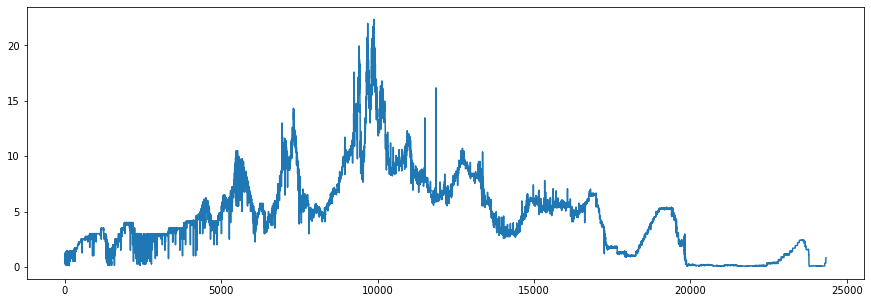

In [59]:
plt.figure(figsize=(15,5))
plt.plot(df_fed['value'])

In [44]:
df

날짜     S&P500     미국채10년       GSCI  기준금리  last_gdp  last_unem  \
0     2021-05-04  11.097391  48.192771  16.281368 -0.25      -3.4        6.7   
1     2021-05-03  12.571347  51.820728  17.105960 -0.25      -3.4        6.7   
2     2021-04-30  11.197450  55.988593  17.876970 -0.25      -3.4        6.7   
3     2021-04-29  11.528566  59.032577  16.264624 -0.25      -3.4        6.7   
4     2021-04-28   8.756708  57.308809  15.444055 -0.25      -3.4        6.7   
...          ...        ...        ...        ...   ...       ...        ...   
5292  2000-04-10   5.189039 -10.256410  11.199047  0.25       4.8        4.0   
5293  2000-04-07   6.968294  -9.434251  11.267855  0.25       4.8        4.0   
5294  2000-04-06   6.083732 -11.047128  11.846718  0.25       4.8        4.0   
5295  2000-04-05   6.810061  -9.416833   9.839233  0.25       4.8        4.0   
5296  2000-04-04   3.490929  -9.538975  11.591454  0.25       4.8        4.0   

      last_infl       CPI     달러인덱스  \
0           1.4  2.029159 -0.287315   
1           1.4  1.971019  0.324265   
2           1.4  1.990275  0.026499   
3           1.4  1.980892  0.183573   
4           1.4  1.971506  0.278023   
...         ...       ...       ...   
5292        2.7  0.859437  5.067064   
5293        2.7  0.893860  4.666667   
5294        2.7  0.901405  4.694040   
5295        2.7  0.908952  4.797601   
5296        2.7  0.916502  5.104895   

                                                     비율  
0     (Decimal('0.3'), Decimal('0.1'), Decimal('0.5'...  
1     (Decimal('0.1'), Decimal('0.1'), Decimal('0.5'...  
2     (Decimal('0.1'), Decimal('0.1'), Decimal('0.5'...  
3     (Decimal('0.1'), Decimal('0.1'), Decimal('0.5'...  
4     (Decimal('0.3'), Decimal('0.1'), Decimal('0.5'...  
...                                                 ...  
5292  (Decimal('0.1'), Decimal('0.3'), Decimal('0.5'...  
5293  (Decimal('0.1'), Decimal('0.3'), Decimal('0.5'...  
5294  (Decimal('0.1'), Decimal('0.3'), Decimal('0.5'...  
5295  (Decimal('0.1'), Decimal('0.3'), Decimal('0.5'...  
5296  (Decimal('0.1'), Decimal('0.3'), Decimal('0.5'...  

[5297 rows x 11 columns]

In [93]:
url = 'https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1652400000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'

In [94]:
driver = webdriver.Chrome('data_files/chromedriver.exe')

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_14748/3555466094.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('data_files/chromedriver.exe')


In [95]:
driver.get('https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1652400000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true')

In [114]:
last_height = driver.execute_script("return document.documentElement.scrollHeight")
last_height

16044

In [111]:
driver.execute_script(f"window.scrollTo(0, {last_height});")

In [116]:
SCROLL_PAUSE_SEC = 1
# 스크롤 높이 가져옴
last_height = driver.execute_script("return document.documentElement.scrollHeight")
time.sleep(SCROLL_PAUSE_SEC)
while True:
    # 끝까지 스크롤 다운
    driver.execute_script(f"window.scrollTo(0, {last_height});")

    # 1초 대기
    time.sleep(SCROLL_PAUSE_SEC)

    # 스크롤 다운 후 스크롤 높이 다시 가져옴
    new_height = driver.execute_script("return document.documentElement.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

In [117]:
html = driver.page_source

In [118]:
soup = BeautifulSoup(html, 'html.parser')

In [119]:
data = soup.select('table')

In [120]:
table = parser_functions.make2d(data[0])

In [123]:
df_sp = pd.DataFrame(data=table[1:], columns=table[0])

In [125]:
# df_sp[:-1].to_csv('data_files/S&P 500 1927이후 데이터.csv')

In [246]:
df_sp = pd.read_csv('data_files/S&P 500 1927이후 데이터.csv', index_col='Unnamed: 0')

In [247]:
df_doller = pd.read_csv('data_files/달러인덱스1970~.csv')

In [248]:
df_fed = pd.read_csv('data_files/fed-funds-rate-historical-chart.csv')

In [249]:
df_sp['Date'] = pd.to_datetime(df_sp['Date']).apply(lambda x: str(x)[:10])

In [250]:
df_doller = df_doller[['Date', 'Close']]
df_sp = df_sp[['Date', 'Close*']]

In [251]:
df_sp.columns = ['date', 'sp']
df_doller.columns = ['date', 'doller']
df_fed.columns = ['date', 'fed']

In [252]:
df_sp.isna().sum()

date    0
sp      0
dtype: int64

In [253]:
df_doller.dropna(inplace=True)

In [254]:
df_fed.dropna(inplace=True)

In [255]:
df_merge = pd.merge(df_sp, df_doller, how='inner', on='date')

In [256]:
df_merge = pd.merge(df_merge, df_fed, how='inner', on='date')

In [259]:
df_merge.isna().sum()

date      0
sp        0
doller    0
fed       0
dtype: int64

In [261]:
# df_merge.to_csv('data_files/sp_dol_fed 1971~.csv')